# Key Project Strategy Simulator - ZTF Events

The essential procedure for this simulation follows that outlined in kp_simulator.ipynb and kp_simulator_gaia.ipynb, for Gaia events.  Here the simulator is updated with ZTF specific information, such as visibility data. 

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate, optimize
import h5py
from os import path
import copy

## ZTF Event Sky Locations

Rodriguez et al. 2022 2022ApJ...927..150R published a list of 60 microlensing events identified between 2018 and 2020 in the ZTF Data Release catalog.  

This list was input to the skymap_events code to convert this into an approximate map of event rate per year per HEALpixel (see code skymap_events.py).  

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'ztf/ztf_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

ztf_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
ztf_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

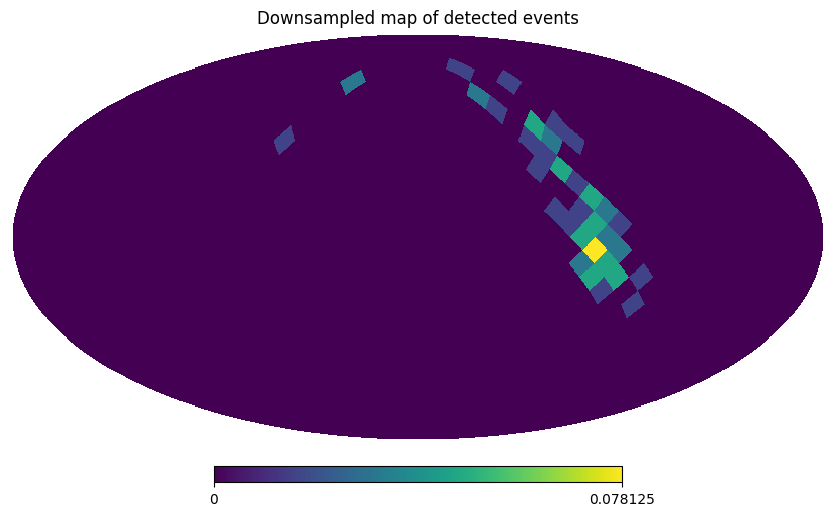

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(ztf_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

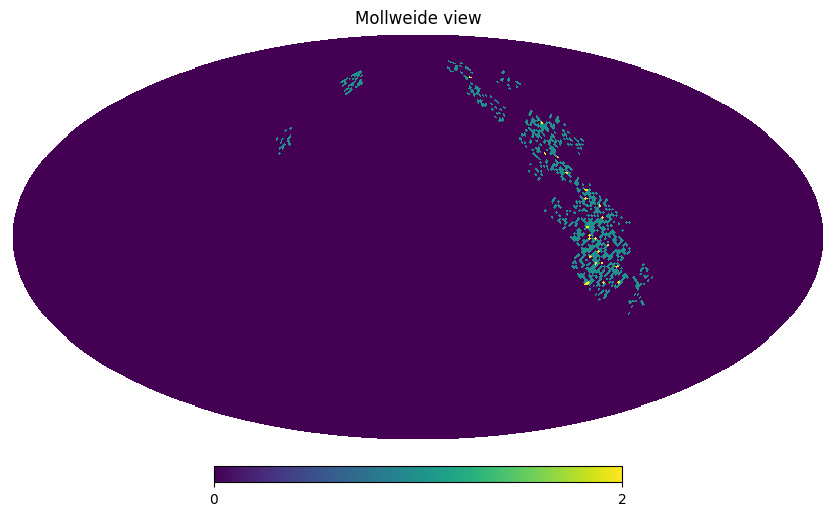

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = ztf_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 24.62431667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (279.140625, 12.02469722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (277.734375, -7.18075556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (297.421875, 24.62431667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -10.19991667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (286.171875, -14.47751111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (274.921875, 0.)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (296.015625, 35.68533333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (285.46875, 13.86194722)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (291.09375, 34.95386389)>"


## ZTF Event Baseline Magnitudes

Next we need to simulate the lightcurve data that ZTF would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  Though the ZTF description paper does not seem to  offer a histogram of the number of stars per magnitude bin, it does state that the field of view is 47sq.deg, and the magnitude range in SDSS-r band is 8 - 21.0.  

Instead, we query the ZTF Data Release 15 archive (https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd) for a representative sample of detections, which we can download in ASCII format. 

In [8]:
def read_ztf_catalog(file_path):
    file_lines = open(file_path, 'r').readlines()
    data = []
    filterdata = []
    for line in file_lines[0:100]:
        if '/' not in line[0:1] and '|' not in line[0:1] and '\\' not in line[0:1]:
            entries = line.replace('\n','').split()
            row = []
            for x in entries:
                try:
                    row.append(float(x))
                except ValueError:
                    filterdata.append(x)
            data.append(row)
    data = np.array(data)
    
    columns = ['oid', 'ra', 'dec', 'field', 'ccdid', 'qid', 'ngoodobs', 'ngoodobsrel', 'nobs', 'nobsrel',
               'refmag', 'refmagerr', 'astrometricrms', 'chisq', 'magrms', 'maxmag', 'medianabsdev', 'medianmag', 
               'medmagerr', 'minmag', 'dist', 'angle']
    
    table_columns = []
    for i,col in enumerate(columns):
        table_columns.append(Column(name=col, data=data[:,i], dtype=float))
    table_columns.append(Column(name='filtercode', data=filterdata, dtype='str'))
    
    return Table(table_columns)

In [9]:
ztf_catalog_file = './ztf/ztf.ztf_objects_dr15_20188.tbl'
ztf_catalog = read_ztf_catalog(ztf_catalog_file)
ztf_catalog

oid,ra,dec,field,ccdid,qid,ngoodobs,ngoodobsrel,nobs,nobsrel,refmag,refmagerr,astrometricrms,chisq,magrms,maxmag,medianabsdev,medianmag,medmagerr,minmag,dist,angle,filtercode
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2
764204100004272.0,269.841766,45.354709,764.0,4.0,1.0,1143.0,1123.0,1209.0,1189.0,13.507,0.026,3.368616e-07,5.821794,0.05893348,13.69313,0.04128742,13.53447,0.01051441,13.36732,0.893531,148.223608,zr
764104100002941.0,269.8417783,45.3547074,764.0,4.0,1.0,1041.0,1029.0,1144.0,1132.0,14.336,0.01,2.903239e-07,6.287887,0.07182106,14.55145,0.05274963,14.34262,0.01243766,14.17182,0.915113,146.757169,zg
764304100005149.0,269.8417737,45.3547005,764.0,4.0,1.0,146.0,75.0,172.0,97.0,13.215,0.035,4.42677e-07,4.858943,0.06207819,13.34283,0.05088663,13.18402,0.01552694,13.05626,0.929804,148.196157,zi
1763209200008664.0,269.8417838,45.3547012,1763.0,9.0,2.0,56.0,56.0,58.0,58.0,13.554,0.024,3.892876e-07,7.810446,0.0593996,13.62613,0.05332756,13.52777,0.01012278,13.42431,0.941411,146.793604,zr
1763109200005299.0,269.8417887,45.3546935,1763.0,9.0,2.0,44.0,25.0,51.0,30.0,14.31,0.022,5.048048e-07,10.29805,0.06933714,14.4146,0.07483768,14.31047,0.0107743,14.21071,0.971404,147.077268,zg
1763209200047878.0,269.8399777,45.3568871,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.026,0.213,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,8.159555,330.214417,zr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764204100037543.0,269.838482,45.3502772,764.0,4.0,1.0,18.0,18.0,18.0,18.0,22.417,0.322,5.396213e-06,1.839967,0.3860276,21.90929,0.2913923,21.50599,0.2347968,20.58989,18.460431,205.123847,zr
1763109200005325.0,269.8472827,45.3516467,1763.0,9.0,2.0,0.0,0.0,0.0,0.0,22.255,0.265,0.0,nan,0.0,0.0,0.0,0.0,nan,0.0,18.627824,129.239855,zg


Text(0, 0.5, 'Number of stars')

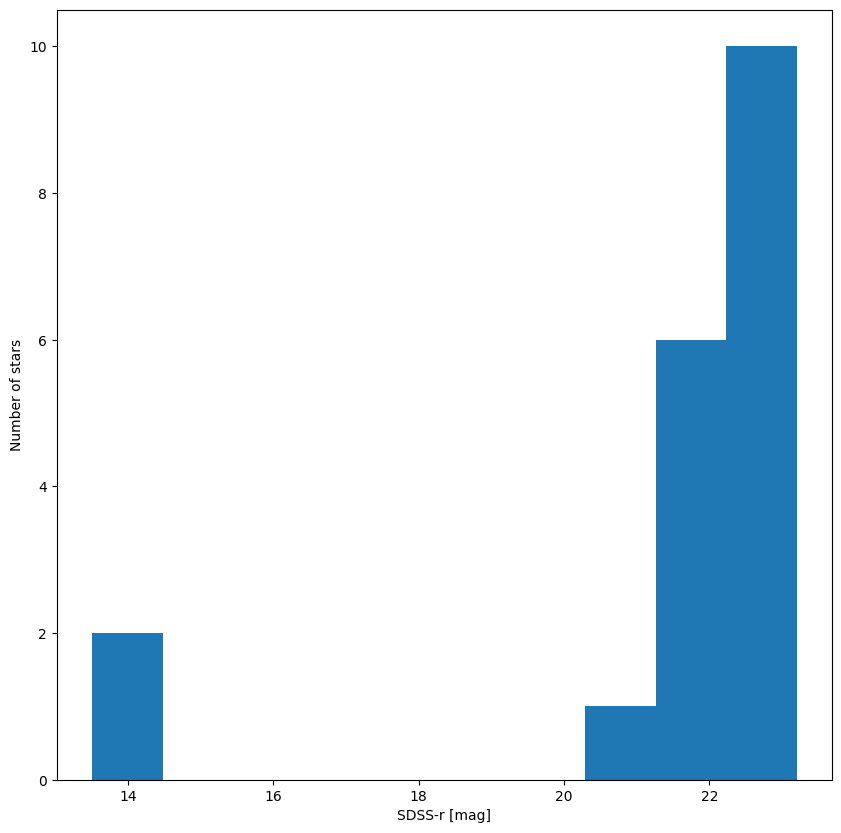

In [10]:
rdata = np.where(ztf_catalog['filtercode'] == 'zr')[0]
mags = ztf_catalog[rdata]['refmag']

fig = plt.figure(1,(10,10))
plt.hist(mags)
plt.xlabel('SDSS-r [mag]')
plt.ylabel('Number of stars')

Text(0.5, 1.0, 'Distribution of reference magnitudes of ZTF Detections')

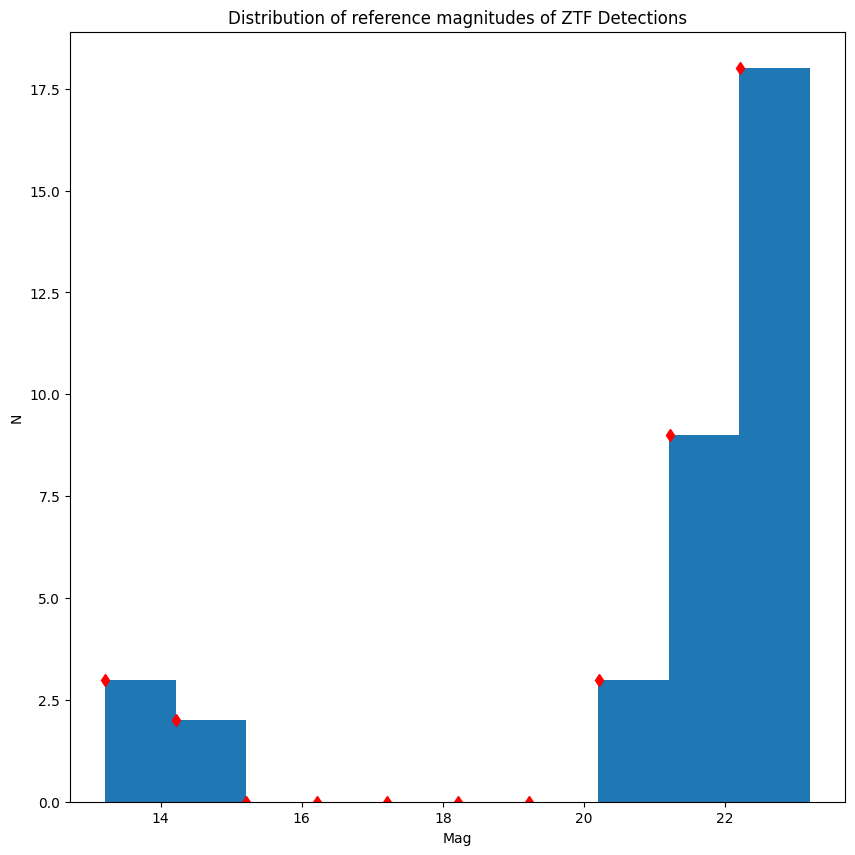

In [11]:
idx = np.where(ztf_catalog['refmag'] > 0.0)
mag_min = ztf_catalog['refmag'][idx].min()
mag_max = ztf_catalog['refmag'][idx].max() + 1.0
(mag_dist, mag_bins) = np.histogram(ztf_catalog['refmag'][idx], bins=np.arange(mag_min, mag_max, 1.0))


fig = plt.figure(1,(10,10))
plt.hist(ztf_catalog['refmag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of reference magnitudes of ZTF Detections')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for ZTF detections

Text(0.5, 1.0, 'Distribution of simulated ZTF detections')

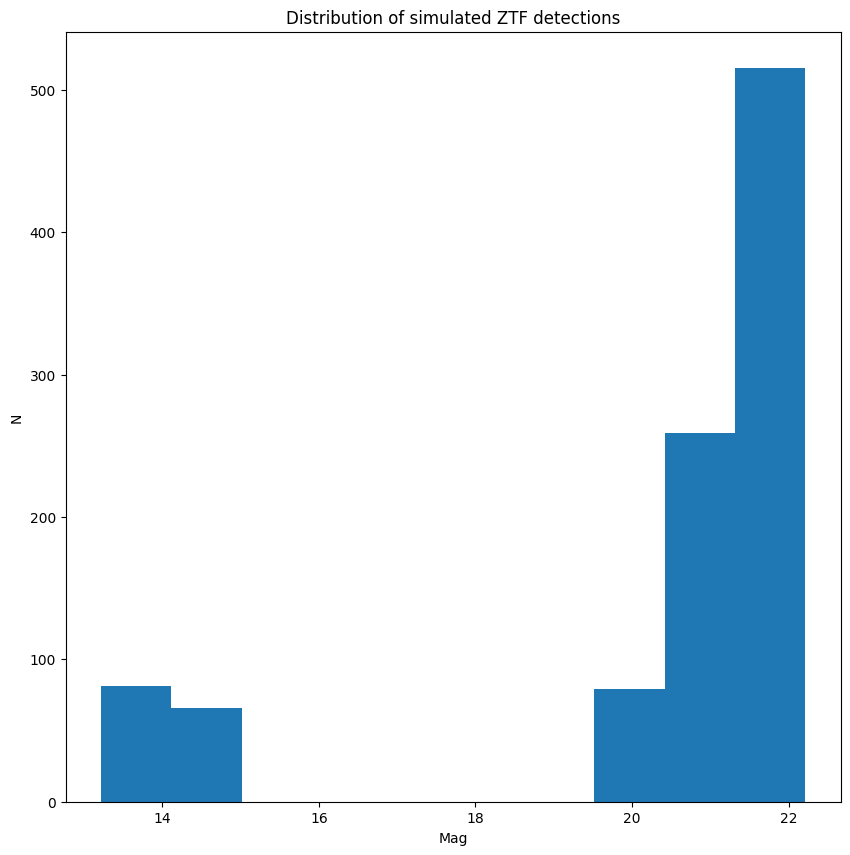

In [12]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated ZTF detections')

## ZTF Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [13]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [14]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [15]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

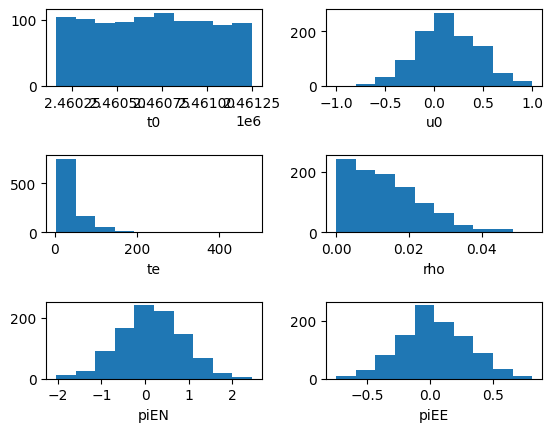

In [16]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

Based on experience from previous year's of survey data, approximately 10% of events are binary lenses, which show anomalies, caustic crossings and other lightcurve features that need higher cadence observations in order to characterize them.  

To simulate this, and estimate the total amount of time this would require, ideally we would simulate a set of binary events but modeling 100 such events would be extremely time consuming.  Instead, we randomly nominate 10% of events in the table to be binaries, and use this flag to trigger more intensive observations over the event peak.  This effectively simulates the real-world observations that would be made of a subtle (planetary-style) anomaly. 

While binary stellar events often take longer (the gap between caustic entry and exit can be a few days), they do not need to be monitored as intensively the whole time.  Instead, intensive observations would be required over the caustic crossings, returning to moderate cadence in the gap.  The difference in the time requirements will be taken into account at a later stage.  

In [17]:
binaries = np.random.random_integers(0, n_samples-1, int(0.1*n_samples))
binary_index = np.zeros(n_samples, dtype=int)
binary_index[binaries] = 1

For ease of handling, let's combine these data into a single events table

In [18]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('ZTFSim'+roundID(x))

In [19]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name="binary_lens", data=binary_index, dtype='int'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64
ZTFSim00001,14420,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 24.62431667)>",14.215,2460505.72732406,0.1471076161358919,103.79735233074895,0.023208692567800164,-0.6835642699913511,-0.29413145352027203,0.0,1
ZTFSim00002,19526,"<SkyCoord (ICRS): (ra, dec) in deg\n (279.140625, 12.02469722)>",13.215,2460281.442406824,0.38019534669362437,13.853976375404276,0.019597589862885838,-0.36727499298330796,0.13247367239570526,0.0,0
ZTFSim00003,27717,"<SkyCoord (ICRS): (ra, dec) in deg\n (277.734375, -7.18075556)>",21.215,2460946.2625300405,-0.5074136375262424,15.483811510952336,0.017264314426881075,-0.47007378988928866,0.48189056553474274,0.0,1
ZTFSim00004,14419,"<SkyCoord (ICRS): (ra, dec) in deg\n (297.421875, 24.62431667)>",22.215,2460487.9547006306,-0.09993750953965011,7.520219559928271,0.007908350779742496,-0.08803140927946163,0.0002727903083619629,0.0,0
ZTFSim00005,28992,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -10.19991667)>",22.215,2460275.4567663763,0.08596441722885131,21.234373747920657,0.016479186175325913,1.3205762106130228,-0.09221053653348107,0.0,0
ZTFSim00006,30795,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.171875, -14.47751111)>",22.215,2460322.086321098,-0.1739802565806833,63.2438451779635,0.0009989649837846316,-0.9082760557609881,0.20405807833464784,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,31799,"<SkyCoord (ICRS): (ra, dec) in deg\n (258.046875, -16.95776111)>",21.215,2461076.677072729,0.2723578773647216,67.67978650524496,0.016891866776541725,0.7442512801821763,0.355187119792113,0.0,0
ZTFSim00995,13908,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 25.94447778)>",22.215,2461140.18114347,0.05603725427994212,52.83023901800655,0.024515565239143937,-0.5026635941669053,0.6433685880671545,0.0,0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for ZTF events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of ZTF events. 


## ZTF Event Lightcurve sampling

In order to generate realistic ZTF lightcurves, we used the sampling of ZTF lightcurves from ZTF Data Release 14 to map the number of visits the survey made to each HEALpixel on the sky in the notebook ztf_survey_cadence.  This includes the total number of visits by ZTF between MJD=58194.0 to 59830.0, or 4.4 yrs.  Since this is a longer period than the Key Project, we scale the expected total numbers of visits per filter accordingly.  

In [20]:
ztf14_duration = 59830.0 - 58194.0
kp_duration = 365.24*3.0
scale_factor = kp_duration / ztf14_duration
scale_factor

0.6697555012224939

In [21]:
map_file_path = 'ztf/ztf_nvisits_healpix_table.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

ztf_nvisits = Table([
                        Column(name="HPid", data=data_table['HPid'], dtype='int'),
                        Column(name="Nvisits_all", data=data_table['Nvisits_all']*scale_factor, dtype='int'),
                        Column(name="Nvisits_g", data=data_table['Nvisits_g']*scale_factor, dtype='int'),
                        Column(name="Nvisits_r", data=data_table['Nvisits_r']*scale_factor, dtype='int'),
                        Column(name="Nvisits_i", data=data_table['Nvisits_i']*scale_factor, dtype='int'),
                        ])
ztf_nvisits

HPid,Nvisits_all,Nvisits_g,Nvisits_r,Nvisits_i
int64,int64,int64,int64,int64
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,71,32,39,0
6,0,0,0,0
...,...,...,...,...
49146,0,0,0,0
49147,0,0,0,0


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [22]:
events_table['nvisits_g'] = ztf_nvisits['Nvisits_g'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_r'] = ztf_nvisits['Nvisits_r'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table['nvisits_i'] = ztf_nvisits['Nvisits_i'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens,nvisits_g,nvisits_r,nvisits_i
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
ZTFSim00001,14420,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 24.62431667)>",14.215,2460505.72732406,0.1471076161358919,103.79735233074895,0.023208692567800164,-0.6835642699913511,-0.29413145352027203,0.0,1,781,1336,228
ZTFSim00002,19526,"<SkyCoord (ICRS): (ra, dec) in deg\n (279.140625, 12.02469722)>",13.215,2460281.442406824,0.38019534669362437,13.853976375404276,0.019597589862885838,-0.36727499298330796,0.13247367239570526,0.0,0,300,894,12
ZTFSim00003,27717,"<SkyCoord (ICRS): (ra, dec) in deg\n (277.734375, -7.18075556)>",21.215,2460946.2625300405,-0.5074136375262424,15.483811510952336,0.017264314426881075,-0.47007378988928866,0.48189056553474274,0.0,1,252,689,186
ZTFSim00004,14419,"<SkyCoord (ICRS): (ra, dec) in deg\n (297.421875, 24.62431667)>",22.215,2460487.9547006306,-0.09993750953965011,7.520219559928271,0.007908350779742496,-0.08803140927946163,0.0002727903083619629,0.0,0,405,618,121
ZTFSim00005,28992,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -10.19991667)>",22.215,2460275.4567663763,0.08596441722885131,21.234373747920657,0.016479186175325913,1.3205762106130228,-0.09221053653348107,0.0,0,129,389,0
ZTFSim00006,30795,"<SkyCoord (ICRS): (ra, dec) in deg\n (286.171875, -14.47751111)>",22.215,2460322.086321098,-0.1739802565806833,63.2438451779635,0.0009989649837846316,-0.9082760557609881,0.20405807833464784,0.0,0,117,500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFSim00994,31799,"<SkyCoord (ICRS): (ra, dec) in deg\n (258.046875, -16.95776111)>",21.215,2461076.677072729,0.2723578773647216,67.67978650524496,0.016891866776541725,0.7442512801821763,0.355187119792113,0.0,0,105,432,0
ZTFSim00995,13908,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 25.94447778)>",22.215,2461140.18114347,0.05603725427994212,52.83023901800655,0.024515565239143937,-0.5026635941669053,0.6433685880671545,0.0,0,787,1340,229


Store the table of simulated event parameters

In [23]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_g', array=events_table['nvisits_g'], format='I5'))
column_list.append(fits.Column(name='nvisits_r', array=events_table['nvisits_r'], format='I5'))
column_list.append(fits.Column(name='nvisits_i', array=events_table['nvisits_i'], format='I5'))
column_list.append(fits.Column(name='binary_lens', array=events_table['binary_lens'], format='I1'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_events_table.fits', overwrite=True)


## ZTF Event Lightcurves

Now we can simulate the lightcurves that ZTF would produce for these simulated events.  We assume that ZTF's survey strategy for the public Galactic Plane survey is roughly consistent with its previous strategy, and approximate the distribution of visits in the different filters as uniform.  

Firstly though, we need to establish a photometric noise function for the magnitude uncertainties in the lightcurve. This we can do using the photometry derived from the ZTF catalog above to derive noise model coefficients for the three bandpasses.  

In [24]:
gdata = np.where(ztf_catalog['filtercode']=='zg')[0]
rdata = np.where(ztf_catalog['filtercode']=='zr')[0]
idata = np.where(ztf_catalog['filtercode']=='zi')[0]

gmags = np.zeros((len(gdata),2))
rmags = np.zeros((len(rdata),2))
imags = np.zeros((len(idata),2))
gmags[:,0] = ztf_catalog[gdata]['refmag']
gmags[:,1] = np.log10(ztf_catalog[gdata]['refmagerr'])
rmags[:,0] = ztf_catalog[rdata]['refmag']
rmags[:,1] = np.log10(ztf_catalog[rdata]['refmagerr'])
imags[:,0] = ztf_catalog[idata]['refmag']
imags[:,1] = np.log10(ztf_catalog[idata]['refmagerr'])

In [25]:
def straight_line(x, a, b):
    return a + b*x

In [26]:
(gparam, gcov) = optimize.curve_fit(straight_line, gmags[:,0], gmags[:,1])
(rparam, rcov) = optimize.curve_fit(straight_line, rmags[:,0], rmags[:,1])
(iparam, icov) = optimize.curve_fit(straight_line, imags[:,0], imags[:,1])

Text(0, 0.5, 'Mag err')

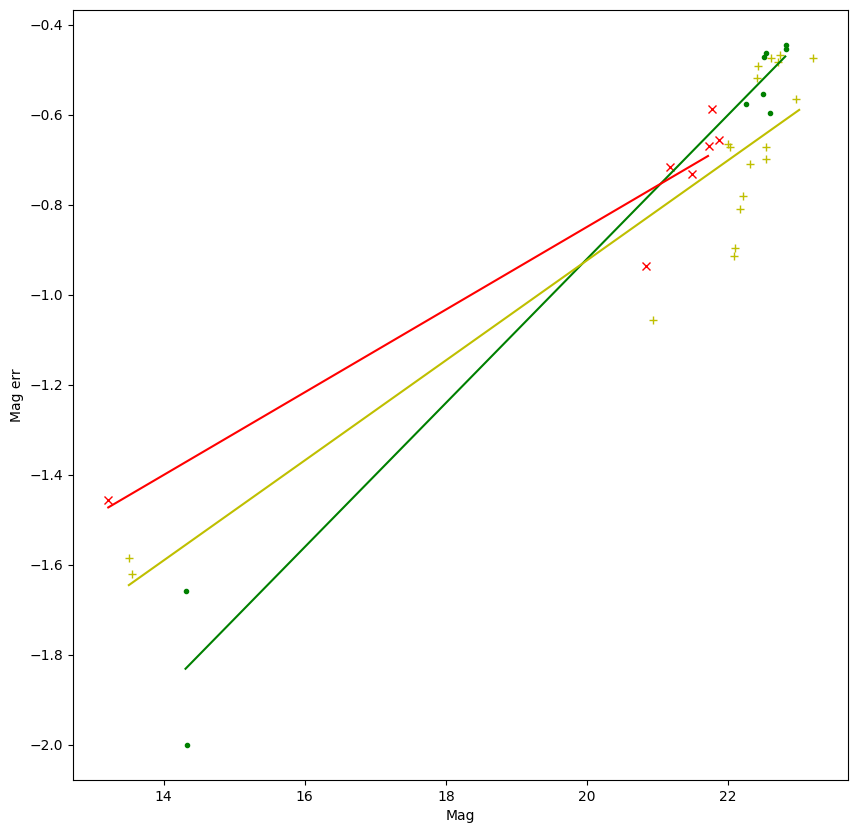

In [27]:
fig = plt.figure(2,(10,10))
plt.plot(gmags[:,0], gmags[:,1], 'g.', label='ZTF-g')
plt.plot(rmags[:,0], rmags[:,1], 'y+', label='ZTF-r')
plt.plot(imags[:,0], imags[:,1], 'rx', label='ZTF-i')

xdata = np.arange(gmags[:,0].min(), gmags[:,0].max(), 0.25)
ydata = straight_line(xdata, gparam[0], gparam[1])
plt.plot(xdata, ydata, 'g-')

xdata = np.arange(rmags[:,0].min(), rmags[:,0].max(), 0.25)
ydata = straight_line(xdata, rparam[0], rparam[1])
plt.plot(xdata, ydata, 'y-')

xdata = np.arange(imags[:,0].min(), imags[:,0].max(), 0.25)
ydata = straight_line(xdata, iparam[0], iparam[1])
plt.plot(xdata, ydata, 'r-')

plt.xlabel('Mag')
plt.ylabel('Mag err')

In [28]:
noise_model = {'g': gparam, 'r': rparam, 'i': iparam}

In [29]:
def simulate_event_ztf(event_params, noise_model, start_date, end_date, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Loop over all three filters and simulate the event separately in the different passbands
    # to ensure the proper noise properties and sampling are handled correctly.  
    sim_events = {}
    for f in ['g', 'r', 'i']:
    
        # Simulate timestamps in this filter
        cadence = (end_date - start_date) / event_params['nvisits_'+f]
        timestamps = np.arange(start_date, end_date, cadence)
    
        # Create a PyLIMA event object
        sim_event = event.Event()
        sim_event.name = event_params['EventID']
        sim_event.ra = float(event_params['location'].ra.deg)
        sim_event.dec = float(event_params['location'].dec.deg)

        # Generate a constant lightcurve at the event's baseline magnitude (neglecting differences due to color), 
        # with fixed photometric uncertainties, since these will be replaced later
        lc = np.zeros((len(timestamps),3))
        lc[:,0] = timestamps
        lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
        lc[:,2] = [0.01] * len(timestamps)
        print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
        # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
        tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                         light_curve_magnitude=lc,
                                         location='Earth',
                                         light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                         clean_the_lightcurve=False)

        sim_event.telescopes.append(tel)
        sim_event.find_survey('ZTF')
    
        # Add a PyLIMA model to the event, using the simulated parameters
        if parallax:
            sim_model = microlmodels.create_model('FSPL', sim_event,
                                              parallax=['Full',float(event_params['t0'])])
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                                  float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

        else:
            sim_model = microlmodels.create_model('FSPL', sim_event)
            lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho'])]

        sim_model.define_model_parameters()
    
        if parallax:
            sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
        tel = sim_model.event.telescopes[0]
    
        pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
        #print(event_params)
    
        # Use the PyLIMA model to add a lensing event into the lightcurve
        magnification = sim_model.model_magnification(tel, pylima_parameters)
        A = sim_model.model_magnification(tel,pylima_parameters)
        lightcurve = sim_event.telescopes[0].lightcurve_magnitude
        lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
        log_errors = straight_line(lightcurve[:,1], noise_model[f][0], noise_model[f][1])
        lightcurve[:,2] = 10**(log_errors)
        sim_event.telescopes[0].lightcurve_magnitude = lightcurve
        print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
        
        sim_events[f] = sim_event
        
    # Microlensing lightcurves are independent of color to first order.  In the interests of re-using
    # code below, we combine the simulated lightcurve in different colors into a single array
    # for convenience
    
    ztf_event = event.Event()
    ztf_event.name = event_params['EventID']
    ztf_event.ra = float(event_params['location'].ra.deg)
    ztf_event.dec = float(event_params['location'].dec.deg)
    
    lightcurve = np.concatenate((sim_events['g'].telescopes[0].lightcurve_magnitude, 
                                 sim_events['r'].telescopes[0].lightcurve_magnitude))
    lightcurve = np.concatenate((lightcurve, 
                                 sim_events['i'].telescopes[0].lightcurve_magnitude))
    
    tel = telescopes.Telescope(name='ZTF', camera_filter=f,
                                     light_curve_magnitude=lightcurve,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    ztf_event.telescopes.append(tel)
    ztf_event.find_survey('ZTF')
    
    if parallax:
        ztf_model = microlmodels.create_model('FSPL', ztf_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

    else:
        ztf_model = microlmodels.create_model('FSPL', ztf_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]

    ztf_model.define_model_parameters()

    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)

    pylima_parameters = ztf_model.compute_pyLIMA_parameters(lensing_parameters)

    return ztf_event, ztf_model, lensing_parameters

Parallax for ZTF events is predominately the annual parallax signature caused by the motion of the Earth during an event, which PyLIMA can calculate internally.  

In [30]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

ztf_lens, ztf_lens_model, lens_model_pars = simulate_event_ztf(events_table[event_number], noise_model, start_date, end_date, parallax=True)



Picked bright event:  0  baseline_mag= 14.215 mag
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.206731048502107
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.206746107861271
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.20677367803862
Parallax(Full) estimated for the telescope ZTF: SUCCESS


  EventID     HP                               location                              baseline_mag        t0                u0                 te                 rho                  piEN                piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------------ ------------ ---------------- ------------------ ------------------ -------------------- ------------------- -------------------- ------- ----------- --------- --------- ---------
ZTFSim00001 14420 <SkyCoord (ICRS): (ra, dec) in deg\n    (298.828125, 24.62431667)>       14.215 2460505.72732406 0.1471076161358919 103.79735233074895 0.023208692567800164 -0.6835642699913511 -0.29413145352027203     0.0           1       781      1336       228


Text(0.5, 1.0, 'Simulated event ZTFSim00001')

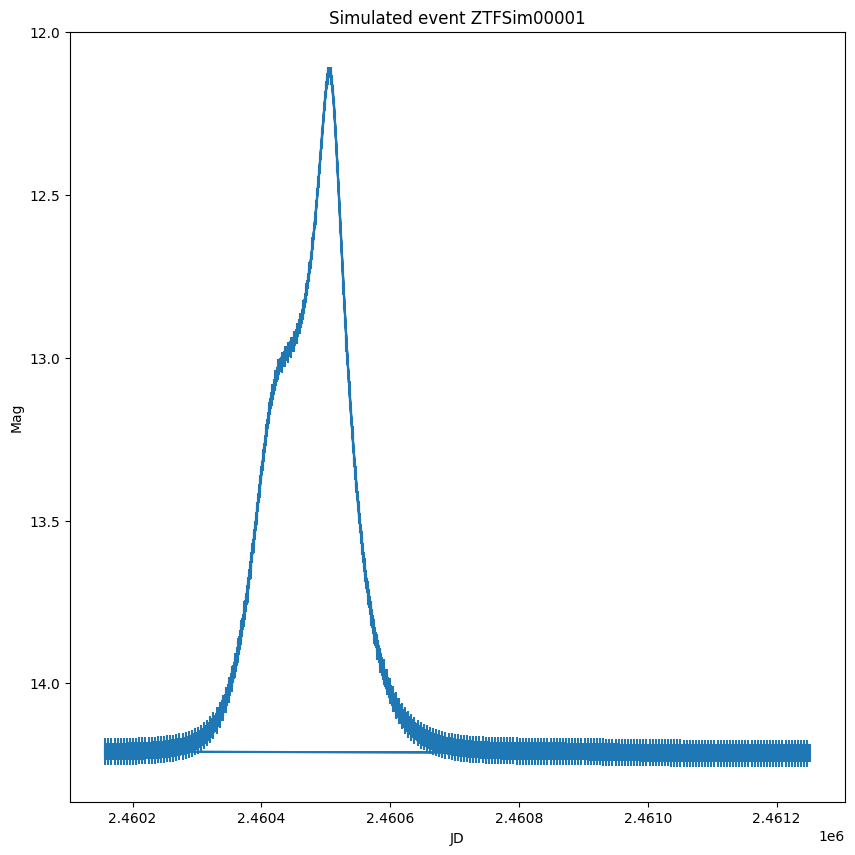

In [31]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = ztf_lens.telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

Simulate all events

In [32]:
sim_ztf_lenses = []
sim_ztf_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (ztf_lens, ztf_lens_model, lens_model_pars) = simulate_event_ztf(events_table[ievent], noise_model, start_date, end_date, parallax=True)
    sim_ztf_lenses.append(ztf_lens)
    sim_ztf_lens_models.append(ztf_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.206731048502107
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.206746107861271
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.20677367803862
Parallax(Full) estimated for the telescope ZTF: SUCCESS
0 [2460505.72732406, 0.1471076161358919, 103.79735233074895, 0.023208692567800164, -0.6835642699913511, -0.29413145352027203]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21499701301886
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214997047162353
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214994553519421
Parallax(Full) estimated for the telescope ZTF: SUCCESS
1 [2460281.442406824, 0.38019534669362437, 13.853976375404276, 0.019597589862885838, -0.36727499298330796, 0.13247367239570526]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499871820157
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998728259086
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214998753856744
Parallax(Full) estimated for the telescope ZTF: SUCCESS
18 [2460949.159789513, -0.07038503325482032, 7.866657871949393, 0.01629764686856653, 0.6554130043541535, -0.02613830844196704]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214936856081964
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214936506450726
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214935929989823
Parallax(Full) estimated for the telescope ZTF: SUCCESS
19 [2460488.9901564512, 0.19364049706817116, 21.400953355844795, 0.015248120212613748, 0.4821014908796043, 0.05887341797867046]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
35 [2461197.9418993127, -0.22528513926570556, 8.303341997678467, 0.0039045298557886295, 0.030275134836772633, 0.39035427004603074]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999963164896
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999963226017
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499996048155
Parallax(Full) estimated for the telescope ZTF: SUCCESS
36 [2460934.62042835, 0.01085042396731875, 3.1515732589915086, 0.0010948476408873193, 0.06841552715129114, 0.5864191202722835]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21499465312906
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214994689800925
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214994681754536
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
53 [2461037.1328726015, 0.46331767079780206, 5.647440295719066, 0.01992795601847115, -0.07261630265930932, 0.0028990595488296786]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21467374903713
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214676992753578
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214678907483908
Parallax(Full) estimated for the telescope ZTF: SUCCESS
54 [2460273.045663227, 0.0008736509376102153, 123.50163357895921, 0.0075115036168640365, 1.500677556001751, 0.017940778276454118]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214903183086776
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21490470066776
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214905213267468
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.10153603104332
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.100696586605288
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.095877753556547
Parallax(Full) estimated for the telescope ZTF: SUCCESS
72 [2460723.480126552, -0.22537271591130634, 88.0264738487536, 0.0033950640752656953, 0.18339651809061913, 0.23022755564482994]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214958876105495
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214959010569945
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214959821052776
Parallax(Full) estimated for the telescope ZTF: SUCCESS
73 [2460943.6229301263, 0.14967107577164973, 19.54368366635876, 0.03520751535978566, 0.4430319812845982, -0.021903469268381832]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
90 [2460834.7351360694, -0.24714493137236523, 17.4155674184806, 0.010363443348896332, -0.13020941166218603, -0.03815820330973151]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.202211062916724
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.202225628283095
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.202177757531759
Parallax(Full) estimated for the telescope ZTF: SUCCESS
91 [2460843.8527516397, 0.02392915604231763, 61.74788289863618, 0.024719182043582685, 0.49626482576905084, -0.46886390743749057]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214494374323795
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214494685975843
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214467593173712
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214247037050946
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214248295825346
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21425028661272
Parallax(Full) estimated for the telescope ZTF: SUCCESS
108 [2460579.6700342917, 0.23418996142321918, 53.43995629413893, 0.0029733290123719587, 0.3077807903628049, 0.4425541213561781]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214732024046857
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214731600446488
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21476753613322
Parallax(Full) estimated for the telescope ZTF: SUCCESS
109 [2460740.462952881, 0.1297752701528805, 28.739855378539453, 0.013471490799683301, 0.5248679399478885, -0.3481994210701276]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
125 [2460993.7148040477, 0.4488964053057569, 31.568462632080113, 0.0020722503424152926, 0.1380079505849613, 0.05298747653625771]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21417828867806
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21417731409034
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214412307295998
Parallax(Full) estimated for the telescope ZTF: SUCCESS
126 [2460472.989081738, 0.08348835344966904, 123.01183631536948, 0.000979484644666153, 1.0021719686232895, 0.40011149693688847]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214813651428642
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214816690701685
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214968253468623
Parallax(Full) estimated for the telescope ZTF: SUCCESS
1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213651973267886
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213838241520897
Parallax(Full) estimated for the telescope ZTF: SUCCESS
144 [2461243.191996495, 0.44360150533431664, 97.88878338358641, 0.0077045809305555085, 0.4954663829492618, -0.1813465948122237]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999932029176
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999933429745
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21391252050848
Parallax(Full) estimated for the telescope ZTF: SUCCESS
145 [2460200.452377999, 0.23772876556049966, 6.754282444001839, 0.029972562823460704, 1.1719183496795855, -0.5068512792267196]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214506433120576
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214998965486927
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214999021479022
Parallax(Full) estimated for the telescope ZTF: SUCCESS
162 [2461206.0863628313, -0.18850026246623683, 14.058049837848756, 0.015264502199278173, -0.27728830335524474, -0.16927386394527213]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998937892865
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998931330292
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998361293606
Parallax(Full) estimated for the telescope ZTF: SUCCESS
163 [2460622.3307911535, 0.20230865306450369, 7.920639902764704, 0.02361436177794609, 0.5119246377645561, -0.5492073686582737]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214348629576072
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
179 [2460989.272354164, 0.6564004376023139, 5.363112512292879, 0.009593195540135291, 0.29288913021642615, 0.20488417100480963]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214992937138053
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214992721341083
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214993094920109
Parallax(Full) estimated for the telescope ZTF: SUCCESS
180 [2461014.8355061347, 0.1837458404378759, 12.31358160180488, 0.001592838048929751, -0.6151089437122457, 0.3479419329720421]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999607493056
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499960880224
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499959748335
Parallax(Full) estimated for the telescope ZTF: SUCCESS
181 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213237712466654
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213240111671794
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213203095292616
Parallax(Full) estimated for the telescope ZTF: SUCCESS
198 [2460767.0171178603, 0.37237740145440557, 29.215698117633117, 0.0013926017575348025, 0.4161733084447466, 0.49469280514136094]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214986374388612
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498641245316
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985902480485
Parallax(Full) estimated for the telescope ZTF: SUCCESS
199 [2460417.5537887434, 0.17630011382355273, 24.078175472682137, 0.019128793939339465, -1.5389875271718547, -0.3400974994700252]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21487455337478
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21487033062003
Parallax(Full) estimated for the telescope ZTF: SUCCESS
216 [2460268.3387639993, 0.4709931805017804, 48.183592189935055, 0.002621218302521433, 0.544336007364193, -0.07415696337916189]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214811209578805
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21481243775974
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214820859164174
Parallax(Full) estimated for the telescope ZTF: SUCCESS
217 [2460493.3932334716, -0.020662291374336922, 33.74185225560609, 0.0169542425620212, -0.02713343981596028, 0.39255982974925263]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.213474927976112
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
233 [2460235.19647166, -0.1639857192917469, 9.772326491735392, 0.014628497856104386, -0.049870959118493846, -0.3042446434638512]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985039196982
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214985034282513
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21497918135819
Parallax(Full) estimated for the telescope ZTF: SUCCESS
234 [2460777.478354931, 0.4046495041274045, 15.232951606140688, 0.012700820932639124, -0.48916487142753656, -0.12869822941541734]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21488578185572
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214883899085564
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214881591809807
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214994985537995
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214994949530515
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.21499537031775
Parallax(Full) estimated for the telescope ZTF: SUCCESS
251 [2461003.716953542, 0.23013875745214862, 12.740519830766782, 0.011588569384629792, 0.5394816848434164, 0.07571039461620133]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987935699288
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987823555447
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214987907477926
Parallax(Full) estimated for the telescope ZTF: SUCCESS
252 [2460749.196414782, 0.1756848455251777, 13.14989518197532, 0.0297980292023984, 0.46726655284506013, -0.164381093300267]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.21

Parallax(Full) estimated for the telescope ZTF: SUCCESS
269 [2460634.134612651, 0.4036827217673937, 64.53459521829015, 0.021472409165307973, 0.16219242297730516, 0.49489231778979714]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.20381478467462
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.203175991144768
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.206599681695614
Parallax(Full) estimated for the telescope ZTF: SUCCESS
270 [2461163.022041879, 0.027566094534655874, 166.32706154717252, 0.011745006429168892, 0.6072030788584637, -0.0016877262631379564]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20613421383329
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.206247042909556
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.206247283994387
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214922533915853
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499767635116
Parallax(Full) estimated for the telescope ZTF: SUCCESS
287 [2461062.8267427683, -0.13209601367930332, 31.32683908448507, 0.009491416609822348, 1.7685652111874017, 0.2947026683386729]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20552841472749
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20549537107723
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.205659610087082
Parallax(Full) estimated for the telescope ZTF: SUCCESS
288 [2460559.0929122916, 0.04922900315645462, 59.425065622865226, 0.008769630690196805, -0.03666725652914668, -0.3407132589983776]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214990032293265
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214005390863868
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21400770518298
Parallax(Full) estimated for the telescope ZTF: SUCCESS
305 [2460720.90976355, 0.0805333729918013, 42.43505126404853, 0.011850359841912989, 0.15712907915665086, -0.08329699657489714]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213960051713897
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213962670229403
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213950005747666
Parallax(Full) estimated for the telescope ZTF: SUCCESS
306 [2460884.6919107554, 0.07851952658455884, 40.81122596478289, 0.020491150867755957, -0.10063135729576278, -0.000628820763834588]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.2149425852003
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
322 [2460179.0545278257, 0.2800219164115634, 43.64760962435388, 0.019972336832370114, 0.8215942654606583, -0.03785265146125844]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.208990434256094
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.208913246170525
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20907937409413
Parallax(Full) estimated for the telescope ZTF: SUCCESS
323 [2461059.25612214, 0.6328894768748997, 64.27648237493179, 0.010005104726553884, -0.017961916703808672, 0.24205832284955098]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.188752702698565
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.188807901240196
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.188515837793634
Parallax(Full) estimated for the telescope ZTF: SUCCESS
3

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213947123205624
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214887952928972
Parallax(Full) estimated for the telescope ZTF: SUCCESS
340 [2460696.0719386376, 0.2847295295472135, 52.08539794266843, 0.021019919412568082, 0.6721926233767148, -0.12949125650733348]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214908430163284
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2149081224913
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214912226049247
Parallax(Full) estimated for the telescope ZTF: SUCCESS
341 [2460799.534085761, 0.29558800045189926, 22.933217726785603, 0.0012674681107797889, 0.8718014139309944, 0.38133438316876106]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21481725581959
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.212102223580967
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21211187816689
Parallax(Full) estimated for the telescope ZTF: SUCCESS
358 [2460725.62709263, 0.20879548826861388, 34.65467166086065, 0.003176554662435157, 0.9880538733976911, 0.3948001861201366]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214934257667519
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214934070244704
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214920086755296
Parallax(Full) estimated for the telescope ZTF: SUCCESS
359 [2460946.03921095, 0.06450307208292931, 29.077079684609153, 0.003069208519013737, 1.1161965394801214, 0.16610719686552908]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214990881496092
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.21

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214913344780122
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214912481905145
Parallax(Full) estimated for the telescope ZTF: SUCCESS
376 [2460968.7357963254, 0.25236514386176756, 20.379377649272325, 0.0039764760025428475, -0.749675192768938, -0.08114424613914217]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.2061247611964
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.206119442192733
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.206159106825798
Parallax(Full) estimated for the telescope ZTF: SUCCESS
377 [2460912.793457629, 0.31986910007587, 91.24591670112633, 0.02340044640750833, -0.8206159456949551, 0.03889525819740337]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.212926698489817
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.

21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2147608970168
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21475775280357
Parallax(Full) estimated for the telescope ZTF: SUCCESS
395 [2460775.3389577847, -0.19836711195940251, 31.22353604907589, 0.02539472517301474, -0.4447617662633309, 0.12107942953175166]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21489462751422
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214893165524316
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214893993021374
Parallax(Full) estimated for the telescope ZTF: SUCCESS
396 [2460748.908894978, 0.29248781835460413, 31.067951516069186, 0.016210037396319765, -0.7565449121913863, -0.048095910329547555]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499481956873
22.215 22.215
Parallax(Full) estimated for the telescope 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
414 [2460342.928235734, -0.11465974522236563, 15.516198563842037, 0.009794211696663127, -0.46268191463789304, 0.6630843202969918]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21398837835823
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21398772271332
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213995041379903
Parallax(Full) estimated for the telescope ZTF: SUCCESS
415 [2460549.544039114, 0.4287577279174676, 65.05825907508414, 0.019036693429090742, 0.678532308970319, -0.16892084938362387]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214997337005613
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214997371771997
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.210897885415154
Parallax(Full) estimated for the telescope ZTF: SUCCESS
41

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21490358761836
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214905498430053
Parallax(Full) estimated for the telescope ZTF: SUCCESS
433 [2460541.583561361, 0.1043942081532771, 52.83967493611658, 0.024133231160167697, 1.8411152432348707, 0.12798742482222497]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21481548227759
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214814542654484
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214818505160547
Parallax(Full) estimated for the telescope ZTF: SUCCESS
434 [2460927.911410362, -0.11282367280060682, 31.106967292144716, 0.019537392725265314, 0.4394921824332214, -0.21251675794843886]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981533198813
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20

Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.207391332637046
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.20737926078192
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.207319089006656
Parallax(Full) estimated for the telescope ZTF: SUCCESS
451 [2460991.1436366076, 0.03249220076420642, 52.21140941919997, 0.03303980221723819, -0.2356227547037869, 0.18916299915181525]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997391607163
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997303033122
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214997297188827
Parallax(Full) estimated for the telescope ZTF: SUCCESS
452 [2460820.479545323, -0.1236030507051589, 9.0993146218102, 0.003927876302776063, -0.2143141158334428, -0.05241869680141104]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20

Parallax(Full) estimated for the telescope ZTF: SUCCESS
468 [2460744.107485861, 0.6688734024856454, 37.822028763501166, 0.03243094430538358, -0.36195561674214877, -0.11299683339481373]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999968501775
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999968660415
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499999710203
Parallax(Full) estimated for the telescope ZTF: SUCCESS
469 [2460656.7097894265, -0.16266334744188196, 3.0654603722829443, 0.014442844409252927, 0.9513031368494704, -0.20704039657095127]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21400730785864
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21400120609661
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214797994778287
Parallax(Full) estimated for the telescope ZTF: SUCCESS

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214298813072475
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214287406551833
Parallax(Full) estimated for the telescope ZTF: SUCCESS
486 [2460813.42734016, 0.5349699667563607, 67.90661762144919, 0.004236032863344975, -0.38961980627746456, 0.5232987506519273]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213642012134343
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.213632415385682
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21363973810721
Parallax(Full) estimated for the telescope ZTF: SUCCESS
487 [2460492.891523305, -0.010205879651638522, 44.26570997075323, 0.010082040804026691, 0.14400580090048706, 0.004089192164790936]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214995406083258
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.210003683893603
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.210124728886345
Parallax(Full) estimated for the telescope ZTF: SUCCESS
504 [2460541.409652156, 0.4332191035687374, 51.592215520843645, 0.0019673670931472844, 0.19694570320862786, -0.3982358285818897]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214879014395684
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214879530897484
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499466193823
Parallax(Full) estimated for the telescope ZTF: SUCCESS
505 [2460830.3129609423, -0.11372758615553799, 74.44746939047576, 0.008118678939744038, -2.0032234029711447, -0.2216200526149675]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214997098008553
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
521 [2461110.32109038, 0.29822031090129264, 84.8422864727628, 5.07385748168554e-05, -0.6058109344471796, -0.09919547412990107]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499380254892
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214993859474767
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499163915162
Parallax(Full) estimated for the telescope ZTF: SUCCESS
522 [2460422.289953568, 0.2864479631745324, 15.200704171581114, 0.013511616312411968, -1.1206053337683304, -0.09604202493817438]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492656060251
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492662046529
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21492693282527
Parallax(Full) estimated for the telescope ZTF: SUCCESS
523 [

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.20294155180494
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.202946073339195
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.202917260346325
Parallax(Full) estimated for the telescope ZTF: SUCCESS
540 [2460545.292020974, 0.5562828466366816, 150.10102315704543, 0.007889233803778066, -0.21982004616098716, 0.35659036313115766]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21395860845748
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.213957987269684
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.213859627624757
Parallax(Full) estimated for the telescope ZTF: SUCCESS
541 [2460693.3957981076, -0.17305234703324066, 134.30871902291543, 0.014138070911550232, -1.0708005114714532, 0.20310581774792313]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

22.215 22.21499722626583
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499720335473
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499709556728
Parallax(Full) estimated for the telescope ZTF: SUCCESS
559 [2460259.7968282485, 0.0026468922564851505, 17.08543435208174, 0.010269599709925685, 0.7275073974780897, 0.056411299478271115]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.196726605461834
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.197140335239485
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.192561714329127
Parallax(Full) estimated for the telescope ZTF: SUCCESS
560 [2460427.062975038, 0.36896300114482045, 92.68854799240194, 0.0010165532968435045, -0.18871341778658046, -0.12139170436550747]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214980832922393
22.215 22.215
Parallax(Full

Parallax(Full) estimated for the telescope ZTF: SUCCESS
576 [2460204.4061534368, -0.14156518242269614, 65.91644191404725, 0.0002174017799968786, -0.4525933648281088, -0.03735644020152228]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499828489023
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499828978938
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499825351934
Parallax(Full) estimated for the telescope ZTF: SUCCESS
577 [2460913.635474442, -0.2582176529772242, 8.566184938970478, 0.00696760281722734, -0.31771527516481446, 0.6077602712361568]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214980221660205
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498028530571
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498037781657
Parallax(Full) estimated for the telescope ZTF: SUCCESS
57

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499968098816
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999830026834
Parallax(Full) estimated for the telescope ZTF: SUCCESS
595 [2461246.813379658, 0.3235642449413977, 10.870647191459879, 0.011523937394400679, -0.5238428963077091, 0.02294830982601733]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214839941553135
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21483886120563
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214866103801807
Parallax(Full) estimated for the telescope ZTF: SUCCESS
596 [2461100.5375721743, 0.025670166045042783, 24.007669834495402, 0.006246370817648554, 1.2562874515527311, 0.3024685408583822]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214916045285868
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
613 [2460711.303569511, 0.28835520857649555, 36.90989705309107, 0.013547381701087513, -0.2830626520209454, 0.05706784859549742]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214979861101984
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21497980170145
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.21498019228121
Parallax(Full) estimated for the telescope ZTF: SUCCESS
614 [2461019.8821974145, 0.636513600245231, 15.071252624742748, 0.016234515935021395, -0.19574108626592895, 0.4784994601901322]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.208559249714206
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.208561738357172
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20856893498408
Parallax(Full) estimated for the telescope ZTF: SUCCESS
615

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214802683986534
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214786352690663
Parallax(Full) estimated for the telescope ZTF: SUCCESS
631 [2460160.581569714, 0.3238214030957405, 59.997259737830674, 0.01090064210515186, 0.36868264836148545, -0.012546311921836917]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.18988515881052
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.189673932926752
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.189083767720128
Parallax(Full) estimated for the telescope ZTF: SUCCESS
632 [2461114.5435678903, -0.18772627372906434, 101.50352456162089, 0.012424156269131912, -0.4100637990252792, 0.11094963408658343]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999767700924
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.194991196088713
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.195051363803914
Parallax(Full) estimated for the telescope ZTF: SUCCESS
649 [2460671.5270989314, 0.3933892633848819, 80.43564362952448, 0.00027860427548902396, 0.43299127116052977, 0.34102674767153685]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209268724279227
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209300630837035
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.209504401232792
Parallax(Full) estimated for the telescope ZTF: SUCCESS
650 [2460880.4972303617, 0.18158263431112223, 101.66389269733327, 0.004548789036760147, -0.7176194796235622, -0.0680141101176733]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999668077123
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214989957573287
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21498995149184
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499086187499
Parallax(Full) estimated for the telescope ZTF: SUCCESS
668 [2460679.7515833806, -0.24478687195549761, 12.890075566934366, 0.028628078417405493, 0.36198831382685914, 0.05321461815564757]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149999893079
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499998934851
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999988756535
Parallax(Full) estimated for the telescope ZTF: SUCCESS
669 [2460221.661277714, 0.42568508466846056, 4.052857393618309, 0.03055952700963653, -0.10999757984486641, 0.011252307687517435]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
685 [2460888.586314968, 0.2003991726620889, 39.86548845830288, 0.01451298794488349, 1.0800016648903907, 0.1987231027000562]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214963738736987
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214968899741123
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214807020465045
Parallax(Full) estimated for the telescope ZTF: SUCCESS
686 [2460276.859516905, 0.07735322990419713, 25.7172621733672, 0.010198887486985792, -1.2570310984705928, -0.15083922474111433]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214140563028018
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214139280005778
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214124797902354
Parallax(Full) estimated for the telescope ZTF: SUCCESS
687 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214996971112416
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214996513295553
Parallax(Full) estimated for the telescope ZTF: SUCCESS
704 [2460424.5815725215, 0.2670159825760393, 10.43096387509798, 0.013682334001234232, -1.060521591270696, 0.20224254385338683]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214986858305515
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21498702002945
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214982546043196
Parallax(Full) estimated for the telescope ZTF: SUCCESS
705 [2460306.7876379034, -0.004114221337845919, 21.373393494827777, 0.026697849312377238, 0.07647425722730711, -0.24919146273268236]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21491637865097
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214946411364636
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21491026888862
Parallax(Full) estimated for the telescope ZTF: SUCCESS
723 [2460389.187591446, 0.30790074500987136, 22.510525061690583, 0.024445396963359102, 0.31688242260088617, 0.10304621449248333]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21497663968972
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214976724011336
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21497646524801
Parallax(Full) estimated for the telescope ZTF: SUCCESS
724 [2460700.347476062, 0.11912631883304982, 15.51537103675458, 0.032730881284089935, 0.29132267729154837, -0.024215626209417425]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214887345200168
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS


Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20951932180932
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20958959609045
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.20940974332138
Parallax(Full) estimated for the telescope ZTF: SUCCESS
741 [2460206.0715693627, -0.1772638262046725, 183.68822209386187, 0.027332530458230087, 0.1826264231861373, 0.36321193518087774]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214968254343304
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214967919085076
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.18992004831311
Parallax(Full) estimated for the telescope ZTF: SUCCESS
742 [2460243.121929572, 0.005053072096502825, 30.294111218767835, 0.003045332174399738, 0.3819409347451507, 0.12037617381533824]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21329456130008
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21325102083899
Parallax(Full) estimated for the telescope ZTF: SUCCESS
759 [2460396.8919996824, 0.1676491172951275, 31.102415746378192, 0.009881714969457457, 1.039822961041742, -0.33088507554836]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214113925685062
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21409449122645
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21409449122645
Parallax(Full) estimated for the telescope ZTF: SUCCESS
760 [2460427.6498079137, 0.32166760341595707, 43.15167401047898, 0.008916253186615597, 0.6500742164223625, 0.04713944687426298]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214998597546014
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21496831863617
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149750252025
Parallax(Full) estimated for the telescope ZTF: SUCCESS
778 [2461112.913882609, 0.16394904480495057, 22.293832782117608, 0.026394045620179517, 0.364895334625929, 0.16731197871177458]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214973474683198
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214973981842395
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214974858947876
Parallax(Full) estimated for the telescope ZTF: SUCCESS
779 [2461084.5177527512, -0.050336708041002376, 20.97646622678413, 0.014152901385580969, 0.48863053678217816, 0.22963249533014976]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999959730015
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
2

20.215 20.214999988738967
Parallax(Full) estimated for the telescope ZTF: SUCCESS
796 [2461147.880091983, 0.36205666545190895, 3.649179361815731, 0.023003974936509172, 1.450332567269019, 0.4540414605837812]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214940522286966
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214940649881505
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214677165275578
Parallax(Full) estimated for the telescope ZTF: SUCCESS
797 [2460812.3905533897, 0.6808262940980114, 17.652544018467218, 0.012343670205609274, 1.247772811368853, -0.17039130229720237]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999963492595
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214999963802054
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499996393336
Parallax(Full) estimated for the t

Parallax(Full) estimated for the telescope ZTF: SUCCESS
815 [2460201.978695017, 0.3439762961749483, 81.29111100642154, 0.0031911731582820787, -0.48822276131189163, -0.5924687863274928]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981526664804
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214981368206455
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21498191060852
Parallax(Full) estimated for the telescope ZTF: SUCCESS
816 [2461171.9177573007, 0.6681245331060951, 25.900626257363264, 0.006884591088575084, 0.857262327669454, 0.35422724342683626]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21495086094795
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214951199441614
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214951432673466
Parallax(Full) estimated for the telescope ZTF: SUCCESS
81

Parallax(Full) estimated for the telescope ZTF: SUCCESS
834 [2460228.329164567, 0.23686189902554905, 149.93366565987952, 0.010657030184453804, -0.4028697897664925, -0.013562357751248269]
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214846416626507
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214846525997945
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214838732680697
Parallax(Full) estimated for the telescope ZTF: SUCCESS
835 [2460271.747292553, -0.22365561412171517, 35.98695503016347, 0.02804775967413599, -0.1773003207223423, 0.12471420389259635]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21499720625582
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214997187694944
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214997316541996
Parallax(Full) estimated for the telescope ZTF: SUCCES

Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.212071572443236
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.212068651744595
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.212108851113776
Parallax(Full) estimated for the telescope ZTF: SUCCESS
853 [2460960.6993699353, 0.4537847385482744, 47.02486200107076, 0.018024076574568528, -0.299564752621839, -0.28763168464105826]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21493084930518
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214929991112406
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214931769626343
Parallax(Full) estimated for the telescope ZTF: SUCCESS
854 [2460465.922256487, 0.17728420262855535, 20.25469299246441, 0.024883232408225056, 1.010805083729916, -0.135626078404119]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.2

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21495757054863
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.214959364629493
Parallax(Full) estimated for the telescope ZTF: SUCCESS
871 [2461022.4274816946, -0.16625332989192923, 25.684494459784972, 0.007981770877855949, 0.4630449181009895, -0.33123413459801665]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.210561730532113
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.210614673501333
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214292108516577
Parallax(Full) estimated for the telescope ZTF: SUCCESS
872 [2460621.1475857487, -0.1849863723842796, 61.67517440947342, 0.019343079835724725, 0.41710414925775735, 0.16269173294330994]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214939481418405
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
889 [2460751.02511434, -0.20089056527488927, 38.71577010982201, 0.0005554387289674664, 1.8050160371852129, 0.19274396367656882]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21263116012842
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21262494661051
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214919785235526
Parallax(Full) estimated for the telescope ZTF: SUCCESS
890 [2460869.364791496, 0.012831563070733049, 61.82871679100813, 0.023322947892983767, -0.7941394590132569, -0.20726012687028209]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214831513291948
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214836856636705
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21357860768633
Parallax(Full) estimated for the telescope ZTF: SUCCESS
8

Parallax(Full) estimated for the telescope ZTF: SUCCESS
907 [2460896.8236499727, 0.3289572250883831, 261.38519574607886, 0.0027003342040125156, 1.5599786786318286, 0.5315502632312452]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21464552950718
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.21464552738771
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214649261702213
Parallax(Full) estimated for the telescope ZTF: SUCCESS
908 [2460782.6216113158, -0.022539707244824125, 38.05516041842801, 0.030279831123449757, -0.26757914375747205, -0.07956152484125242]
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999146394355
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999135820195
14.215 14.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
14.215 14.214999269700629
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
925 [2460605.122348963, -0.008911341149890756, 25.26706954473703, 0.0030834681270104757, 0.26359954912435735, -0.09075785452826265]
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214781618950077
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214782404677207
13.215 13.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
13.215 13.214990460409599
Parallax(Full) estimated for the telescope ZTF: SUCCESS
926 [2460765.9703252865, 0.027056720553402414, 27.716500066331154, 0.021342856077261545, -0.19709018680311058, -0.12954865230610002]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149972216724
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214997246727112
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 21.968672429467304
Parallax(Full) estimated for the telescope ZTF: S

Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214560320975792
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214560413020152
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21450064745279
Parallax(Full) estimated for the telescope ZTF: SUCCESS
943 [2460675.4340956863, 0.24417510386109198, 56.93342517804636, 0.007765145409292703, 0.7402248617798157, -0.25633767249478223]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.2149960125708
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214995908820985
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.215 21.214999875880768
Parallax(Full) estimated for the telescope ZTF: SUCCESS
944 [2461093.718574225, 0.0989950539967824, 14.411240678039526, 0.009038950188534433, 0.067369074222027, 0.024404916907263645]
21.215 21.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
21.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.21476936921576
20.215 20.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
20.215 20.2147823624588
Parallax(Full) estimated for the telescope ZTF: SUCCESS
961 [2461034.5832942403, -0.030079317563109775, 30.901327329094393, 0.0433590188997853, 0.285928505263339, 0.16576819909319526]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214595940512467
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214592751511397
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21458716600014
Parallax(Full) estimated for the telescope ZTF: SUCCESS
962 [2461015.0617699716, -0.023195521410379394, 36.08152655731609, 0.010686369468102393, -0.5546435014049858, 0.1305913909396896]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21479692065318
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
979 [2460821.115025189, -0.3657420708615964, 25.846305642290506, 0.010070061731655184, 0.7477528570758922, -0.25831751531791197]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214992173124344
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214992132812306
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214992389823514
Parallax(Full) estimated for the telescope ZTF: SUCCESS
980 [2461153.6471632724, 0.26397510506643185, 22.129124703312677, 0.007951469879048505, -0.6063303631731891, -0.11052361689898527]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213839126083244
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21383832269536
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.213759413967814
Parallax(Full) estimated for the telescope ZTF: SUCCE

Parallax(Full) estimated for the telescope ZTF: SUCCESS
997 [2460383.705714838, 0.6326164097315695, 33.85524342614431, 0.008630118194974655, 0.28785225134238124, 0.08999284043178454]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.2149962693336
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214996283410326
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.21499616064462
Parallax(Full) estimated for the telescope ZTF: SUCCESS
998 [2460192.724718097, 0.3892447364222887, 20.98418904016977, 0.024666946314664415, 0.3800157365200193, 0.22598619798120922]
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214811466064745
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214811910258078
22.215 22.215
Parallax(Full) estimated for the telescope ZTF: SUCCESS
22.215 22.214810747532663
Parallax(Full) estimated for the telescope ZTF: SUCCESS
999 [2

Store the simulated ZTF lightcurves

In [33]:
file_path = 'simulated_ztf_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_ztf_lenses),1):
        lc = sim_ztf_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [34]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

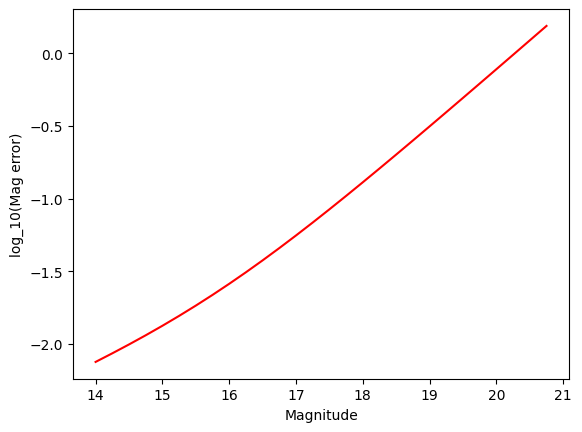

In [35]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [36]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [37]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [38]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated ZTF events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [39]:
def simulate_lco_observations(ztf_event, ztf_model, ztf_model_params, event_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    # Take a back-up copy of the original event object, since if no LCO observations are possible, 
    # this will be returned unchanged:
    original_event = copy.deepcopy(ztf_event)
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    ztf_lc = ztf_lens.telescopes[0].lightcurve_magnitude
    if len(ztf_lc) == 0:
        return original_event
    
    mag_threshold = 17.5
    bright_data = np.where(ztf_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(ztf_lc[:,1].min())+' no LCO observations')
        return original_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = ztf_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = ztf_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(ztf_event.ra, ztf_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = ztf_lc[:,0].min()
    end_jd = ztf_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (ztf_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = ztf_lc[idx,0].min()
            pre_peak_end = ztf_lc[idx,0].max()
            cadence = 8.0/24.0 # days - once per site
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = ztf_lc[:,0].min()
            pre_peak_end = ztf_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = ztf_lc[idx,0].min()
            post_peak_end = ztf_lc[idx,0].max()
            cadence = 8.0/24.0 # days - once per site
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = ztf_lc[:,0].max()
            post_peak_end = ztf_lc[:,0].max()
            
        # Peak observations
        if event_params['binary_lens'] == 1:
            cadence = 1.0/24.0 # Monitor hourly
        else:
            cadence = 2.0/24.0 # Monitor single lenses every 2hrs
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        # Binary lens events only
        # Make additional high cadence observations of two simulated caustic crossing events, 
        # each of which lasts 6hrs
        if event_params['binary_lens'] == 1:
            cadence = 15.0/(60.0*24.0) # Observe every 15mins
            caustic1 = np.arange(pre_peak_end, (pre_peak_end+(6.0/24.0)), cadence)
            caustic2 = np.arange(post_peak_start, (post_peak_start+(6.0/24.0)), cadence)
            ts4 = np.concatenate((caustic1, caustic2))
        else:
            ts4 = np.array([])
        
        ts = np.concatenate((ts1,ts2,ts3,ts4))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return original_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for ZTF
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(ztf_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    ztf_event.telescopes.append(tel)
    
    if parallax:
        ztf_model.event.compute_parallax_all_telescopes(ztf_model.parallax_model)
        
    #tel = ztf_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = ztf_model.compute_pyLIMA_parameters(ztf_model_params)
    magnification = ztf_model.model_magnification(tel, pylima_parameters)
    A = ztf_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)[0]
    lc = np.delete(lc, idx, axis=0)
    
    if len(lc) == 0:
        print('Event remains too faint for LCO observations even when magnified')
        return original_event
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    ztf_event.telescopes[1] = tel
    
    return ztf_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [40]:
ztf_lens = sim_ztf_lenses[event_number]
ztf_lens_model = sim_ztf_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_ztf_event = simulate_lco_observations(ztf_lens, ztf_lens_model, lens_model_pars, events_table[event_number], visibility_data)

Event model parameters:  2460505.72732406 0.1471076161358919 103.79735233074895 0.023208692567800164 -0.6835642699913511 -0.29413145352027203
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID     HP                               location                              baseline_mag        t0                u0                 te                 rho                  piEN                piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------------ ------------ ---------------- ------------------ ------------------ -------------------- ------------------- -------------------- ------- ----------- --------- --------- ---------
ZTFSim00001 14420 <SkyCoord (ICRS): (ra, dec) in deg\n    (298.828125, 24.62431667)>       14.215 2460505.72732406 0.1471076161358919 103.79735233074895 0.023208692567800164 -0.6835642699913511 -0.29413145352027203     0.0           1       781      1336       228


Text(0.5, 1.0, 'Simulated event ZTFSim00001')

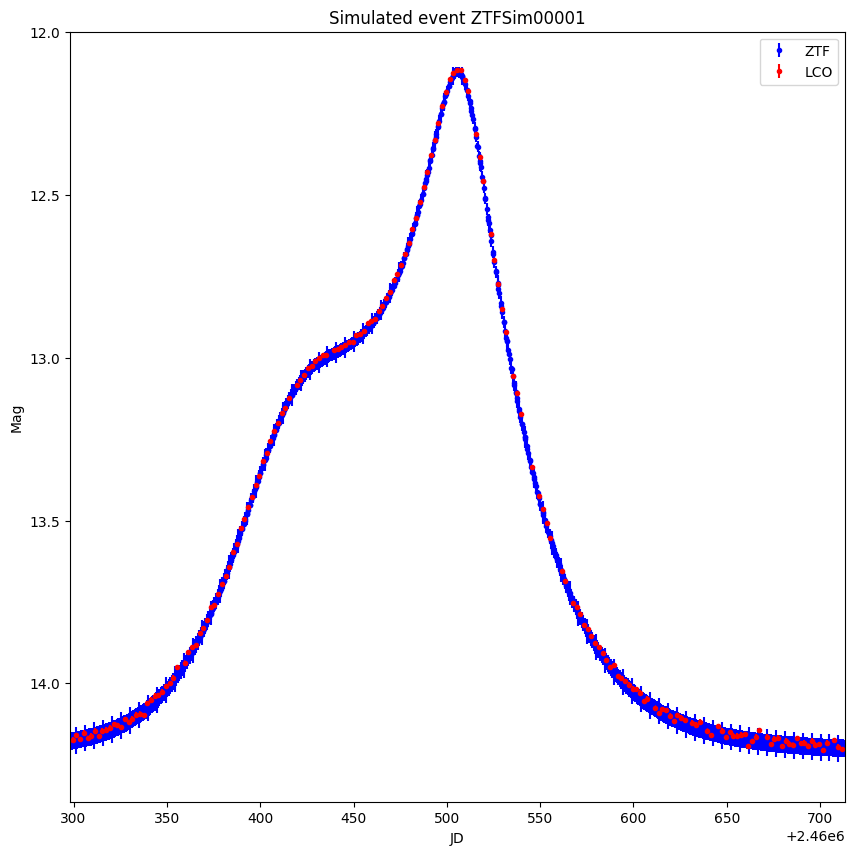

In [41]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_ztf_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='ZTF', fmt='b.')
lc2 = updated_ztf_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated ZTF events

In [42]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_ztf_event = simulate_lco_observations(sim_ztf_lenses[ievent], 
                                                   sim_ztf_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_ztf_event)

Event model parameters:  2460505.72732406 0.1471076161358919 103.79735233074895 0.023208692567800164 -0.6835642699913511 -0.29413145352027203
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460281.442406824 0.38019534669362437 13.853976375404276 0.019597589862885838 -0.36727499298330796 0.13247367239570526
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460946.2625300405 -0.5074136375262424 15.483811510952336 0.017264314426881075 -0.47007378988928866 0.48189056553474274
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460487.9547006306 -0.09993750953965011 7.520219559928271 0.007908350779742496 -0.08803140927946163 0.0002727903083619629
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460275.4567663763 0.08596441722885131 21.234373747920657 0.016479186175325913 1.3205762106130228 -0.09221053653348107
Parallax(Full) estimated for the telescope LCO: SUCCES

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460347.0602342975 0.33394711788628806 18.584154495965173 0.011882453676705172 -1.0939792167932763 0.23569553455223038
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460425.857367224 0.10534475457089569 23.225191370924975 0.01689078334143731 -0.7135804169572757 0.22713118480553413
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460374.2555041085 0.5458638996069616 42.067634163058685 0.0027421562965780077 -0.15421448003300553 -0.07951583316562164
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460647.827358149 -0.11631813721300036 15.433689478793424 0.024290186586161097 0.7997270249999779 0.24676481783571105
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460509.9284162372 -0.5625634666726269 41.895824199895124 0.008600265993531179 -0.17652325930784574 -0.32675146984773024

Event model parameters:  2461119.2203981434 -0.30542043352912585 17.80712128345321 0.014089871090210815 0.31020683491410717 -0.0966977621877737
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461173.2295727073 0.4814260718042306 23.70967334076921 0.019019381563738776 -0.7208855550384372 -0.01614998690733381
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460834.7351360694 -0.24714493137236523 17.4155674184806 0.010363443348896332 -0.13020941166218603 -0.03815820330973151
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460843.8527516397 0.02392915604231763 61.74788289863618 0.024719182043582685 0.49626482576905084 -0.46886390743749057
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460174.8897612547 0.031177797286261327 48.41119509587985 0.004607597160036717 -0.37695875489753133 -0.21684887594345822
Parallax(Full) estimated for the telescope LCO: SUCCES

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460710.2602706887 0.591970197909362 93.17435909640113 0.004937423175591927 1.1428165118827156 -0.21097979730274632
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460615.1984604667 -0.012913212025284226 43.21580709584994 0.026696269766528113 -0.2046463838035722 0.0009727634784087516
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460686.154709243 0.44672487941268924 9.422803087709022 0.022679552556443792 -0.19481553436241605 0.01749024765418649
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460193.2876725104 0.3180054811033203 27.42013790884809 0.0028754661320280813 -1.1447118427103473 0.0223564170963588
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461169.0221768445 -0.22958336367658147 22.958645215233826 0.004171017342616885 0.9155155146068092 -0.1532150362743355
Par

Event model parameters:  2460515.35643298 0.574353747948535 39.741149582257755 0.023280749038824766 0.02982077756697571 0.0924347867958126
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460882.373848168 0.19892983099457973 22.93482340438026 0.0005721096167801507 0.8174711062605655 -0.07055945379905598
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460970.150696782 0.11583372883057719 16.443574195398103 0.00012726971658967925 -0.8448858851085759 -0.4019250129290814
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460660.7807330494 0.052601072808716884 15.94055493036023 0.029610070631793654 -0.18018139108715497 -0.3123258779998508
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461050.1564417905 0.0678283553682073 27.22472083870884 0.008390696712702128 -0.8123330575906107 0.22279123026218842
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460205.0539990915 0.04285295486907302 17.278128475573183 0.010032270524991012 -1.5507080641247246 -0.415014618444327
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460268.3387639993 0.4709931805017804 48.183592189935055 0.002621218302521433 0.544336007364193 -0.07415696337916189
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460493.3932334716 -0.020662291374336922 33.74185225560609 0.0169542425620212 -0.02713343981596028 0.39255982974925263
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460715.6583155906 0.017717732506856376 39.65437781180621 0.0017187467482937917 0.3945131983352581 0.03869482796558003
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460454.461243991 0.08986998853778198 26.445586902091897 0.001620421341948169 -0.43341758948057457 -0.026835567508912313
P

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460892.2118518814 0.4635438514329656 3.852447305420402 0.0011409453656907043 -0.47106601266132325 0.006553743861638567
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460359.0464486997 -0.1783291433889521 45.34727120527766 0.013982726692327961 1.1385619606861896 0.5079506982873288
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460973.4585230625 -0.104618964588262 9.090918612275695 0.005264309875782503 0.6734058824289886 -0.0670304855307498
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460740.0791860074 0.42869760062921247 23.086879554593125 0.011915610805519445 0.2040468676065659 0.0310580589170702
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460399.8691542973 0.2366728542163321 40.18917225058888 0.010146998441036613 1.3126820554283232 -0.10012261539665318
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461030.555844616 0.2012291285003196 3.846677686552961 0.012166550359421466 0.028664250032657212 -0.14351873558496892
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461110.9573021047 0.20792820516846428 10.230505452186964 0.006215309631124748 -1.0464756760164649 0.30042003875606677
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460719.4900579974 0.4327012915328249 8.27900091293642 0.00847946401307104 0.26589809458837005 -0.12700648260275732
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460720.90976355 0.0805333729918013 42.43505126404853 0.011850359841912989 0.15712907915665086 -0.08329699657489714
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460884.6919107554 0.07851952658455884 40.81122596478289 0.020491150867755957 -0.10063135729576278 -0.000628820763834588
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460281.7328366665 0.11065769888922808 35.28005077997877 0.001971023549160473 0.6420930460182666 -0.4794380265674341
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460334.3471093476 0.7882543899131966 91.78754904999366 0.016032072378552975 1.9992635356650257 0.15534140013552675
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460193.8834179672 0.6826585219249699 19.468407223811255 0.028764033411341892 0.1815841619329467 -0.5487960990179088
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460636.6895817462 -0.07281615105523373 18.327676379763716 0.0022805072385538305 0.4871702619342901 0.14740623273927128
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460737.6366271162 -0.15656895448450156 24.620849291924504 0.025720260585736503 0.2336653410794758 -0.30825063758154914
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460396.7037994247 0.16767035481706918 20.606151415854445 0.029243882291343705 -0.9156631952577299 -0.04497548663820022
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461188.156930901 0.03242527897164196 23.398341727506615 0.012908840943505494 0.8326412495805788 -0.06332916333037436
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460190.9557961673 0.29911127425019346 12.120265504248552 0.01357917858183007 -0.21222402432316623 0.3717730941342271
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460277.7140795183 0.41383797044152304 30.026272950655414 0.011938239245672663 0.585942963250899 0.2764094140555168
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460609.5298362626 0.9102403135201819 49.507939131980905 0.023381375074515796 -0.4253008248285099 0.3085317595302101
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.583561361 0.1043942081532771 52.83967493611658 0.024133231160167697 1.8411152432348707 0.12798742482222497
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460927.911410362 -0.11282367280060682 31.106967292144716 0.019537392725265314 0.4394921824332214 -0.21251675794843886
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460389.1400588867 0.43048702210518464 17.27307119052459 0.00823063117614888 -0.06438393074912191 0.01166888163462363
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460489.4830381717 -0.5413406328721319 27.24215586981919 0.002065995572879566 0.04883540506509866 0.1222961694993383
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460553.4293487296 -0.027470322403640557 13.113566762679275 0.023642473715063655 0.5157623894699749 0.31636187179204206
Parall

Event model parameters:  2460520.3616086035 0.7783772172927099 44.14953208376717 0.018094968127625944 -0.5690520229466622 -0.10798767993478986
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460229.4222583035 -0.0644652286964611 53.33434715289649 0.007127471665141731 -1.112038459328075 0.13664827879504984
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460372.1550977086 0.21854713621236338 38.85227999572095 0.006107382632244012 0.7313104245495965 0.261512639153222
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461089.4688216485 0.4351870424242249 9.714193014127694 0.010633664704730721 -0.6241293092882687 0.008248498504608695
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461092.4445325155 0.31935851556388556 35.83312168494887 0.020133485548609397 0.1025444247057829 -0.08664297378366448
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mod

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460782.944639979 0.4422419196969175 132.46797627899923 0.005900059412861217 -0.8611463472738208 -0.08139005300298013
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460258.9152592956 -0.022949964281858554 68.2218647795105 0.004779440759122695 1.0482357107099132 -0.12442254819169629
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461025.6649641097 0.4033188038911527 22.078451396978615 0.023238270669036915 1.0500114999580936 0.2378118699711766
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461110.32109038 0.29822031090129264 84.8422864727628 5.07385748168554e-05 -0.6058109344471796 -0.09919547412990107
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460422.289953568 0.2864479631745324 15.200704171581114 0.013511616312411968 -1.1206053337683304 -0.09604202493817438
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461050.0622473974 0.6223347302878579 28.336665351465818 0.013864815247779508 0.6879174382071602 -0.08506044483339448
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460867.0504923216 -0.37533693931074397 78.61188250505757 0.004847100064797664 0.29011125811425076 0.06041410907389289
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461096.715767048 0.3248415790436216 55.997873123531186 0.013712639125221873 -0.41275563587570546 -0.06513918562264881
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460544.0131257 -0.16914899942536996 10.28809372463748 0.014310696763040623 0.09263847095299768 0.17365075374862038
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460748.9646225786 0.26903176473559665 36.04285955586799 0.007015450255605252 0.42593122411972856 0.23007066446293384
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461125.321838251 0.20908041887158363 4.778958840639805 0.01284443851384156 2.340830518795408 -0.274926184971681
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460303.6006796695 0.11592231356983189 11.772213797405554 0.011298586616540178 -0.9431470920477147 -0.08225728874068969
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461104.055091805 0.4062818190502129 101.42897673668301 0.022592064456008698 -0.8548736871366844 -0.5014712661640722
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461131.1108988444 0.42986693402165665 151.00730035256012 0.03445510149566049 -0.7161966030773796 -0.35424517341199085
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460405.4258894837 0.1157813381669357 22.05925158164109 0.01595429598417154 1.041410778507742 0.07398766597928653
Parallax(Ful

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460771.6866056146 0.16748395645515798 5.377543842887542 0.018203528107377586 0.13072073190000155 -0.13939469919161276
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460328.8854697263 -0.11845626949010848 48.63855488646588 0.023714770398682618 -0.49510646257879026 -0.3120097358899149
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460421.936120948 0.0666096669782875 9.956055678699679 0.013948115888380234 1.189048018006383 -0.14514912898432075
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460745.1724478547 0.11828444610293601 30.57914305325259 0.029136118852713243 -1.0319529159228853 -0.47100955461444366
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460176.1056124046 0.3311653031771501 15.302423079325884 0.008748812390736565 -1.2300433734912677 0.02478282563746814
Para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460924.6546530924 0.5410529803685009 28.036670868392108 0.012609123644215885 -1.3549621812935537 0.1326977798320487
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460817.3364067855 0.21919843005502765 3.0196050551724958 0.002262098564461465 0.948000591566315 -0.32175454283834976
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460848.0150454342 0.13952576933036548 7.761741888524935 0.04490339444514548 0.7879846654000411 0.4309559240040681
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460168.5861928994 0.5003450917448803 30.61372224197328 0.007898164120703098 -0.08172550754190738 0.03837283996265111
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460645.752101179 0.04164604377460686 14.288743743197621 0.021208570312205008 -0.3251614534266014 -0.12339197466729554
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460811.1011590823 0.14398834505865002 24.806302657779103 0.02570484770019557 0.5280107169968103 0.13145730485128818
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460818.366376049 -0.2240940598793623 22.016464157568283 0.01442844133977359 -0.24651672838059374 -0.09630416727872232
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460206.0715693627 -0.1772638262046725 183.68822209386187 0.027332530458230087 0.1826264231861373 0.36321193518087774
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460243.121929572 0.005053072096502825 30.294111218767835 0.003045332174399738 0.3819409347451507 0.12037617381533824
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460678.9362285775 -0.43341341575780234 3.7435756138017773 0.0004250380325925042 0.8863384477228842 -0.0009926865673395568


Event model parameters:  2460846.9163841116 0.08124177176344073 26.278019930177514 0.013572403914827193 -0.39539683514115015 0.3788095487804469
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460435.1889488483 0.39202313109089937 26.697843114052684 0.008326801627782555 -0.5158689303293702 0.1774897919228231
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460391.8553855186 0.4911821109750324 8.454091046800887 0.0065654574545612 0.30916890239121253 0.2868972054074611
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461190.4669913007 0.30881971839621725 15.19024801718998 0.02063498793609246 -0.09080470046679107 0.6860787025106267
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461004.1776050557 0.23673208734573337 11.205473656992293 0.0037443896295731747 0.12449692771788104 0.14963733666303813
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event m

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460909.5938251237 -0.3728528150393703 8.850677134043833 0.02152107754783553 0.08139605473864618 -0.09486371053525891
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460325.559009 0.4312140707764517 48.7673275078585 0.0034549616056520505 0.023381635285447455 0.29972747516995496
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460253.5773657854 -0.13004723026833173 40.013055385180394 0.01997884344648479 -0.06508993860393747 -0.058955099570105106
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461088.807940034 -0.3082429597820254 15.758840460124203 0.008209174900323767 -0.6844535809973613 0.4005606183734019
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460653.2485415083 0.5705389293076911 72.86892536626412 0.0006142674856048089 2.013733480179105 0.5497509566014076
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461097.073469861 -0.07097304428927231 15.170114728473925 0.014681228206933617 -0.6697835235031337 -0.23955475794102224
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460591.634683425 -0.21964647446212274 44.52234147523735 0.021178159085224448 0.6211756618938713 -0.0067551685843900144
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460865.7431720886 0.19203529774262112 52.51515237040884 0.011371932447541864 0.7101218483850631 0.2799970578994663
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460951.163092038 -0.1531658333074463 92.4326201796566 0.018313501242963905 -0.08567968443916804 -0.008620364017607622
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461115.351714455 0.7754333774608256 98.74358783271745 0.023524315635376287 -1.6759833808171505 0.2546516052425434
Paral

Event model parameters:  2460229.320804321 0.7769779922922988 44.59401892995578 0.018445059761858763 -0.1371975575836068 0.40496187666873923
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461242.0936667877 -0.010965130340909457 21.664016533969793 0.0074583279587454344 0.43440731696606516 0.34784183983692074
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460521.7844494446 -0.2765729626795024 19.006734666505757 0.004123153359929524 1.3105043071500104 0.18326779806223087
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460910.6727498705 0.12502452150946144 22.898286810306352 0.005005925473905283 0.7079160913823479 -0.08919047861581014
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460211.207402992 0.0666952874291278 47.47570055514952 0.003034384018916163 -0.22335122438667304 -0.19290125789682702
Parallax(Full) estimated for the telescope LCO: SUCCESS
Ev

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460748.5976196057 0.14226210769815736 6.433466194502266 0.007106778523172763 0.787545371493509 -0.364960314394568
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461246.210208312 0.3725431437033121 82.81580257775305 0.009048703966825665 -0.45722371765363506 -0.07591894759575324
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460414.3758548484 0.7151123593156126 32.693019479936424 0.01656990172702847 0.8278657395702644 -0.10702046333757748
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2461165.432113969 -0.049470886210084025 33.81930488471133 0.012559889583677819 2.4221500973149324 0.12688546158561004
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.0302818585 0.37676173173247995 17.44045768067642 0.00991757659083356 -0.36206406216221226 -0.48906150138667775
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460980.4597891765 0.08440060263019958 27.47258973867006 0.012476760025756348 0.45252043319741747 0.08131418141254598
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460383.705714838 0.6326164097315695 33.85524342614431 0.008630118194974655 0.28785225134238124 0.08999284043178454
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460192.724718097 0.3892447364222887 20.98418904016977 0.024666946314664415 0.3800157365200193 0.22598619798120922
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460771.7647312977 0.006858419248605696 23.002466351794233 0.00045547917521164376 0.5652572649692273 -0.0702042134471558
Parallax(Full) estimated for the telescope LCO: SUCCESS


In [43]:
file_path = 'simulated_lco_lightcurves_ztf_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [44]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [45]:
def fit_event_model(event_params, model_type, ztf_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the ZTF lightcurve
    tel1 = telescopes.Telescope(name='ZTF', camera_filter='r',
                                     light_curve_magnitude=ztf_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('ZTF')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['ZTF', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [46]:
ztf_lc = updated_ztf_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_ztf_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, ztf_lc, lco_lc)

  EventID     HP                               location                              baseline_mag        t0                u0                 te                 rho                  piEN                piEE         nvisits binary_lens nvisits_g nvisits_r nvisits_i
----------- ----- ------------------------------------------------------------------ ------------ ---------------- ------------------ ------------------ -------------------- ------------------- -------------------- ------- ----------- --------- --------- ---------
ZTFSim00001 14420 <SkyCoord (ICRS): (ra, dec) in deg\n    (298.828125, 24.62431667)>       14.215 2460505.72732406 0.1471076161358919 103.79735233074895 0.023208692567800164 -0.6835642699913511 -0.29413145352027203     0.0           1       781      1336       228
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00001, wit

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [47]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        ztf_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, ztf_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 3
No LCO lightcurve so not fitted

Modeling event 1 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00002, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 69.5131
DE converge to objective function : f(x) =  69.48633257000981
DE converge to parameters : =  ['2460281.442706824' '0.3804953466936244' '13.854276375404275'
 '0.019297589862885836' '-0.367574992983308' '0.13277367239570526']
trust_region_reflective  : TRF fit SUCCESS
[2460281.442706822, 0.38049534669362434, 13.854276375404273, 0.01929758986288584, -0.36757499298330665, 0.13277367239570523, 472412.5341852606, -351.42964659114136, 188894.22176738482, 1536.333903483334, 69.48633263855368]
differential_evolution  : Differential evolution fit S

differential_evolution step 1: f(x)= 253.635
DE converge to objective function : f(x) =  253.60349223656783
DE converge to parameters : =  ['2460322.0866210978' '-0.1736802565806833' '63.2435451779635'
 '0.0011994420786778674' '-0.9085760557609881' '0.20375807833464785']
trust_region_reflective  : TRF fit SUCCESS
[2460322.086398833, -0.1736802565811833, 63.243545184246734, 0.0011994420786778674, -0.9085760556666908, 0.20375807842761223, 118.45845256323099, 0.1238556501716232, 189206.43005316093, 132.822167484809, 253.61470583521412]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460322.086398833, -0.1736802565811833, 63.243545184246734, 0.0011994420786778674, -0.9085760556666908, 0.20375807842761223, 118.45845256323099, 0.1238556501716232, 189206.43005316093, 132.822167484809, 253.61470583521412]
t0: Fitted value=2460322.086398833+/-0.024871710576080727 expected value

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00010, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 539.434
differential_evolution step 2: f(x)= 539.434
differential_evolution step 3: f(x)= 539.434
differential_evolution step 4: f(x)= 539.434
differential_evolution step 5: f(x)= 539.434
differential_evolution step 6: f(x)= 539.434
differential_evolution step 7: f(x)= 539.434
differential_evolution step 8: f(x)= 539.434
differential_evolution step 9: f(x)= 539.434
differential_evolution step 10: f(x)= 539.423
DE converge to objective function : f(x) =  539.3242803848194
DE converge to parameters : =  ['2460232.087045246' '-0.06073835436423358' '86.75491101572179'
 '0.0028622992060742666' '-0.8371166203564033' '0.14759003393795211']
trust_region_reflective  : TRF fit SUCCESS
[2460232.087045251, -0.060743667587547304, 86.7

differential_evolution step 1: f(x)= 374.2
DE converge to objective function : f(x) =  373.8934256092137
DE converge to parameters : =  ['2460393.589690279' '-0.27200459509172964' '49.522094829345825'
 '0.025827850395469365' '-0.3173129234847452' '0.0933572978539922']
trust_region_reflective  : TRF fit SUCCESS
[2460393.589690331, -0.27200459509173314, 49.52209482934641, 0.025827850395466864, -0.31731292348475526, 0.09335729785400877, 297.60298960482805, 0.25505129797830667, 189051.3571477549, 359.07222769659137, 373.89344323872143]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460393.589690331, -0.27200459509173314, 49.52209482934641, 0.025827850395466864, -0.31731292348475526, 0.09335729785400877, 297.60298960482805, 0.25505129797830667, 189051.3571477549, 359.07222769659137, 373.89344323872143]
t0: Fitted value=2460393.589690331+/-0.007056209965025772 expected value=2460393.589990279
t0: delta=0.0002999482676386833 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00018, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 441.988
differential_evolution step 2: f(x)= 441.988
differential_evolution step 3: f(x)= 441.953
differential_evolution step 4: f(x)= 441.892
differential_evolution step 5: f(x)= 441.892
differential_evolution step 6: f(x)= 441.892
differential_evolution step 7: f(x)= 441.887
differential_evolution step 8: f(x)= 441.827
differential_evolution step 9: f(x)= 441.817
differential_evolution step 10: f(x)= 441.814
differential_evolution step 11: f(x)= 441.814
differential_evolution step 12: f(x)= 441.814
DE converge to objective function : f(x) =  441.65683965132774
DE converge to parameters : =  ['2460524.0654169526' '-0.04085895796030156' '48.803481173284126'
 '0.00936745906130065' '0.06211383427763959' '0.16318496659692297

differential_evolution step 1: f(x)= 263.409
DE converge to objective function : f(x) =  263.37272030921764
DE converge to parameters : =  ['2460545.2113971543' '-0.49881967968395585' '26.851584827198067'
 '0.020313838283099392' '0.3737821294949561' '0.06586201353708737']
trust_region_reflective  : TRF fit SUCCESS
[2460545.211397235, -0.498819679683963, 26.85158482719846, 0.02031383828309689, 0.37378212949497325, 0.0658620135370695, 747.671391121818, 0.5023102196326703, 189591.95321130793, -642.347699926963, 263.3727244688645]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460545.211397235, -0.498819679683963, 26.85158482719846, 0.02031383828309689, 0.37378212949497325, 0.0658620135370695, 747.671391121818, 0.5023102196326703, 189591.95321130793, -642.347699926963, 263.3727244688645]
t0: Fitted value=2460545.211397235+/-0.011005107766282161 expected value=2460545.211697154
t0: delta=0.00029991939663887024 prop_delta=1.2189

differential_evolution step 1: f(x)= 150.214
DE converge to objective function : f(x) =  150.20357103456305
DE converge to parameters : =  ['2460866.705259661' '-0.16405325748212116' '18.18965328444734'
 '0.0200011673817195' '0.6794354749769896' '0.44067289715861413']
trust_region_reflective  : TRF fit SUCCESS
[2460866.7052614903, -0.16403757999178667, 18.189653284447342, 0.019452841407692316, 0.6794327856562418, 0.4406822297335485, 118.5326495188184, 0.044753507515133475, 189149.87656885685, 366.7393588588823, 150.20295575109054]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460866.7052614903, -0.16403757999178667, 18.189653284447342, 0.019452841407692316, 0.6794327856562418, 0.4406822297335485, 118.5326495188184, 0.044753507515133475, 189149.87656885685, 366.7393588588823, 150.20295575109054]
t0: Fitted value=2460866.7052614903+/-0.001091370439275463 expected value=2460866.705559661
t0: delta=0.0002981708385050297 prop_

differential_evolution step 1: f(x)= 210.588
differential_evolution step 2: f(x)= 210.588
differential_evolution step 3: f(x)= 210.588
differential_evolution step 4: f(x)= 210.584
DE converge to objective function : f(x) =  210.4239802979631
DE converge to parameters : =  ['2460396.8212634115' '-0.08457474138325076' '26.899992426466692'
 '0.004518336951144484' '-0.1858910855386671' '-0.006417943198796549']
trust_region_reflective  : TRF fit SUCCESS
[2460396.821263412, -0.08456750526025505, 26.900056374029397, 0.004017539933110443, -0.1859106235678531, -0.006417943198796513, 118.56623047793, 0.0108348703961832, 189316.5406887448, 162.76197204497612, 210.41254492059625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460396.821263412, -0.08456750526025505, 26.900056374029397, 0.004017539933110443, -0.1859106235678531, -0.006417943198796513, 118.56623047793, 0.0108348703961832, 189316.5406887448, 162.76197204497612, 210.412544

differential_evolution step 1: f(x)= 356.352
differential_evolution step 2: f(x)= 356.352
DE converge to objective function : f(x) =  356.3201724457521
DE converge to parameters : =  ['2460483.184458531' '0.14721746429746754' '22.01662364642997'
 '0.004674590921636441' '-0.004129007012748853' '0.061263337834019195']
trust_region_reflective  : TRF fit SUCCESS
[2460483.184458563, 0.1472169462335483, 22.016627767653357, 0.004612793233876489, -0.004129007012748362, 0.061263337834019285, 118.60142988784965, -0.02496703639225612, 189350.86616436657, 375.52743956215687, 356.3201464481155]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460483.184458563, 0.1472169462335483, 22.016627767653357, 0.004612793233876489, -0.004129007012748362, 0.061263337834019285, 118.60142988784965, -0.02496703639225612, 189350.86616436657, 375.52743956215687, 356.3201464481155]
t0: Fitted value=2460483.184458563+/-0.0007924987610314004 expected value=

trust_region_reflective  : TRF fit SUCCESS
[2460526.3301925445, -0.20752049355246752, 11.19910964229097, 0.013791504582860527, 0.005646256671034027, 0.15623012724574412, 748.8161192869779, -0.6505172383123372, 189547.57913144847, -291.13560134112873, 100.01447345078286]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460526.3301925445, -0.20752049355246752, 11.19910964229097, 0.013791504582860527, 0.005646256671034027, 0.15623012724574412, 748.8161192869779, -0.6505172383123372, 189547.57913144847, -291.13560134112873, 100.01447345078286]
t0: Fitted value=2460526.3301925445+/-0.001185986269300052 expected value=2460526.330488483
t0: delta=0.0002959384582936764 prop_delta=1.2027445291956066e-08% within_range? True
te: Fitted value=11.19910964229097+/-0.1017251181733571 expected value=11.198809642290973
te: delta=0.00029999999999752447 prop_delta=0.002678856142572601% within_range? True
u0: Fitted value=-0.20752049355246752+/

differential_evolution step 1: f(x)= 770.91
differential_evolution step 2: f(x)= 770.91
differential_evolution step 3: f(x)= 770.91
DE converge to objective function : f(x) =  770.7998597935148
DE converge to parameters : =  ['2461241.066191803' '0.2462694786384895' '62.657377101037895'
 '0.023185529760526707' '0.73067572731639' '0.18146285861557213']
trust_region_reflective  : TRF fit SUCCESS
[2461241.0661918717, 0.24626947863848778, 62.657377101036495, 0.02318552976052777, 0.7306757273165131, 0.18146285861559683, 472573.6418409058, -517.9645948465676, 189622.1595662779, -213.84747977351628, 770.7998791753712]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461241.0661918717, 0.24626947863848778, 62.657377101036495, 0.02318552976052777, 0.7306757273165131, 0.18146285861559683, 472573.6418409058, -517.9645948465676, 189622.1595662779, -213.84747977351628, 770.7998791753712]
t0: Fitted value=2461241.0661918717+/-0.0084639707

differential_evolution step 1: f(x)= 75.2732
DE converge to objective function : f(x) =  75.24904152373128
DE converge to parameters : =  ['2460347.0605342975' '0.33364711788628804' '18.583854495965173'
 '0.012182453676705172' '-1.0942792167932762' '0.23599553455223038']
trust_region_reflective  : TRF fit SUCCESS
[2460347.0605340297, 0.3336471178864286, 18.58385449596518, 0.01218245367640134, -1.0942792167932374, 0.2359955345521901, 118.48423230330346, 0.09331555869910661, 189123.6611943909, 20.225227906489977, 75.24905932820744]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460347.0605340297, 0.3336471178864286, 18.58385449596518, 0.01218245367640134, -1.0942792167932374, 0.2359955345521901, 118.48423230330346, 0.09331555869910661, 189123.6611943909, 20.225227906489977, 75.24905932820744]
t0: Fitted value=2460347.0605340297+/-0.004794495273842676 expected value=2460347.0602342975
t0: delta=0.00029973220080137253 prop_del

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00050, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 364.939
DE converge to objective function : f(x) =  364.9019832574839
DE converge to parameters : =  ['2460509.9281162373' '-0.5622634666726269' '41.89552419989512'
 '0.008328575478990949' '-0.17682325930784573' '-0.3264514698477302']
trust_region_reflective  : TRF fit SUCCESS
[2460509.928201496, -0.5622634667296725, 41.895524203884044, 0.008445975766084204, -0.17682325929802248, -0.32645146985726414, 297.66102756432076, 0.19435665445241673, 189323.62348870342, 9.97383351754724, 364.9066867269047]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460509.928201496, -0.5622634667296725, 41.895524203884044, 0.008445975766084204, -0.17682325929802248, -0.32645146985

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00055, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 481.547
differential_evolution step 2: f(x)= 481.141
differential_evolution step 3: f(x)= 481.141
differential_evolution step 4: f(x)= 481.021
differential_evolution step 5: f(x)= 481.021
differential_evolution step 6: f(x)= 481.021
differential_evolution step 7: f(x)= 481.021
differential_evolution step 8: f(x)= 481.021
differential_evolution step 9: f(x)= 481.021
differential_evolution step 10: f(x)= 481.021
DE converge to objective function : f(x) =  480.8227715369644
DE converge to parameters : =  ['2460273.045963227' '0.00097664235170938' '123.50180778586406'
 '0.00750871286941063' '1.5009775560017509' '0.017640778276454116']
trust_region_reflective  : TRF fit SUCCESS
[2460273.0459632264, 0.0009765928939077715, 123.50193357895907, 0.007508711770153783, 1.5009775560017506,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00059, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 60.351
DE converge to objective function : f(x) =  60.273351161826206
DE converge to parameters : =  ['2461056.5968348593' '-0.21266556457018526' '12.761399341112927'
 '0.02936579009646935' '0.07251446890722066' '-0.40003098895042966']
trust_region_reflective  : TRF fit SUCCESS
[2461056.5968348696, -0.21266556457018512, 12.761399341112925, 0.029365790096469495, 0.07251446890722067, -0.4000309889503937, 118.69163385332504, -0.1155572210308791, 189708.49036828618, -854.6246112787121, 60.273352573210964]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461056.5968348696, -0.21266556457018512, 12.761399341112925, 0.029365790096469495, 0.07251446890722067, -0.400030

DE converge to objective function : f(x) =  57.830392662769746
DE converge to parameters : =  ['2461003.7801455003' '0.12127187671701836' '11.017067761278623'
 '0.028752048830161653' '2.386689969900914' '0.013705391829541216']
trust_region_reflective  : TRF fit SUCCESS
[2461003.780146163, 0.12126848951254564, 11.01706776106195, 0.02874972690382618, 2.386689969895379, 0.013705391826270587, 297.933127220321, -0.08148764502205862, 190007.16388849722, -1833.922947111782, 57.831356458456696]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461003.780146163, 0.12126848951254564, 11.01706776106195, 0.02874972690382618, 2.386689969895379, 0.013705391826270587, 297.933127220321, -0.08148764502205862, 190007.16388849722, -1833.922947111782, 57.831356458456696]
t0: Fitted value=2461003.780146163+/-0.007482069981742682 expected value=2461003.7804455003
t0: delta=0.00029933732002973557 prop_delta=1.2163220650378211e-08% within_range? Tru

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00067, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 217.435
DE converge to objective function : f(x) =  217.3119087155887
DE converge to parameters : =  ['2460303.2503219545' '0.2815406406672807' '34.69600794915482'
 '0.011139336834881003' '0.031160435737171067' '-0.2110845790700272']
trust_region_reflective  : TRF fit SUCCESS
[2460303.250322011, 0.28154064066728035, 34.69600794915479, 0.011139336834881323, 0.031160435737167053, -0.21108457907002995, 118.67810124843595, -0.10274626386733197, 189618.63311826347, -470.947543857349, 217.31191373548137]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460303.250322011, 0.28154064066728035, 34.69600794915479, 0.011139336834881323, 0.031160435737167053, -0.21108457907002995, 118.67810124843595, -0.10274626386733197, 189618

DE converge to objective function : f(x) =  220.55007994528125
DE converge to parameters : =  ['2460408.306994207' '-0.1421077828175268' '27.49204073124177'
 '0.0016174078882504029' '-0.5870677769563699' '0.1032080116710117']
trust_region_reflective  : TRF fit SUCCESS
[2460408.307128872, -0.14210642914548824, 27.49202948258344, 0.001620655306260411, -0.5870727074880947, 0.10318637867502299, 297.87285253993514, -0.021226215966908484, 189442.2039932121, 24.015852343842923, 220.53875745290037]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460408.307128872, -0.14210642914548824, 27.49202948258344, 0.001620655306260411, -0.5870727074880947, 0.10318637867502299, 297.87285253993514, -0.021226215966908484, 189442.2039932121, 24.015852343842923, 220.53875745290037]
t0: Fitted value=2460408.307128872+/-0.002492742282172358 expected value=2460408.3071521427
t0: delta=2.327095717191696e-05 prop_delta=9.458168834933123e-10% within_ran

differential_evolution step 1: f(x)= 217.877
DE converge to objective function : f(x) =  217.81295773283193
DE converge to parameters : =  ['2461151.438897653' '0.30384417451842166' '32.10183940732143'
 '0.006579922617389429' '-0.11841252738245209' '-0.2273486389105963']
trust_region_reflective  : TRF fit SUCCESS
[2461151.4388976325, 0.3038441745184222, 32.10183940732146, 0.006579922617389187, -0.1184125273824556, -0.22734863891059945, 747.5534380579493, 0.624535169118435, 189240.59286161984, -58.83032909169523, 217.81296029344114]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461151.4388976325, 0.3038441745184222, 32.10183940732146, 0.006579922617389187, -0.1184125273824556, -0.22734863891059945, 747.5534380579493, 0.624535169118435, 189240.59286161984, -58.83032909169523, 217.81296029344114]
t0: Fitted value=2461151.4388976325+/-0.004151940721387548 expected value=2461151.438597653
t0: delta=0.00029997946694493294 prop_

DE converge to objective function : f(x) =  37.50985828566632
DE converge to parameters : =  ['2461032.7902210522' '-0.021526593197264347' '16.875209762883625'
 '0.015631814651838567' '1.2488151569860024' '-0.01854616200623664']
trust_region_reflective  : TRF fit SUCCESS
[2461032.790221095, -0.021527588886887602, 16.875209760332222, 0.015634337448775338, 1.248815156980634, -0.01854616199192166, 118.602495948, -0.026075741501604164, 189049.0025175422, 202.65942267461816, 37.50985992577921]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461032.790221095, -0.021527588886887602, 16.875209760332222, 0.015634337448775338, 1.248815156980634, -0.01854616199192166, 118.602495948, -0.026075741501604164, 189049.0025175422, 202.65942267461816, 37.50985992577921]
t0: Fitted value=2461032.790221095+/-0.030658867193039736 expected value=2461032.790521052
t0: delta=0.00029995711520314217 prop_delta=1.2188261625706944e-08% within_range? Tr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00083, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 92.6607
DE converge to objective function : f(x) =  92.58146997575643
DE converge to parameters : =  ['2460209.366646277' '0.15466109788229368' '9.081224026134961'
 '0.024639735844704913' '-0.6512343715734354' '-0.4570568926404873']
trust_region_reflective  : TRF fit SUCCESS
[2460209.3666462773, 0.15466111869578703, 9.0812240261342, 0.0246397338873448, -0.6512343715734356, -0.4570568926404874, 471722.8479779297, 341.68798144790037, 189211.97719122283, 120.53380432115215, 92.5814721603093]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460209.3666462773, 0.15466111869578703, 9.0812240261342, 0.0246397338873448, -0.6512343715734356, -0.4570568926404874, 471722.

differential_evolution step 1: f(x)= 136.168
DE converge to objective function : f(x) =  136.13553757080115
DE converge to parameters : =  ['2460596.159041831' '-0.2583322613191334' '13.272314191678053'
 '0.014978778807330806' '-1.3661352095333201' '-0.13651233695604414']
trust_region_reflective  : TRF fit SUCCESS
[2460596.1590418313, -0.25833226131913334, 13.272314191678051, 0.014978778807330808, -1.3661352095333203, -0.13651233695604417, 118.68131292473782, -0.10509197815989033, 190096.2394395632, -1406.681139050953, 136.13553781527435]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460596.1590418313, -0.25833226131913334, 13.272314191678051, 0.014978778807330808, -1.3661352095333203, -0.13651233695604417, 118.68131292473782, -0.10509197815989033, 190096.2394395632, -1406.681139050953, 136.13553781527435]
t0: Fitted value=2460596.1590418313+/-0.0015420145904453946 expected value=2460596.1593418308
t0: delta=0.00029999949

differential_evolution step 1: f(x)= 296.754
DE converge to objective function : f(x) =  296.7292217458195
DE converge to parameters : =  ['2460834.7354360693' '-0.24731116501529538' '17.415867418480598'
 '0.010663260217860234' '-0.12990941166218603' '-0.03785820330973151']
trust_region_reflective  : TRF fit SUCCESS
[2460834.735435597, -0.24731099797990122, 17.415867418467467, 0.010660452094194426, -0.12990941166239445, -0.03785820330999683, 118.63161655206608, -0.05522065985695244, 189321.79825511615, 158.30812824895946, 296.72965369057886]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460834.735435597, -0.24731099797990122, 17.415867418467467, 0.010660452094194426, -0.12990941166239445, -0.03785820330999683, 118.63161655206608, -0.05522065985695244, 189321.79825511615, 158.30812824895946, 296.72965369057886]
t0: Fitted value=2460834.735435597+/-0.0015524919443114554 expected value=2460834.7351360694
t0: delta=0.00029952

DE converge to objective function : f(x) =  104.87832023568316
DE converge to parameters : =  ['2461035.04442477' '-0.20475438831796663' '17.167128348438524'
 '0.0012292207295335825' '0.2732867953183698' '0.32447991285869016']
trust_region_reflective  : TRF fit SUCCESS
[2461035.0444143275, -0.2047543564825603, 17.16712835015502, 0.0012292207295335825, 0.2732867954182584, 0.3244799129585733, 118.51347651976788, 0.06402959760887472, 188948.13225358247, 1031.0271371837775, 104.87832709379357]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461035.0444143275, -0.2047543564825603, 17.16712835015502, 0.0012292207295335825, 0.2732867954182584, 0.3244799129585733, 118.51347651976788, 0.06402959760887472, 188948.13225358247, 1031.0271371837775, 104.87832709379357]
t0: Fitted value=2461035.0444143275+/-0.001356157612724305 expected value=2461035.0443603797
t0: delta=5.394779145717621e-05 prop_delta=2.192077336761256e-09% within_range

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00098, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 485.286
DE converge to objective function : f(x) =  485.2366173804742
DE converge to parameters : =  ['2461216.531461643' '0.5858087886610186' '94.95613089303777'
 '0.0024169581248231174' '-0.41994749354984573' '-0.09346952819083265']
trust_region_reflective  : TRF fit SUCCESS
[2461216.53123309, 0.5858087886052895, 94.95613088356703, 0.0024169581248231174, -0.4199474935503457, -0.09346952818428937, 118.64219034798576, -0.06802751745621942, 189644.25391307723, -283.79664406547596, 485.2399637438869]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461216.53123309, 0.5858087886052895, 94.95613088356703, 0.0024169581248231174, -0.4199474935503457, -0.09346952818428937, 118.64219034798576, -0.06802751745621942, 189644.2

differential_evolution step 1: f(x)= 448.137
DE converge to objective function : f(x) =  448.06342713626424
DE converge to parameters : =  ['2460654.452259813' '0.49259200213093096' '102.27620572227173'
 '0.023502489991056256' '0.8233007093677762' '0.21773510269640137']
trust_region_reflective  : TRF fit SUCCESS
[2460654.4522598134, 0.492592002130931, 102.27620572227174, 0.023502489991056252, 0.8233007093677761, 0.2177351026964014, 118.5009135760585, 0.07963188067548332, 188601.78390541326, 865.9451690177177, 448.06342714321937]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460654.4522598134, 0.492592002130931, 102.27620572227174, 0.023502489991056252, 0.8233007093677761, 0.2177351026964014, 118.5009135760585, 0.07963188067548332, 188601.78390541326, 865.9451690177177, 448.06342714321937]
t0: Fitted value=2460654.4522598134+/-0.12481972999360674 expected value=2460654.452559813
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 1: f(x)= 333.308
DE converge to objective function : f(x) =  333.08112921896526
DE converge to parameters : =  ['2460506.0279265563' '0.303652038324854' '37.89985049603816'
 '0.01297816190821915' '0.2146908453942404' '0.0268276812733072']
trust_region_reflective  : TRF fit SUCCESS
[2460506.0279265568, 0.30365203832485393, 37.899850496038155, 0.012978161908219151, 0.21469084539424038, 0.026827681273307202, 118.67361354647382, -0.09860358073440517, 189618.36136835362, -471.1776811201434, 333.0811293974569]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460506.0279265568, 0.30365203832485393, 37.899850496038155, 0.012978161908219151, 0.21469084539424038, 0.026827681273307202, 118.67361354647382, -0.09860358073440517, 189618.36136835362, -471.1776811201434, 333.0811293974569]
t0: Fitted value=2460506.0279265568+/-0.005077225910167781 expected value=2460506.0282265563
t0: delta=0.00029999949038028717

differential_evolution step 1: f(x)= 164.442
differential_evolution step 2: f(x)= 164.442
differential_evolution step 3: f(x)= 164.439
differential_evolution step 4: f(x)= 164.426
DE converge to objective function : f(x) =  164.35158563615147
DE converge to parameters : =  ['2460740.463252881' '0.13006561408353995' '28.740154263682033'
 '0.01317165774601109' '0.5251679399478885' '-0.3484994210701276']
trust_region_reflective  : TRF fit SUCCESS
[2460740.463252877, 0.13006901326868966, 28.739567101820665, 0.01322932293703969, 0.5251679399478882, -0.3484994210701268, 298.1979511223328, -0.35337190292598153, 189891.62271780946, -1256.7393168731203, 164.35138524505876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460740.463252877, 0.13006901326868966, 28.739567101820665, 0.01322932293703969, 0.5251679399478882, -0.3484994210701268, 298.1979511223328, -0.35337190292598153, 189891.62271780946, -1256.7393168731203, 164.351385245

differential_evolution step 1: f(x)= 226.08
DE converge to objective function : f(x) =  226.05632037321908
DE converge to parameters : =  ['2460716.23755421' '0.1908483885700812' '36.87248119109563'
 '0.006591844325066705' '1.28005854452389' '-0.20737948442076998']
trust_region_reflective  : TRF fit SUCCESS
[2460716.2375542084, 0.19084838951673855, 36.872481191096796, 0.006591844325062569, 1.2800580068087262, -0.20737948442012744, 118.6500132020314, -0.0742728655824466, 189638.36238651752, -684.0656834852732, 226.0563207227034]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460716.2375542084, 0.19084838951673855, 36.872481191096796, 0.006591844325062569, 1.2800580068087262, -0.20737948442012744, 118.6500132020314, -0.0742728655824466, 189638.36238651752, -684.0656834852732, 226.0563207227034]
t0: Fitted value=2460716.2375542084+/-0.003651174178442689 expected value=2460716.23725421
t0: delta=0.00029999855905771255 prop_del

differential_evolution step 1: f(x)= 320.866
DE converge to objective function : f(x) =  320.81790278455156
DE converge to parameters : =  ['2460722.007536934' '0.6243888359576943' '44.09107277176844'
 '0.018068487462221554' '2.3482094479216586' '0.17331059636972287']
trust_region_reflective  : TRF fit SUCCESS
[2460722.0075369338, 0.6243888359576942, 44.09107277176843, 0.01806848746222159, 2.348209447921659, 0.17331059636972285, 118.65539569585813, -0.0789200860368562, 189626.29243344787, -291.50358585404473, 320.81790279504537]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460722.0075369338, 0.6243888359576942, 44.09107277176843, 0.01806848746222159, 2.348209447921659, 0.17331059636972285, 118.65539569585813, -0.0789200860368562, 189626.29243344787, -291.50358585404473, 320.81790279504537]
t0: Fitted value=2460722.0075369338+/-0.04895633999215478 expected value=2460722.0072369343
t0: delta=0.00029999949038028717 prop_del

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00122, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 196.725
DE converge to objective function : f(x) =  196.7158204839471
DE converge to parameters : =  ['2460485.378987976' '0.2674275582872002' '25.054921372580765'
 '0.017923699304324275' '0.20324430245434807' '-0.33862866014178283']
trust_region_reflective  : TRF fit SUCCESS
[2460485.378987981, 0.26743433227088736, 25.054921372581255, 0.01828858130666025, 0.20324430245434802, -0.33862866014178306, 748.6813720224727, -0.5173370351998036, 189598.08191976752, -327.4993337999192, 196.71592235212046]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460485.378987981, 0.26743433227088736, 25.054921372581255, 0.01828858130666025, 0.20324430245434802, -0.33862866014178306, 748.6813720224727, -0.5173370351998036, 189598.0819

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00126, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 190.691
DE converge to objective function : f(x) =  190.6610809757881
DE converge to parameters : =  ['2460993.7151040477' '0.4485964053057569' '31.568162632080114'
 '0.0019611174773172253' '0.1377079505849613' '0.05268747653625771']
trust_region_reflective  : TRF fit SUCCESS
[2460993.7150477534, 0.44859640537721385, 31.568162635186876, 0.0019611174773172253, 0.1377079506400413, 0.05268747653625991, 187799.22822127744, 133.89377585549477, 188939.6440852313, 373.01085332645295, 190.66527093674154]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460993.7150477534, 0.44859640537721385, 31.568162635186876, 0.0019611174773172253, 0.1377079506400413, 0.0526874765362

differential_evolution step 1: f(x)= 409.22
differential_evolution step 2: f(x)= 403.658
differential_evolution step 3: f(x)= 403.658
differential_evolution step 4: f(x)= 403.658
differential_evolution step 5: f(x)= 399.082
differential_evolution step 6: f(x)= 398.314
differential_evolution step 7: f(x)= 398.314
differential_evolution step 8: f(x)= 398.314
differential_evolution step 9: f(x)= 398.314
differential_evolution step 10: f(x)= 398.314
differential_evolution step 11: f(x)= 398.314
differential_evolution step 12: f(x)= 398.072
differential_evolution step 13: f(x)= 398.072
differential_evolution step 14: f(x)= 398.072
differential_evolution step 15: f(x)= 397.932
differential_evolution step 16: f(x)= 397.932
differential_evolution step 17: f(x)= 397.629
differential_evolution step 18: f(x)= 397.629
differential_evolution step 19: f(x)= 397.629
differential_evolution step 20: f(x)= 397.629
differential_evolution step 21: f(x)= 397.629
differential_evolution step 22: f(x)= 397.60

differential_evolution step 1: f(x)= 43.0687
DE converge to objective function : f(x) =  43.05952225160079
DE converge to parameters : =  ['2460686.155009243' '0.44702487941268926' '9.423103087709022'
 '0.02237955255644379' '-0.19451553436241606' '0.017790247654186492']
trust_region_reflective  : TRF fit SUCCESS
[2460686.1550092427, 0.4470248794126892, 9.42310308770902, 0.022379552556443794, -0.1945155343624161, 0.017790247654186478, 118.65870510742482, -0.08208916556638769, 189341.41637992297, -89.70796148120037, 43.0595223144764]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460686.1550092427, 0.4470248794126892, 9.42310308770902, 0.022379552556443794, -0.1945155343624161, 0.017790247654186478, 118.65870510742482, -0.08208916556638769, 189341.41637992297, -89.70796148120037, 43.0595223144764]
t0: Fitted value=2460686.1550092427+/-0.0038999226253505336 expected value=2460686.154709243
t0: delta=0.00029999949038028717 pro

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00137, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 225.111
DE converge to objective function : f(x) =  225.08770367793932
DE converge to parameters : =  ['2460438.1831041835' '0.5058635927655469' '21.786523323694702'
 '0.0027613135213039597' '-1.172061554878098' '0.4493244753878914']
trust_region_reflective  : TRF fit SUCCESS
[2460438.1832202943, 0.505863592765547, 21.786523325094418, 0.0027613135213039597, -1.1720615547843047, 0.44932447546685916, 118.49815566410123, 0.07916261428525448, 188650.0795709477, 1299.6655473454634, 225.09280028610743]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460438.1832202943, 0.505863592765547, 21.786523325094418, 0.00

differential_evolution step 1: f(x)= 133.55
differential_evolution step 2: f(x)= 133.55
differential_evolution step 3: f(x)= 133.421
differential_evolution step 4: f(x)= 133.421
differential_evolution step 5: f(x)= 133.421
differential_evolution step 6: f(x)= 133.421
differential_evolution step 7: f(x)= 133.421
DE converge to objective function : f(x) =  133.3629457128381
DE converge to parameters : =  ['2460902.435976765' '-0.10004144181598236' '15.709436366389049'
 '0.009727750285509151' '-0.24982650288405786' '0.3908976917486465']
trust_region_reflective  : TRF fit SUCCESS
[2460902.4359042775, -0.10002855001460706, 15.709436299198233, 0.009728306887035982, -0.249826502784415, 0.3908976916490546, 298.08578493549123, -0.23677478574485408, 189683.65475636293, -815.744260288246, 133.69392791036222]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460902.4359042775, -0.10002855001460706, 15.709436299198233, 0.00972830688703598

differential_evolution step 1: f(x)= 489.417
DE converge to objective function : f(x) =  489.4102707445379
DE converge to parameters : =  ['2461243.191696495' '0.44353497784658424' '97.88852078504186'
 '0.007937293689243572' '0.4951663829492618' '-0.1816465948122237']
trust_region_reflective  : TRF fit SUCCESS
[2461243.1917015864, 0.4435338745824097, 97.88881124431286, 0.007997005060280863, 0.4951663829507614, -0.1816465948113913, 118.54959226107135, 0.025991049564579906, 188970.88948347225, 365.6131226716118, 489.41025569904934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461243.1917015864, 0.4435338745824097, 97.88881124431286, 0.007997005060280863, 0.4951663829507614, -0.1816465948113913, 118.54959226107135, 0.025991049564579906, 188970.88948347225, 365.6131226716118, 489.41025569904934]
t0: Fitted value=2461243.1917015864+/-0.3038402275338376 expected value=2461243.191996495
t0: delta=0.00029490841552615166 prop_del

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00149, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 529.52
differential_evolution step 2: f(x)= 529.52
differential_evolution step 3: f(x)= 529.442
differential_evolution step 4: f(x)= 529.442
differential_evolution step 5: f(x)= 529.337
differential_evolution step 6: f(x)= 529.337
DE converge to objective function : f(x) =  529.0908568038409
DE converge to parameters : =  ['2460822.4698679815' '0.11456950159231367' '68.09667512831918'
 '0.006165012884912733' '0.26181908019170974' '0.36101079754518395']
trust_region_reflective  : TRF fit SUCCESS
[2460822.469867982, 0.11457043200507021, 68.09665268350044, 0.0062165678511594885, 0.2618190801917098, 0.361010797545184, 297.72015083257133, 0.13919777675257433, 189153.09173388322, 651.6137040830193, 529.0975850675228]
differenti

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00153, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 157.762
DE converge to objective function : f(x) =  157.70286513788696
DE converge to parameters : =  ['2460941.408237334' '-0.3860323570799821' '8.896024203700351'
 '0.019391571024068827' '0.804454980024154' '0.4553524502554072']
trust_region_reflective  : TRF fit SUCCESS
[2460941.4082373334, -0.38603235707998207, 8.89602420370035, 0.01939157102406883, 0.8044549800241539, 0.45535245025540727, 118.659268913709, -0.08267086543664416, 189285.83253850357, 455.5764177635891, 157.70286531549337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460941.4082373334, -0.38603235707998207, 8.89602420370035, 0.01939157102406883, 0.8044549800241539, 0.45535245025540727, 118

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00157, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 511.026
differential_evolution step 2: f(x)= 511.026
differential_evolution step 3: f(x)= 510.736
differential_evolution step 4: f(x)= 510.706
differential_evolution step 5: f(x)= 510.706
differential_evolution step 6: f(x)= 510.706
differential_evolution step 7: f(x)= 510.706
differential_evolution step 8: f(x)= 510.706
differential_evolution step 9: f(x)= 510.706
differential_evolution step 10: f(x)= 510.706
differential_evolution step 11: f(x)= 510.706
differential_evolution step 12: f(x)= 510.706
differential_evolution step 13: f(x)= 510.706
differential_evolution step 14: f(x)= 510.706
differential_evolution step 15: f(x)= 510.706
DE converge to objective function : f(x) =  510.5268393178624
DE converge to parameters

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00161, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 115.387
DE converge to objective function : f(x) =  115.37562448991477
DE converge to parameters : =  ['2460875.2842879915' '0.5316396459318715' '12.742743753869256'
 '0.011539825468317912' '-0.6018215978791941' '0.19938708068209765']
trust_region_reflective  : TRF fit SUCCESS
[2460875.284288181, 0.5316396459318741, 12.74274375386985, 0.011539825468308588, -0.6018215978786908, 0.1993870806819978, 118.50071335583105, 0.07644048494819719, 188426.40644594183, 1700.0416904223873, 115.37564107133798]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460875.284288181, 0.5316396459318741, 12.74274375386985, 0.011539825468308588, -0.6018215978786908, 0.1993870806819978,

differential_evolution step 1: f(x)= 304.942
differential_evolution step 2: f(x)= 304.942
differential_evolution step 3: f(x)= 304.942
differential_evolution step 4: f(x)= 304.942
differential_evolution step 5: f(x)= 304.942
differential_evolution step 6: f(x)= 304.942
differential_evolution step 7: f(x)= 304.942
differential_evolution step 8: f(x)= 304.942
differential_evolution step 9: f(x)= 304.942
differential_evolution step 10: f(x)= 304.942
differential_evolution step 11: f(x)= 304.881
differential_evolution step 12: f(x)= 304.881
DE converge to objective function : f(x) =  304.43411093827876
DE converge to parameters : =  ['2460983.923754607' '0.02593787197423147' '40.3222184358541'
 '0.009538836463500865' '-1.1346765546038908' '-0.08717737951158913']
trust_region_reflective  : TRF fit SUCCESS
[2460983.9237546064, 0.025937638748701676, 40.32257278051181, 0.009538836463500866, -1.1346765546038906, -0.08717737951158912, 297.8173918205274, 0.035166881857655166, 189284.37224780474, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00169, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 264.024
differential_evolution step 2: f(x)= 264.022
DE converge to objective function : f(x) =  264.00739562733816
DE converge to parameters : =  ['2460937.278149029' '-0.13053717479861596' '27.211394115342674'
 '0.010811176846061088' '-0.224641672645033' '-0.08352213226102026']
trust_region_reflective  : TRF fit SUCCESS
[2460937.278156447, -0.13053296980463117, 27.211394115334823, 0.010609380111589902, -0.22464167264504012, -0.08352213226079928, 118.62188399606745, -0.0458758688789597, 189506.38636686376, -174.82505910144096, 264.00745517577786]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460937.278156447, -0.13053296980463117, 27.211394115334823, 0.0106

differential_evolution step 1: f(x)= 183.663
DE converge to objective function : f(x) =  183.63863970579786
DE converge to parameters : =  ['2460882.374148168' '0.19881956779325766' '22.93452340438026'
 '0.0005486744705877306' '0.8171711062605655' '-0.07025945379905599']
trust_region_reflective  : TRF fit SUCCESS
[2460882.3740042746, 0.1988276210235661, 22.93452340667065, 0.0005486744705877306, 0.8171711063520086, -0.07025945389739847, 118.53665210523188, 0.040852968761515694, 189399.51447569326, -75.65201978850511, 183.69311758688144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460882.3740042746, 0.1988276210235661, 22.93452340667065, 0.0005486744705877306, 0.8171711063520086, -0.07025945389739847, 118.53665210523188, 0.040852968761515694, 189399.51447569326, -75.65201978850511, 183.69311758688144]
t0: Fitted value=2460882.3740042746+/-0.0013790571025104616 expected value=2460882.373848168
t0: delta=0.00015610642731189

differential_evolution step 1: f(x)= 111.262
DE converge to objective function : f(x) =  111.25372635370793
DE converge to parameters : =  ['2460172.36716477' '-0.29405393943385505' '18.17206362115205'
 '0.017405002540137094' '-1.0913485891963413' '-0.44808317859706415']
trust_region_reflective  : TRF fit SUCCESS
[2460172.367164739, -0.29404999737271204, 18.172063622123662, 0.017112592173821006, -1.0913485891963384, -0.4480831785970728, 118.61801433070673, -0.04129156725560588, 189812.87013706664, -1025.5421902614737, 111.25370512142057]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.367164739, -0.29404999737271204, 18.172063622123662, 0.017112592173821006, -1.0913485891963384, -0.4480831785970728, 118.61801433070673, -0.04129156725560588, 189812.87013706664, -1025.5421902614737, 111.25370512142057]
t0: Fitted value=2460172.367164739+/-0.002507996696442299 expected value=2460172.36686477
t0: delta=0.0002999687567353

differential_evolution step 1: f(x)= 79.7989
differential_evolution step 2: f(x)= 79.7989
DE converge to objective function : f(x) =  79.76227399843997
DE converge to parameters : =  ['2461014.8358061346' '0.1840458404378759' '12.31388160180488'
 '0.001292838048929751' '-0.6154089437122456' '0.3476419329720421']
trust_region_reflective  : TRF fit SUCCESS
[2461014.8356061876, 0.18404584043787586, 12.313881600796854, 0.001292838148929751, -0.6154089436150092, 0.34764193306824287, 188121.35195904644, -191.07478976479683, 189916.79482647416, -756.4288762444362, 79.77452740101809]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461014.8356061876, 0.18404584043787586, 12.313881600796854, 0.001292838148929751, -0.6154089436150092, 0.34764193306824287, 188121.35195904644, -191.07478976479683, 189916.79482647416, -756.4288762444362, 79.77452740101809]
t0: Fitted value=2461014.8356061876+/-0.0014872387348101343 expected value=2461014

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00185, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 93.2475
DE converge to objective function : f(x) =  93.22986096937262
DE converge to parameters : =  ['2460163.242391212' '-0.3563181121078091' '13.723123521332282'
 '0.02076993496867589' '-0.21856661379832684' '-0.30396205572225815']
trust_region_reflective  : TRF fit SUCCESS
[2460163.2423912124, -0.3563181121074393, 13.723055079780972, 0.020634364911192735, -0.2185666137983268, -0.3039620557222582, 298.1035805986852, -0.25254532659250756, 189445.682321747, 291.8178622146785, 93.22982984236674]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460163.2423912124, -0.3563181121074393, 13.723055079780972, 0.020634364911192735, -0.2185666137983268, -0.3039620557222

differential_evolution step 1: f(x)= 410.741
DE converge to objective function : f(x) =  410.7154801314583
DE converge to parameters : =  ['2460214.622743953' '0.27803771578139325' '42.8066362359924'
 '0.021495609133198867' '0.4459537236172383' '-0.012160532431971105']
trust_region_reflective  : TRF fit SUCCESS
[2460214.622743952, 0.2780377044574475, 42.80663623599239, 0.021495378479592396, 0.44595372361723823, -0.012160532431971079, 118.67925889006892, -0.10374815841668492, 189595.47524194908, -473.3624250296177, 410.7154800739936]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460214.622743952, 0.2780377044574475, 42.80663623599239, 0.021495378479592396, 0.44595372361723823, -0.012160532431971079, 118.67925889006892, -0.10374815841668492, 189595.47524194908, -473.3624250296177, 410.7154800739936]
t0: Fitted value=2460214.622743952+/-0.0043271984164198266 expected value=2460214.622443953
t0: delta=0.00029999902471899986 p

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00193, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 594.972
differential_evolution step 2: f(x)= 594.972
differential_evolution step 3: f(x)= 594.972
DE converge to objective function : f(x) =  594.8157235590886
DE converge to parameters : =  ['2461208.632362484' '0.19291963807672796' '80.38456810557301'
 '0.010566816905132495' '-0.31064602436018407' '0.03296404025778513']
trust_region_reflective  : TRF fit SUCCESS
[2461208.6323624863, 0.19291963807672793, 80.38456810557294, 0.010566816905132611, -0.31064602436018324, 0.03296404025778606, 118.69981396456794, -0.12729416802593527, 189800.6322208799, -841.732938658358, 594.8157243720901]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461208.6323624863, 0.1929196

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00197, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 586.444
differential_evolution step 2: f(x)= 578.896
differential_evolution step 3: f(x)= 578.896
differential_evolution step 4: f(x)= 576.535
differential_evolution step 5: f(x)= 576.535
differential_evolution step 6: f(x)= 576.535
differential_evolution step 7: f(x)= 576.535
differential_evolution step 8: f(x)= 576.535
differential_evolution step 9: f(x)= 576.535
differential_evolution step 10: f(x)= 576.535
differential_evolution step 11: f(x)= 576.535
differential_evolution step 12: f(x)= 576.535
differential_evolution step 13: f(x)= 576.535
differential_evolution step 14: f(x)= 576.06
differential_evolution step 15: f(x)= 576.06
differential_evolution step 16: f(x)= 576.06
differential_evolution step 17: f(x)= 576.06
differential_evolution step 18: f(x)= 575.079
different

differential_evolution step 1: f(x)= 165.742
DE converge to objective function : f(x) =  165.6408721778935
DE converge to parameters : =  ['2460417.5534887435' '0.17600011382355274' '24.077875472682138'
 '0.019428793939339467' '-1.5392875271718547' '-0.34039749947002523']
trust_region_reflective  : TRF fit SUCCESS
[2460417.553488744, 0.17600011382355277, 24.07787547268214, 0.019428793939339464, -1.5392875271718545, -0.3403974994700252, 297.5280396231466, 0.32754684572160053, 188943.66427707436, 659.9189502832779, 165.64087226276837]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460417.553488744, 0.17600011382355277, 24.07787547268214, 0.019428793939339464, -1.5392875271718545, -0.3403974994700252, 297.5280396231466, 0.32754684572160053, 188943.66427707436, 659.9189502832779, 165.64087226276837]
t0: Fitted value=2460417.553488744+/-0.002018050752134067 expected value=2460417.5537887434
t0: delta=0.00029999949038028717 prop

differential_evolution step 1: f(x)= 517.016
DE converge to objective function : f(x) =  517.0094808883921
DE converge to parameters : =  ['2460962.382956544' '-0.16630058401105346' '58.85229872726831'
 '0.011924297516894779' '0.45459419490919817' '-0.33815363491351375']
trust_region_reflective  : TRF fit SUCCESS
[2460962.382992013, -0.1663037237641596, 58.852659367907805, 0.012171238300212592, 0.4545941949092007, -0.33814356017701946, 187994.73968070518, -66.11824042110588, 189446.57510075922, 53.81504308611163, 517.0089265222957]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460962.382992013, -0.1663037237641596, 58.852659367907805, 0.012171238300212592, 0.4545941949092007, -0.33814356017701946, 187994.73968070518, -66.11824042110588, 189446.57510075922, 53.81504308611163, 517.0089265222957]
t0: Fitted value=2460962.382992013+/-0.0030749548994154696 expected value=2460962.383256544
t0: delta=0.0002645310014486313 prop_d

differential_evolution step 1: f(x)= 146.884
differential_evolution step 2: f(x)= 146.884
differential_evolution step 3: f(x)= 146.858
differential_evolution step 4: f(x)= 146.84
differential_evolution step 5: f(x)= 146.84
DE converge to objective function : f(x) =  146.78014383851925
DE converge to parameters : =  ['2460227.699664816' '0.08897880703184032' '17.754359294204225'
 '0.003481287817942339' '0.5083539821185963' '0.3480934948397716']
trust_region_reflective  : TRF fit SUCCESS
[2460227.6996648153, 0.08897272222292157, 17.754774855638775, 0.0030572907162638428, 0.5083539821185964, 0.34809349483977153, 297.96225363855274, -0.11212891312665413, 189539.16868324045, -510.0156488225835, 146.77946600462224]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460227.6996648153, 0.08897272222292157, 17.754774855638775, 0.0030572907162638428, 0.5083539821185964, 0.34809349483977153, 297.96225363855274, -0.11212891312665413, 1895

differential_evolution step 1: f(x)= 190.436
DE converge to objective function : f(x) =  190.35689887676622
DE converge to parameters : =  ['2461005.640170569' '0.33338613670455924' '39.21876282659085'
 '0.0012319584720088383' '-0.4634224746279999' '-0.21493718870687006']
trust_region_reflective  : TRF fit SUCCESS
[2461005.64005994, 0.3333861367045592, 39.21876282318226, 0.0012319584720088383, -0.463422474611867, -0.21493718870202785, 118.66708184015371, -0.09173837817755781, 189562.32740398875, -252.51748804063072, 190.36405057786664]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461005.64005994, 0.3333861367045592, 39.21876282318226, 0.0012319584720088383, -0.463422474611867, -0.21493718870202785, 118.66708184015371, -0.09173837817755781, 189562.32740398875, -252.51748804063072, 190.36405057786664]
t0: Fitted value=2461005.64005994+/-0.009698426714094315 expected v

differential_evolution step 2: f(x)= 159.998
differential_evolution step 3: f(x)= 159.998
differential_evolution step 4: f(x)= 159.998
differential_evolution step 5: f(x)= 159.998
differential_evolution step 6: f(x)= 159.998
differential_evolution step 7: f(x)= 159.99
differential_evolution step 8: f(x)= 159.99
differential_evolution step 9: f(x)= 159.99
DE converge to objective function : f(x) =  159.964339258096
DE converge to parameters : =  ['2460205.0539440936' '0.042880339853591395' '17.277828475573184'
 '0.010067657843183638' '-1.5505876251485202' '-0.414714618444327']
trust_region_reflective  : TRF fit SUCCESS
[2460205.053944174, 0.04289282188975272, 17.277828475736733, 0.010276731418820285, -1.5506053761210423, -0.414714618446152, 118.60430876022087, -0.027761998055251917, 189484.50645755272, -206.4822234614553, 159.96422156276506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460205.053944174, 0.0428928218897527

differential_evolution step 9: f(x)= 201.596
differential_evolution step 10: f(x)= 201.596
differential_evolution step 11: f(x)= 201.591
differential_evolution step 12: f(x)= 201.591
differential_evolution step 13: f(x)= 201.591
DE converge to objective function : f(x) =  201.5914251337482
DE converge to parameters : =  ['2460715.6580466507' '0.017730751353470627' '39.65448863486664'
 '0.0018822893998997254' '0.39429704259090215' '0.038851166710032636']
trust_region_reflective  : TRF fit SUCCESS
[2460715.6580168586, 0.017723277073780023, 39.654670432248494, 0.0014967861169955026, 0.39421319834241975, 0.03899482796554393, 472144.60139413964, -85.25856967674804, 189450.73156956336, -97.92165825917019, 201.53598458083212]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460715.6580168586, 0.017723277073780023, 39.654670432248494, 0.0014967861169955026, 0.39421319834241975, 0.03899482796554393, 472144.60139413964, -85.2585696767

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00223, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 202.935
DE converge to objective function : f(x) =  202.8604743462469
DE converge to parameters : =  ['2460297.8330574953' '-0.15405068067693092' '28.801253119268004'
 '0.006087872431162674' '1.026719433818388' '-0.12519640020418918']
trust_region_reflective  : TRF fit SUCCESS
[2460297.833057495, -0.15405066735283007, 28.801253119268008, 0.00608787243116268, 1.0267194338183883, -0.12519640020418915, 187963.7211879275, -32.470495032341525, 189494.56731682603, -112.87862378174061, 202.8604745814769]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460297.833057495, -0.15405066735283007, 28.801253119268008, 0.00608787243116268, 1.0267194338183883, -0.1251964002041

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00227, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 29.4519
DE converge to objective function : f(x) =  29.44069118473013
DE converge to parameters : =  ['2460662.305356811' '-0.159172493053107' '6.673401623213143'
 '0.0005777549508435836' '0.6278927865845452' '-0.0721700625096115']
trust_region_reflective  : TRF fit SUCCESS
[2460662.3053355184, -0.15917249305310696, 6.673401622900167, 0.0005777549508435836, 0.6278927864848558, -0.07217006240987468, 118.64951144038476, -0.0729161318789647, 189256.08864120953, 531.6228558154526, 29.441528192448775]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460662.3053355184, -0.15917249305310696, 6.673401622900167, 0.0005777549508435836, 0.6278927864848558, -0.072170062409

differential_evolution step 1: f(x)= 668.238
differential_evolution step 2: f(x)= 668.238
differential_evolution step 3: f(x)= 668.238
differential_evolution step 4: f(x)= 668.095
differential_evolution step 5: f(x)= 668.095
differential_evolution step 6: f(x)= 668.037
DE converge to objective function : f(x) =  667.8932999258993
DE converge to parameters : =  ['2460251.8442381294' '0.08271511786364674' '86.36409183338544'
 '0.004881951890504876' '-0.6200014023732616' '-0.4429270641017703']
trust_region_reflective  : TRF fit SUCCESS
[2460251.8442379627, 0.08272174455867921, 86.364338545262, 0.005357564624467962, -0.6199985175073283, -0.44292216546511454, 187903.6425829929, 24.452503545352574, 189261.65809147462, 200.38265336094707, 667.8876507467705]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460251.8442379627, 0.08272174455867921, 86.364338545262, 0.005357564624467962, -0.6199985175073283, -0.44292216546511454, 187903

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00235, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 280.646
DE converge to objective function : f(x) =  280.63817128889224
DE converge to parameters : =  ['2460777.478054931' '0.40479574697154413' '15.233251606140687'
 '0.012400820932639124' '-0.4894648714275366' '-0.12899822941541733']
trust_region_reflective  : TRF fit SUCCESS
[2460777.4780549314, 0.40479575303122844, 15.233251606140685, 0.012400820932639126, -0.48946487142753653, -0.1289982294154173, 297.9551625318198, -0.1040944059818831, 189573.53130617624, -404.92550242852406, 280.63817138910804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460777.4780549314, 0.40479575303122844, 15.233251606140685, 0.012400820932639126, -0.48946487142753653, -0.128998

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00239, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 465.468
differential_evolution step 2: f(x)= 465.429
differential_evolution step 3: f(x)= 465.42
differential_evolution step 4: f(x)= 465.414
differential_evolution step 5: f(x)= 465.368
differential_evolution step 6: f(x)= 465.368
DE converge to objective function : f(x) =  465.25935633686197
DE converge to parameters : =  ['2461204.2023961633' '0.186780787168588' '59.65902676250231'
 '0.027826438804660972' '-1.094403777656751' '0.3645735485104421']
trust_region_reflective  : TRF fit SUCCESS
[2461204.2023961954, 0.18678078716858798, 59.6590267625023, 0.027826438804660975, -1.0944058655548234, 0.36457354851042795, 118.71777044666909, -0.14284770571269662, 189678.48483155677, -374.7300653860963, 465.25935870306387]
differential_evolution  : Differential evolution fit SUCCESS
Fi

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00243, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 500.794
DE converge to objective function : f(x) =  500.75077780134444
DE converge to parameters : =  ['2460762.045533841' '0.40363642537321015' '108.27735689321325'
 '0.03166891957125583' '-0.2123387960030876' '0.20158305897059506']
trust_region_reflective  : TRF fit SUCCESS
[2460762.045533843, 0.40363642537321043, 108.27718316346825, 0.03184242215170198, -0.21233879385483395, 0.2016023049785457, 187775.31269511452, 162.18205682604204, 189261.15962035983, 104.79858926404052, 500.751690987381]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460762.045533843, 0.40363642537321043, 108.27718316346825, 0.03184242215170198, -0.21233879385483395, 0.2016023049785457,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00247, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 67.3514
DE converge to objective function : f(x) =  67.33233169293568
DE converge to parameters : =  ['2460440.110048328' '0.6276933265775874' '6.52826521657032'
 '0.009248717584782937' '0.3335014432774262' '-0.3424263686195536']
trust_region_reflective  : TRF fit SUCCESS
[2460440.110045099, 0.6276933265860343, 6.5282652171578155, 0.009248717485289411, 0.33350144337737203, -0.34242636871866544, 118.50511055519753, 0.07188600777949847, 188093.2638282862, 1762.0900852384193, 67.33303740714894]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460440.110045099, 0.6276933265860343, 6.5282652171578155, 0.009248717485289411, 0.33350144337737203, -0.34242636871866544, 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00251, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 246.507
DE converge to objective function : f(x) =  246.42077703106852
DE converge to parameters : =  ['2460641.872427961' '0.26649121278505716' '42.521108086802045'
 '0.0025513287666098228' '-0.5148592816004305' '-0.06049742237232199']
trust_region_reflective  : TRF fit SUCCESS
[2460641.872658703, 0.26649121278555715, 42.52110809101867, 0.0025513287666098228, -0.5148592816786026, -0.06049742245872928, 297.60559284375984, 0.2526051908445262, 188968.81057834215, 768.1334872765659, 246.44290041163475]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460641.872658703, 0.26649121278555715, 42.52110809101867, 0.0025513287666098228, -0.5148592816786026, -0.0604974224

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00255, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 123.085
DE converge to objective function : f(x) =  122.970988717521
DE converge to parameters : =  ['2460415.7668339736' '0.24646752746167075' '18.40006832900964'
 '0.029400557296277177' '0.15102998214487004' '0.1691038893039312']
trust_region_reflective  : TRF fit SUCCESS
[2460415.766834407, 0.24646752746167078, 18.400068329009642, 0.02940055729627717, 0.15102998214487015, 0.16910388930393117, 118.47131071854386, 0.10656199704129893, 188682.2889537817, 1553.3888938026596, 122.97100145611242]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460415.766834407, 0.24646752746167078, 18.400068329009642, 0.02940055729627717, 0.15102998214487015, 0.16910388930393117,

differential_evolution step 1: f(x)= 83.2374
differential_evolution step 2: f(x)= 83.1839
differential_evolution step 3: f(x)= 83.1337
differential_evolution step 4: f(x)= 83.1337
differential_evolution step 5: f(x)= 83.1337
DE converge to objective function : f(x) =  83.09463240299296
DE converge to parameters : =  ['2460181.52668497' '-0.09401778122473327' '8.544671765041059'
 '0.012721079846209396' '-1.3651748751995827' '-0.28053018659024737']
trust_region_reflective  : TRF fit SUCCESS
[2460181.5266823, -0.09402070785786305, 8.544671764643338, 0.012794357407086954, -1.365057343592885, -0.2805301866084225, 297.5651613352113, 0.2880874075923532, 189172.83594673921, 64.95876963532122, 83.10129832826668]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460181.5266823, -0.09402070785786305, 8.544671764643338, 0.012794357407086954, -1.365057343592885, -0.2805301866084225, 297.5651613352113, 0.2880874075923532, 189172.8359467392

differential_evolution step 1: f(x)= 61.4084
differential_evolution step 2: f(x)= 61.4084
differential_evolution step 3: f(x)= 61.4073
differential_evolution step 4: f(x)= 61.4064
DE converge to objective function : f(x) =  61.400566831760855
DE converge to parameters : =  ['2460973.458394717' '-0.10488503539937967' '9.090618612275696'
 '0.005564309875782503' '0.6737058824289885' '-0.06673048553074981']
trust_region_reflective  : TRF fit SUCCESS
[2460973.458394753, -0.10488503066320662, 9.090618612275698, 0.005564309875782447, 0.6737058824289884, -0.06673048553074999, 118.73431266584934, -0.15837706364521006, 189777.0672635981, -599.2038284472889, 61.40056683177738]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460973.458394753, -0.10488503066320662, 9.090618612275698, 0.005564309875782447, 0.6737058824289884, -0.06673048553074999, 118.73431266584934, -0.15837706364521006, 189777.0672635981, -599.2038284472889, 61.4005668

differential_evolution step 1: f(x)= 297.903
DE converge to objective function : f(x) =  297.81525961038415
DE converge to parameters : =  ['2460770.555441211' '0.5454505059014809' '40.448866649072706'
 '0.002413487467885031' '1.2826792605705977' '-0.38407844426140947']
trust_region_reflective  : TRF fit SUCCESS
[2460770.5555693232, 0.5454505059014808, 40.448866645556336, 0.002413487467885031, 1.2826792604941866, -0.3840784442605631, 118.6400234844738, -0.06691021028981683, 190046.3993107589, -1060.7585625199672, 297.8252073396365]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460770.5555693232, 0.5454505059014808, 40.448866645556336, 0.002413487467885031, 1.2826792604941866, -0.3840784442605631, 118.6400234844738, -0.06691021028981683, 190046.3993107589, -1060.7585625199672, 297.8252073396365]
t0: Fitted value=2460770.5555693232+/-0.015537839749209335 expected value=2460770.555741211
t0: delta=0.00017188768833875656 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00271, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 513.538
differential_evolution step 2: f(x)= 513.538
differential_evolution step 3: f(x)= 513.538
differential_evolution step 4: f(x)= 513.538
differential_evolution step 5: f(x)= 513.538
differential_evolution step 6: f(x)= 513.507
differential_evolution step 7: f(x)= 513.445
differential_evolution step 8: f(x)= 513.403
differential_evolution step 9: f(x)= 513.403
differential_evolution step 10: f(x)= 513.403
differential_evolution step 11: f(x)= 513.403
differential_evolution step 12: f(x)= 513.403
DE converge to objective function : f(x) =  513.1461872347593
DE converge to parameters : =  ['2461163.022341879' '0.027590494183253163' '166.3267615471725'
 '0.011445006429168892' '0.6075030788584637' '-0.0019877262631379563

differential_evolution step 1: f(x)= 452.192
DE converge to objective function : f(x) =  452.02171229889825
DE converge to parameters : =  ['2460868.5061679403' '-0.3975664039724948' '50.41125549220641'
 '0.0023412717519887415' '1.0372019123908054' '-0.11379606670364403']
trust_region_reflective  : TRF fit SUCCESS
[2460868.5062807743, -0.3975664039724949, 50.41125549649383, 0.0023412717519887415, 1.0372019124103549, -0.11379606673475541, 118.49607733482739, 0.08267928194287456, 189076.76576543783, 583.481206882565, 452.03837016595287]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.5062807743, -0.3975664039724949, 50.41125549649383, 0.0023412717519887415, 1.0372019124103549, -0.11379606673475541, 118.49607733482739, 0.08267928194287456, 189076.76576543783, 583.481206882565, 452.03837016595287]
t0: Fitted value=2460868.5062807743+/-0.016550173469615122 expected value=2460868.5064679403
t0: delta=0.00018716603517532349

differential_evolution step 1: f(x)= 374.039
DE converge to objective function : f(x) =  374.01404828943134
DE converge to parameters : =  ['2460513.2238550093' '0.5489293007520331' '49.827715374837105'
 '0.020687602859669783' '1.7554711111530281' '0.22343933397930246']
trust_region_reflective  : TRF fit SUCCESS
[2460513.223855066, 0.5489293007520127, 49.82771537483698, 0.020687602859687734, 1.7554711111530676, 0.22343933397928256, 298.074930675726, -0.22426649028664356, 189881.93464234163, -802.7285074526858, 374.01404947234624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460513.223855066, 0.5489293007520127, 49.82771537483698, 0.020687602859687734, 1.7554711111530676, 0.22343933397928256, 298.074930675726, -0.22426649028664356, 189881.93464234163, -802.7285074526858, 374.01404947234624]
t0: Fitted value=2460513.223855066+/-0.03093053798868443 expected value=2460513.2241550093
t0: delta=0.00029994314536452293 prop_delt

differential_evolution step 1: f(x)= 516.581
DE converge to objective function : f(x) =  516.5186162116158
DE converge to parameters : =  ['2460382.352486102' '0.2510830972000928' '100.28919593100005'
 '0.01822057875599501' '-0.1185023441326237' '-0.08124307960737787']
trust_region_reflective  : TRF fit SUCCESS
[2460382.352486103, 0.2510831083208398, 100.28919593100007, 0.01822057875599402, -0.11850234413262394, -0.08124307960737762, 118.53353974577347, 0.045990820153643884, 189106.51601134255, 256.07425969289477, 516.5186162817869]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460382.352486103, 0.2510831083208398, 100.28919593100007, 0.01822057875599402, -0.11850234413262394, -0.08124307960737762, 118.53353974577347, 0.045990820153643884, 189106.51601134255, 256.07425969289477, 516.5186162817869]
t0: Fitted value=2460382.352486103+/-0.029887010399888135 expected value=2460382.352786102
t0: delta=0.00029999902471899986 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00287, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 94.8345
DE converge to objective function : f(x) =  94.82925859520829
DE converge to parameters : =  ['2460769.99324634' '0.56425046522287' '6.1589662147390865'
 '0.0008938272827042252' '0.6469862275466282' '0.024052754301935896']
trust_region_reflective  : TRF fit SUCCESS
[2460769.99324635, 0.564257695715054, 6.158967778063941, 0.0008938272827042252, 0.6469862276462384, 0.024052754397921403, 187818.41952192335, 113.4726782564984, 189959.1197216302, -890.0796586319669, 94.82942193518586]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460769.99324635, 0.564257695715054, 6.158967778063941, 0.0008938272827042252, 0.6469862276462384, 0.024052754397921403, 187818.

differential_evolution step 1: f(x)= 429.571
differential_evolution step 2: f(x)= 429.571
differential_evolution step 3: f(x)= 429.571
differential_evolution step 4: f(x)= 429.571
differential_evolution step 5: f(x)= 429.571
differential_evolution step 6: f(x)= 429.538
differential_evolution step 7: f(x)= 429.538
DE converge to objective function : f(x) =  429.4638055979451
DE converge to parameters : =  ['2461219.4726602444' '-0.09518693094048926' '58.83374380928949'
 '0.01464376439830062' '0.3345719420414795' '0.6509964406707451']
trust_region_reflective  : TRF fit SUCCESS
[2461219.4726602477, -0.09518941898754693, 58.83331470637662, 0.014688386249590417, 0.3345719420414819, 0.6509964406707343, 118.56873869312072, 0.0083419904451166, 189416.39049298258, -252.81823167716877, 429.46362091039043]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461219.4726602477, -0.09518941898754693, 58.83331470637662, 0.014688386249590417, 

differential_evolution step 1: f(x)= 107.935
DE converge to objective function : f(x) =  107.90862938632061
DE converge to parameters : =  ['2461045.051046777' '0.25152971768114946' '22.810970278884785'
 '0.00820424241101873' '0.17859367619003003' '-0.41025772510228575']
trust_region_reflective  : TRF fit SUCCESS
[2461045.0510467724, 0.2515297176811495, 22.810970278885865, 0.008204242411018312, 0.17859367619002936, -0.41025772510228636, 471637.83820826764, 429.700629033476, 188784.82828639212, 1024.4802469291064, 107.90863014716474]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461045.0510467724, 0.2515297176811495, 22.810970278885865, 0.008204242411018312, 0.17859367619002936, -0.41025772510228636, 471637.83820826764, 429.700629033476, 188784.82828639212, 1024.4802469291064, 107.90863014716474]
t0: Fitted value=2461045.0510467724+/-0.003435576114993513 expected value=2461045.050746777
t0: delta=0.0002999952994287014 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00299, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 142.736
DE converge to objective function : f(x) =  142.69206140751962
DE converge to parameters : =  ['2460895.012550664' '0.349835881239572' '14.325116225173124'
 '0.0048312595627834146' '0.3727382933984441' '-0.275907979192328']
trust_region_reflective  : TRF fit SUCCESS
[2460895.012594488, 0.349835881240072, 14.325116225194455, 0.0044818011209278325, 0.37273829341631437, -0.27590797919599136, 118.48916830202361, 0.08821673667630699, 189265.81444773957, -117.52122939062902, 142.66566506153993]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460895.012594488, 0.349835881240072, 14.325116225194455, 0.0044818011209278325, 0.37273829341631437, -0.27590797919599

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00303, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 12.6084
DE converge to objective function : f(x) =  12.592825497921432
DE converge to parameters : =  ['2461030.555544616' '0.20147467436298053' '3.8463776865529606'
 '0.011881056856691934' '0.028964250032657214' '-0.14321873558496892']
trust_region_reflective  : TRF fit SUCCESS
[2461030.5555446167, 0.20148346673531062, 3.84637768655301, 0.012465932184418394, 0.028964250032647815, -0.14321873558499568, 118.69873305623871, -0.12207200460135477, 188790.46073706707, 1796.2751461673722, 12.592879086465038]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461030.5555446167, 0.20148346673531062, 3.84637768655301, 0.012465932184418394, 0.028964250032647815, -0.1432187

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00307, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 379.701
differential_evolution step 2: f(x)= 379.701
differential_evolution step 3: f(x)= 379.701
differential_evolution step 4: f(x)= 379.701
differential_evolution step 5: f(x)= 379.701
differential_evolution step 6: f(x)= 379.701
differential_evolution step 7: f(x)= 379.701
DE converge to objective function : f(x) =  379.6776841374954
DE converge to parameters : =  ['2460884.6916107554' '0.0785577637819709' '40.811525964782895'
 '0.020191182338691598' '-0.10033135729576279' '-0.0009288207638345879']
trust_region_reflective  : TRF fit SUCCESS
[2460884.691610759, 0.07855777207147045, 40.81152596478289, 0.020191150895480743, -0.1003313572957628, -0.0009288207638345878, 118.6103336920184, -0.03479167412176585, 189442.57387

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00311, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 224.805
DE converge to objective function : f(x) =  224.73278488004405
DE converge to parameters : =  ['2461109.548535673' '-0.3449046160641162' '25.145966085126954'
 '0.014312505476127434' '0.04196973317171116' '-0.18266749236736643']
trust_region_reflective  : TRF fit SUCCESS
[2461109.548535669, -0.3449046160641684, 25.14596608512884, 0.014312505476039948, 0.041969733171765215, -0.18266749236743418, 297.62119080852665, 0.23281845942305276, 189468.1257749432, -337.3249417605708, 224.73278639841257]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461109.548535669, -0.3449046160641684, 25.14596608512884, 0.014312505476039948, 0.041969733171765215, -0.1826674923

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00315, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 303.799
differential_evolution step 2: f(x)= 303.799
differential_evolution step 3: f(x)= 303.799
differential_evolution step 4: f(x)= 303.799
differential_evolution step 5: f(x)= 303.799
differential_evolution step 6: f(x)= 303.799
differential_evolution step 7: f(x)= 303.799
DE converge to objective function : f(x) =  303.6798953857944
DE converge to parameters : =  ['2460833.2180058705' '0.08846531004538068' '44.1905959669494'
 '0.014336603568633229' '-0.6743144297381762' '0.1341043605526101']
trust_region_reflective  : TRF fit SUCCESS
[2460833.218006016, 0.08845576715936923, 44.1905959669223, 0.014107372084443981, -0.6743144297381763, 0.13410436055261007, 118.54500322868563, 0.03264205002137064, 189234.45195782397, 11

trust_region_reflective  : TRF fit SUCCESS
[2461220.7725446965, 0.15636314691226869, 133.5312310143264, 0.017668162156127105, 0.823105525595128, 0.18890842166117383, 118.53871891764166, 0.03890259827196161, 189285.0351383442, 31.685938302244725, 537.4428675452257]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461220.7725446965, 0.15636314691226869, 133.5312310143264, 0.017668162156127105, 0.823105525595128, 0.18890842166117383, 118.53871891764166, 0.03890259827196161, 189285.0351383442, 31.685938302244725, 537.4428675452257]
t0: Fitted value=2461220.7725446965+/-0.03386174060058557 expected value=2461220.77284469
t0: delta=0.00029999343678355217 prop_delta=1.2188806469271687e-08% within_range? True
te: Fitted value=133.5312310143264+/-0.42560515418609524 expected value=133.5315310143259
te: delta=0.0002999999994983682 prop_delta=0.0002246660374665986% within_range? True
u0: Fitted value=0.15636314691226869+/-0.00880535200

differential_evolution step 1: f(x)= 381.221
differential_evolution step 2: f(x)= 381.221
differential_evolution step 3: f(x)= 381.197
differential_evolution step 4: f(x)= 381.197
differential_evolution step 5: f(x)= 381.197
differential_evolution step 6: f(x)= 381.191
differential_evolution step 7: f(x)= 381.191
differential_evolution step 8: f(x)= 381.191
DE converge to objective function : f(x) =  381.1847613170405
DE converge to parameters : =  ['2460568.3620048515' '-0.06064023821446017' '41.347243696474955'
 '0.013992513799825882' '-0.09624667958916469' '0.17660818493939828']
trust_region_reflective  : TRF fit SUCCESS
[2460568.362004512, -0.06064026579178634, 41.347212971733335, 0.013992513791011955, -0.09624667958869491, 0.1766081849390098, 118.53834632790829, 0.03973601913300722, 189263.17412486867, 97.81356846385327, 381.1847018537052]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460568.362004512, -0.06064026579

differential_evolution step 1: f(x)= 187.475
DE converge to objective function : f(x) =  187.42964378056863
DE converge to parameters : =  ['2461183.791124427' '-0.4540155615494759' '19.263286445422906'
 '0.002010794223628981' '0.4545121573419043' '-0.1338824865303651']
trust_region_reflective  : TRF fit SUCCESS
[2461183.790917121, -0.4540155615499759, 19.26328644729797, 0.002010794223628981, 0.4545121572442746, -0.13388248662886706, 118.49572226160032, 0.0816425761697665, 189256.30714326556, 103.08919812255746, 187.46696043208743]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461183.790917121, -0.4540155615499759, 19.26328644729797, 0.002010794223628981, 0.4545121572442746, -0.13388248662886706, 118.49572226160032, 0.0816425761697665, 189256.30714326556, 103.08919812255746, 187.46696043208743]
t0: Fitted value=2461183.790917121+/-0.0059003501518162475 expected value=2461183.7908244273
t0: delta=9.269360452890396e-05 prop

differential_evolution step 1: f(x)= 89.6267
differential_evolution step 2: f(x)= 89.5435
differential_evolution step 3: f(x)= 89.4547
DE converge to objective function : f(x) =  89.40967331734545
DE converge to parameters : =  ['2460717.5421377653' '0.0763285709898454' '11.567129006348697'
 '0.0031620867843500707' '0.11603345717923014' '0.4298152447650746']
trust_region_reflective  : TRF fit SUCCESS
[2460717.542137766, 0.07632858337249883, 11.567129006348695, 0.003162086784350071, 0.11609915939111903, 0.42981524476507466, 297.6184270431005, 0.2351434665010661, 189253.55587076358, -41.399415497413585, 89.40967270071735]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460717.542137766, 0.07632858337249883, 11.567129006348695, 0.003162086784350071, 0.11609915939111903, 0.42981524476507466, 297.6184270431005, 0.2351434665010661, 189253.55587076358, -41.399415497413585, 89.40967270071735]
t0: Fitted value=2460717.542137766+/-0.

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00334, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 564.457
differential_evolution step 2: f(x)= 564.353
differential_evolution step 3: f(x)= 564.083
differential_evolution step 4: f(x)= 564.083
differential_evolution step 5: f(x)= 564.083
differential_evolution step 6: f(x)= 564.083
DE converge to objective function : f(x) =  564.0826117497799
DE converge to parameters : =  ['2460941.2853402374' '-0.06851980308511375' '98.66738500738028'
 '0.022063063200476997' '0.061184767560100266' '-0.21606509228116363']
trust_region_reflective  : TRF fit SUCCESS
[2460941.2853095126, -0.06848924845403032, 98.66711827834794, 0.02146950663624539, 0.06131858970623602, -0.21603390409616507, 297.82283654274346, 0.05287445978828361, 189231.19791701224, 201.9715778258068, 563.6441321354152]
differential_evolution  : Differential evolution fit SUCC

differential_evolution step 1: f(x)= 86.2702
DE converge to objective function : f(x) =  86.24960408583068
DE converge to parameters : =  ['2460753.104344888' '0.3992752489533718' '9.407681078902693'
 '0.014451189802897814' '-0.5459615968252447' '0.1281137662859073']
trust_region_reflective  : TRF fit SUCCESS
[2460753.104344879, 0.3992752489696216, 9.407681079784515, 0.01445118970429815, -0.5459615967254839, 0.12811376618994263, 471735.77133867994, 328.39557692951615, 189836.6851485304, -858.756716741257, 86.24960720950888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460753.104344879, 0.3992752489696216, 9.407681079784515, 0.01445118970429815, -0.5459615967254839, 0.12811376618994263, 471735.77133867994, 328.39557692951615, 189836.6851485304, -858.756716741257, 86.24960720950888]
t0: Fitted value=2460753.104344879+/-0.003274181599908212 expected value=2460753.104044888
t0: delta=0.0002999906428158283 prop_delta=1.219100

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00342, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 185.825
DE converge to objective function : f(x) =  185.65630454189915
DE converge to parameters : =  ['2460799.533785761' '0.2958880004518993' '22.933517726785603'
 '0.001251228264922366' '0.8715014139309945' '0.38103438316876104']
trust_region_reflective  : TRF fit SUCCESS
[2460799.5339203337, 0.2958880004513993, 22.933517724518598, 0.001251228264922366, 0.8715014140274565, 0.38103438325579875, 298.08974906336664, -0.2406226937745101, 189890.59327969365, -1117.8853575033172, 185.74488239351055]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460799.5339203337, 0.2958880004513993, 22.933517724518598, 0.001251228264922366, 0.8715014140274565, 0.381034383255798

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00346, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 492.31
DE converge to objective function : f(x) =  492.27390589441126
DE converge to parameters : =  ['2460334.3474093475' '0.7885543899131966' '91.78784904999365'
 '0.016332072378552977' '1.9995635356650256' '0.15504140013552675']
trust_region_reflective  : TRF fit SUCCESS
[2460334.3474074895, 0.7885543899128872, 91.78784904995703, 0.01633207237737802, 1.9995635356648827, 0.1550414001356194, 472398.3243100945, -335.2881171761467, 189994.9601583423, -636.5866266997698, 492.27391664176196]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460334.3474074895, 0.7885543899128872, 91.78784904995703, 0.01633207237737802, 1.9995635356648827, 0.1550414001356194, 472398.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00350, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 161.809
DE converge to objective function : f(x) =  161.80595999869084
DE converge to parameters : =  ['2460278.48489753' '0.3217718682220318' '18.622310946435807'
 '0.015102221805350206' '0.7471636350868809' '-0.5101572383718858']
trust_region_reflective  : TRF fit SUCCESS
[2460278.48489753, 0.3217718682220318, 18.622310944573577, 0.015102221805350206, 0.7471636349868809, -0.5101572384718858, 118.51835074527625, 0.05890643577556614, 189195.7627144402, 227.10202248138864, 161.8059600040092]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460278.48489753, 0.3217718682220318, 18.622310944573577, 0.015102221805350206, 0.7471636349868809, -0.5101572384718858, 118.

differential_evolution step 1: f(x)= 48.6956
differential_evolution step 2: f(x)= 48.6956
differential_evolution step 3: f(x)= 48.6956
DE converge to objective function : f(x) =  48.613196640993436
DE converge to parameters : =  ['2460642.067731471' '0.12416272194150792' '11.571062935755617'
 '0.008435489365616137' '0.089116719132454' '-0.06177931455910239']
trust_region_reflective  : TRF fit SUCCESS
[2460642.0677314713, 0.1241627219415079, 11.571062935755615, 0.008435489365616139, 0.08911671913245402, -0.061779314559102384, 298.22811215349014, -0.37938416652131285, 189670.877745363, -827.0098754321136, 48.61319671649861]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460642.0677314713, 0.1241627219415079, 11.571062935755615, 0.008435489365616139, 0.08911671913245402, -0.061779314559102384, 298.22811215349014, -0.37938416652131285, 189670.877745363, -827.0098754321136, 48.61319671649861]
t0: Fitted value=2460642.0677314713

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00358, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 39.1223
differential_evolution step 2: f(x)= 39.0743
differential_evolution step 3: f(x)= 39.0267
differential_evolution step 4: f(x)= 39.023
differential_evolution step 5: f(x)= 39.023
DE converge to objective function : f(x) =  38.90979113287576
DE converge to parameters : =  ['2461238.319259612' '0.07049810497599025' '5.087066250755232'
 '0.03017748597384752' '0.3306784213684745' '0.47243113425325123']
trust_region_reflective  : TRF fit SUCCESS
[2461238.319154426, 0.07048973062022759, 5.087067579097976, 0.030196589121307217, 0.33067845856476263, 0.47243113452486374, 118.50550127621527, 0.07164724350402601, 188985.52396787866, 753.0771556434986, 39.2270431000363]
differential_evolution  : Differential evolution fit SUCC

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00362, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 502.359
differential_evolution step 2: f(x)= 502.306
DE converge to objective function : f(x) =  501.97463711426974
DE converge to parameters : =  ['2460862.1629976104' '0.10377686452398877' '98.00136269160325'
 '0.029846664474509357' '0.6332049892943739' '0.22163426279403828']
trust_region_reflective  : TRF fit SUCCESS
[2460862.162997611, 0.10377656992069383, 98.00157147758846, 0.02984666447450936, 0.6332049892943737, 0.2216342627940384, 118.46375436194745, 0.11516857913899453, 189143.60875732198, 145.89822590309373, 501.97455201470416]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460862.162997611, 0.10377656992069383, 98.00157147758846, 0.0298466644745093

differential_evolution step 1: f(x)= 456.283
differential_evolution step 2: f(x)= 456.283
DE converge to objective function : f(x) =  456.0882031019214
DE converge to parameters : =  ['2460171.822290095' '0.13478074286137348' '106.14259921590214'
 '0.007506292045671261' '0.4011316098109509' '0.07743509234212465']
trust_region_reflective  : TRF fit SUCCESS
[2460171.8222900955, 0.1347808173155168, 106.142583754128, 0.007506292045671121, 0.40113160981095125, 0.07743509234212463, 118.52364917049356, 0.06405679685623145, 189275.55928420497, 126.90189651089058, 456.08816939377766]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460171.8222900955, 0.1347808173155168, 106.142583754128, 0.007506292045671121, 0.40113160981095125, 0.07743509234212463, 118.52364917049356, 0.06405679685623145, 189275.55928420497, 126.90189651089058, 456.08816939377766]
t0: Fitted value=2460171.8222900955+/-0.013951556776716547 expected value=2460171.822

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00370, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 72.5335
DE converge to objective function : f(x) =  72.49347342362265
DE converge to parameters : =  ['2460667.439584144' '0.40967590955294303' '18.619706276163768'
 '0.02301031082455091' '0.40975723653715473' '-0.06180995697539389']
trust_region_reflective  : TRF fit SUCCESS
[2460667.4395841435, 0.4096759095529431, 18.61970627616377, 0.023010310824550906, 0.4097572365371548, -0.06180995697539388, 747.6301617060336, 0.5429626240807534, 188886.1051277458, 672.8673391365471, 72.49347346978014]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460667.4395841435, 0.4096759095529431, 18.61970627616377, 0.023010310824550906, 0.4097572365371548, -0.06180995697539388, 7

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00374, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 236.211
differential_evolution step 2: f(x)= 236.145
differential_evolution step 3: f(x)= 236.145
differential_evolution step 4: f(x)= 236.055
DE converge to objective function : f(x) =  235.95855174835157
DE converge to parameters : =  ['2461098.4201408895' '0.09027544195930083' '30.69797916073844'
 '0.018506380465199226' '0.014808732979879996' '0.18207937837575955']
trust_region_reflective  : TRF fit SUCCESS
[2461098.4201408853, 0.09027544701274534, 30.697979160738438, 0.01850638046519206, 0.014808732979880005, 0.18207937837575952, 118.59695069976623, -0.02061493607673456, 189393.4383282367, -108.77949076775175, 235.95855422579504]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telesco

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00378, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 577.551
DE converge to objective function : f(x) =  577.3768936015085
DE converge to parameters : =  ['2460912.793157629' '0.31956910007586997' '91.24561670112634'
 '0.023700446407508333' '-0.8203159456949551' '0.03859525819740337']
trust_region_reflective  : TRF fit SUCCESS
[2460912.793157671, 0.3195691000758719, 91.24561670112648, 0.023700446407506466, -0.8203159456949564, 0.03859525819740339, 471746.66489800223, 331.9689773612865, 189497.5375683783, -105.65667653389895, 577.3768942006405]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460912.793157671, 0.3195691000758719, 91.24561670112648, 0.023700446407506466, -0.8203159456949564, 0.03859525819740339, 471746.66489800223, 331.9689773612865, 189497.5375683783, 

differential_evolution step 1: f(x)= 223.514
differential_evolution step 2: f(x)= 223.514
differential_evolution step 3: f(x)= 223.514
differential_evolution step 4: f(x)= 223.506
differential_evolution step 5: f(x)= 223.5
differential_evolution step 6: f(x)= 223.5
differential_evolution step 7: f(x)= 223.5
differential_evolution step 8: f(x)= 223.5
DE converge to objective function : f(x) =  223.4772516767152
DE converge to parameters : =  ['2461168.550666004' '0.05901603128497928' '26.563785368231475'
 '0.01967394779118915' '0.6617972562475869' '0.2468828441073674']
trust_region_reflective  : TRF fit SUCCESS
[2461168.550647336, 0.05901593158246894, 26.56387664406356, 0.019675004407683872, 0.6617972562480869, 0.2468828441085173, 187994.10663253718, -63.82315356399513, 189496.57414533454, -144.53018494196633, 223.47766072473857]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461168.550647336, 0.05901593158246894, 26.563876

differential_evolution step 1: f(x)= 292.928
DE converge to objective function : f(x) =  292.84660479076064
DE converge to parameters : =  ['2461128.4524769983' '0.5766662662563405' '45.366221157922396'
 '0.003910237202863014' '0.7715835581745814' '-0.0426999939499466']
trust_region_reflective  : TRF fit SUCCESS
[2461128.452565502, 0.5766662661899942, 45.36622115356585, 0.003910237202863014, 0.7715835581608562, -0.04269999394994659, 298.0012646808762, -0.1582433600574495, 190688.20370143195, -2319.824535062169, 292.8557749508206]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461128.452565502, 0.5766662661899942, 45.36622115356585, 0.003910237202863014, 0.7715835581608562, -0.04269999394994659, 298.0012646808762, -0.1582433600574495, 190688.20370143195, -2319.824535062169, 292.8557749508206]
t0: Fitted value=2461128.452565502+/-0.022301734566990056 expected value=2461

differential_evolution step 1: f(x)= 213.263
differential_evolution step 2: f(x)= 213.263
DE converge to objective function : f(x) =  213.20627151697514
DE converge to parameters : =  ['2460396.7040994246' '0.16741805372416727' '20.605857099761685'
 '0.02950439610871736' '-0.9159631952577298' '-0.044675486638200215']
trust_region_reflective  : TRF fit SUCCESS
[2460396.7039995, 0.1674162466361242, 20.605852730328337, 0.02945278214302543, -0.9159631952190306, -0.0446754866788146, 118.46809519515963, 0.11007050207078341, 188927.21405963867, 830.2456109821328, 213.2759092412685]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460396.7039995, 0.1674162466361242, 20.605852730328337, 0.02945278214302543, -0.9159631952190306, -0.0446754866788146, 118.46809519515963, 0.11007050207078341, 188927.21405963867, 830.2456109821328, 213.2759092412685]
t0: Fitted value=2460396.7039995+/-0.0015940926166730263 expected value=2460396.703799424

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00394, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 470.383
DE converge to objective function : f(x) =  470.3645040878473
DE converge to parameters : =  ['2460609.5295362626' '0.9099403135201819' '49.50823913198091'
 '0.023681375074515797' '-0.42500082482850987' '0.30883175953021014']
trust_region_reflective  : TRF fit SUCCESS
[2460609.529536714, 0.909940313520976, 49.5082391319654, 0.02368137507412983, -0.4250008248286009, 0.3088317595300872, 118.5142951391459, 0.06531333728270278, 189697.7553525255, -479.5222804742375, 470.36452330554977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460609.529536714, 0.909940313520976, 49.5082391319654, 0.02368137507412983, -0.4250008248286009, 0.3088317595300872, 118.5142

differential_evolution step 1: f(x)= 15.7411
DE converge to objective function : f(x) =  15.740252783371862
DE converge to parameters : =  ['2460432.8359150086' '0.34221738432757903' '10.072339524253264'
 '0.010326014162246665' '-0.08516720082396398' '0.33481136854609356']
trust_region_reflective  : TRF fit SUCCESS
[2460432.835914994, 0.342217384327579, 10.072339524213792, 0.010326014162246667, -0.08516720082396372, 0.3348113685460945, 118.66487073499525, -0.08835841028738134, 189089.96619864838, 754.1702472583245, 15.740252929522734]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460432.835914994, 0.342217384327579, 10.072339524213792, 0.010326014162246667, -0.08516720082396372, 0.3348113685460945, 118.66487073499525, -0.08835841028738134, 189089.96619864838, 754.1702472583245, 15.740252929522734]
t0: Fitted value=2460432.835914994+/-0.002949374651284544 expected value=2460432.8356150086
t0: delta=0.00029998552054166794 p

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00402, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 54.3383
differential_evolution step 2: f(x)= 54.3383
differential_evolution step 3: f(x)= 54.2696
differential_evolution step 4: f(x)= 54.2696
differential_evolution step 5: f(x)= 54.2696
differential_evolution step 6: f(x)= 54.2696
differential_evolution step 7: f(x)= 54.2643
differential_evolution step 8: f(x)= 54.2643
differential_evolution step 9: f(x)= 54.2592
DE converge to objective function : f(x) =  54.22249831616045
DE converge to parameters : =  ['2460475.217195864' '-0.02045352493653148' '10.986076128626477'
 '0.009494589166638773' '0.9384636917480285' '-0.08563996654004027']
trust_region_reflective  : TRF fit SUCCESS
[2460475.2173169227, -0.020447626089852525, 10.986076132583902, 0.009496113761981667, 0.93846

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00406, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 483.835
DE converge to objective function : f(x) =  483.7438135240455
DE converge to parameters : =  ['2460333.947601959' '0.35447109983196784' '183.76953549240358'
 '0.022076455466394505' '1.2371446753509139' '-0.21051220826167794']
trust_region_reflective  : TRF fit SUCCESS
[2460333.9476091247, 0.35447109983076514, 183.7695354925695, 0.022076455468185707, 1.2371446753515325, -0.21051220826035025, 748.9398799126767, -0.7843068545604928, 189542.25053368424, -124.19813193567276, 483.7438186028848]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460333.9476091247, 0.35447109983076514, 183.7695354925695, 0.022076455468185707, 1.2371446753515325, -0.21051220826035

differential_evolution step 1: f(x)= 14.0942
DE converge to objective function : f(x) =  14.09003466648401
DE converge to parameters : =  ['2461050.6268009366' '-0.38273554977624397' '3.705128706330349'
 '0.008950491723096823' '-0.6683789248149881' '-0.0028580634843574943']
trust_region_reflective  : TRF fit SUCCESS
[2461050.626800629, -0.38273554977624746, 3.7051287063303975, 0.008950491723092617, -0.6683789248150215, -0.0028580634843599945, 118.488823688164, 0.08819690141109508, 189222.51926703568, 256.571379991815, 14.090034669186762]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461050.626800629, -0.38273554977624746, 3.7051287063303975, 0.008950491723092617, -0.6683789248150215, -0.0028580634843599945, 118.488823688164, 0.08819690141109508, 189222.51926703568, 256.571379991815, 14.090034669186762]
t0: Fitted value=2461050.626800629+/-0.0015592965151193855 expected value=2461050.626885865
t0: delta=8.523603901267052e-

differential_evolution step 1: f(x)= 141.593
DE converge to objective function : f(x) =  141.44225551877165
DE converge to parameters : =  ['2460296.167973312' '-0.18399431968157592' '24.872791048240945'
 '0.01992783385053682' '0.41112121479261615' '0.35589813748238885']
trust_region_reflective  : TRF fit SUCCESS
[2460296.1679733116, -0.18399431968157595, 24.87279104824095, 0.019927833850536817, 0.4111212147926162, 0.3558981374823889, 118.45832950651683, 0.1203289879474557, 189122.77658613957, 708.8115930604304, 141.44225601057562]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460296.1679733116, -0.18399431968157595, 24.87279104824095, 0.019927833850536817, 0.4111212147926162, 0.3558981374823889, 118.45832950651683, 0.1203289879474557, 189122.77658613957, 708.8115930604304, 141.44225601057562]
t0: Fitted value=2460296.1679733116+/-0.002527971068520326 expected value=2460296.167673312
t0: delta=0.00029999949038028717 prop_

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00418, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 46.3224
DE converge to objective function : f(x) =  46.31683852574702
DE converge to parameters : =  ['2460933.433866371' '-0.25619962329231044' '5.156728527829422'
 '0.027756261942317305' '-0.11060220589481198' '0.5815579801353247']
trust_region_reflective  : TRF fit SUCCESS
[2460933.4338663705, -0.2561983593879882, 5.156728535021307, 0.02769810680622398, -0.110602205894812, 0.5815579801353248, 118.56209550192615, 0.014853708007431111, 189555.117517037, -792.5232859313887, 46.31683824501336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460933.4338663705, -0.2561983593879882, 5.156728535021307, 0.02769810680622398, -0.110602205894812, 0.5815579801353248, 11

differential_evolution step 2: f(x)= 229.855
differential_evolution step 3: f(x)= 229.854
DE converge to objective function : f(x) =  229.80782811886934
DE converge to parameters : =  ['2460499.6757313088' '-0.1083056106638788' '25.039396903871697'
 '0.02866863014545873' '0.3169623286725477' '0.40560845695722963']
trust_region_reflective  : TRF fit SUCCESS
[2460499.6757313097, -0.1083420495522177, 25.039405526027764, 0.02920002002664205, 0.3169623286725481, 0.4056084569572296, 118.53233231323401, 0.04530387985179342, 189182.62513539352, 547.2093670585125, 229.8069101891687]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460499.6757313097, -0.1083420495522177, 25.039405526027764, 0.02920002002664205, 0.3169623286725481, 0.4056084569572296, 118.53233231323401, 0.04530387985179342, 189182.62513539352, 547.2093670585125, 229.8069101891687]
t0: Fitted value=2460499.6757313097+/-0.0013086033283441283 expected value=2460499.67603

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00426, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 200.744
DE converge to objective function : f(x) =  200.62148386946362
DE converge to parameters : =  ['2460550.117118039' '0.20641181532880964' '19.245325448284632'
 '0.008714649806180573' '-0.4735140931369972' '-0.47189049341598444']
trust_region_reflective  : TRF fit SUCCESS
[2460550.1171180713, 0.20641181532881106, 19.245325448284675, 0.008714649806179227, -0.47351409313699727, -0.4718904934159839, 118.4604502561424, 0.11771984438644009, 188961.7847179424, 757.6088717235688, 200.62149112706385]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460550.1171180713, 0.20641181532881106, 19.245325448284675, 0.008714649806179227, -0.47351409313699727, -0.471890493

differential_evolution step 1: f(x)= 108.707
DE converge to objective function : f(x) =  108.57625254093358
DE converge to parameters : =  ['2460204.1817193497' '-0.2949730711091951' '11.880928887120602'
 '0.0029280389165613355' '0.6472730391202453' '-0.06126594492413402']
trust_region_reflective  : TRF fit SUCCESS
[2460204.1818032865, -0.29497307110919513, 11.880928887873687, 0.0029280389165613355, 0.6472730392169659, -0.06126594502090184, 747.5807850433608, 0.5918805609647761, 189255.94957783574, 142.01067973508253, 108.59593806079047]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460204.1818032865, -0.29497307110919513, 11.880928887873687, 0.0029280389165613355, 0.6472730392169659, -0.06126594502090184, 747.5807850433608, 0.5918805609647761, 189255.94957783574, 142.01067973508253, 108.59593806079047]
t0: Fitted value=2460204.1818032865+/-0.0019153853793795904 expe

differential_evolution step 1: f(x)= 785.262
differential_evolution step 2: f(x)= 785.237
differential_evolution step 3: f(x)= 785.225
differential_evolution step 4: f(x)= 785.225
differential_evolution step 5: f(x)= 785.225
DE converge to objective function : f(x) =  785.1255298727617
DE converge to parameters : =  ['2460541.583261361' '0.1044074256036391' '52.83997493611658'
 '0.023833231160167695' '1.8414152432348707' '0.12768742482222498']
trust_region_reflective  : TRF fit SUCCESS
[2460541.5832613935, 0.10440743188372761, 52.839974936116576, 0.023833231160167823, 1.8414152432348705, 0.127687424822225, 118.59421635419955, -0.017687194600745276, 189411.5413493778, -76.94149334208937, 785.1255355266435]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460541.5832613935, 0.10440743188372761, 52.839974936116576, 0.023833231160167823, 1.8414152432348705, 0.127687424822225, 118.59421635419955, -0.017687194600745276, 189411.541

differential_evolution step 3: f(x)= 128.895
differential_evolution step 4: f(x)= 128.895
differential_evolution step 5: f(x)= 128.895
differential_evolution step 6: f(x)= 128.523
differential_evolution step 7: f(x)= 128.49
differential_evolution step 8: f(x)= 128.49
differential_evolution step 9: f(x)= 128.261
differential_evolution step 10: f(x)= 128.261
differential_evolution step 11: f(x)= 128.181
differential_evolution step 12: f(x)= 128.181
differential_evolution step 13: f(x)= 128.181
differential_evolution step 14: f(x)= 128.181
differential_evolution step 15: f(x)= 128.181
differential_evolution step 16: f(x)= 128.151
differential_evolution step 17: f(x)= 128.151
differential_evolution step 18: f(x)= 128.151
differential_evolution step 19: f(x)= 128.07
differential_evolution step 20: f(x)= 128.07
DE converge to objective function : f(x) =  128.0317395676898
DE converge to parameters : =  ['2460553.4296487295' '-0.02741445189787343' '13.113640281907479'
 '0.02351858675801485' '

differential_evolution step 1: f(x)= 157.691
DE converge to objective function : f(x) =  157.68003195881212
DE converge to parameters : =  ['2460288.3696148624' '0.6388647421047141' '15.696449052902988'
 '0.020073776281480014' '-1.1884491856631476' '-0.044192523917644166']
trust_region_reflective  : TRF fit SUCCESS
[2460288.3696151017, 0.6388647421047233, 15.696449052903105, 0.020073776281469585, -1.1884491856631987, -0.04419252391764414, 118.50643773082925, 0.07074724440508023, 189036.91885116292, 455.38788594643535, 157.6800351987061]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460288.3696151017, 0.6388647421047233, 15.696449052903105, 0.020073776281469585, -1.1884491856631987, -0.04419252391764414, 118.50643773082925, 0.07074724440508023, 189036.91885116292, 455.38788594643535, 157.6800351987061]
t0: Fitted value=2460288.3696151017+/-0.008137135982365455 expected value=2460288.3699148623
t0: delta=0.00029976060613989

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00446, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 356.922
differential_evolution step 2: f(x)= 356.922
differential_evolution step 3: f(x)= 356.733
differential_evolution step 4: f(x)= 356.622
differential_evolution step 5: f(x)= 356.537
differential_evolution step 6: f(x)= 356.537
differential_evolution step 7: f(x)= 356.537
differential_evolution step 8: f(x)= 356.511
differential_evolution step 9: f(x)= 356.461
DE converge to objective function : f(x) =  356.2711415847461
DE converge to parameters : =  ['2460661.4680179544' '0.027337567562157' '71.55356782430741'
 '0.009729409258899846' '-0.44293641411707596' '0.05215319623732217']
trust_region_reflective  : TRF fit SUCCESS
[2460661.4680179562, 0.027337696337679948, 71.55355376218871, 0.009729409258899042, -0.44293641

differential_evolution step 1: f(x)= 57.9869
differential_evolution step 2: f(x)= 57.9869
differential_evolution step 3: f(x)= 57.7389
differential_evolution step 4: f(x)= 57.7379
differential_evolution step 5: f(x)= 57.7379
differential_evolution step 6: f(x)= 57.6994
differential_evolution step 7: f(x)= 57.6994
differential_evolution step 8: f(x)= 57.6994
differential_evolution step 9: f(x)= 57.6994
DE converge to objective function : f(x) =  57.635656901229346
DE converge to parameters : =  ['2460622.401355821' '0.030794622338922502' '9.130026362594236'
 '0.007125250483521799' '0.5051148894871389' '0.1699942222266885']
trust_region_reflective  : TRF fit SUCCESS
[2460622.4013558207, 0.03079462683260529, 9.130026362594235, 0.007125250473734294, 0.505114889487139, 0.16999422222668853, 118.56944213230398, 0.007425701125146803, 189225.77154102852, 226.58581119393284, 57.635659000710454]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit re

DE converge to objective function : f(x) =  107.94236804148245
DE converge to parameters : =  ['2460820.479245323' '-0.12366487044232873' '9.099614621810199'
 '0.0038708540236640507' '-0.21461411583344278' '-0.052718696801411044']
trust_region_reflective  : TRF fit SUCCESS
[2460820.4792453237, -0.12366641699014518, 9.099614505256383, 0.004066306317748892, -0.21461411583343398, -0.052718696801409975, 187991.61057857468, -60.32404460230374, 189601.11665136638, -606.1890465912319, 107.94191738859092]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460820.4792453237, -0.12366641699014518, 9.099614505256383, 0.004066306317748892, -0.21461411583343398, -0.052718696801409975, 187991.61057857468, -60.32404460230374, 189601.11665136638, -606.1890465912319, 107.94191738859092]
t0: Fitted value=2460820.4792453237+/-0.0006978470119523342 expected value=2460820.479545323
t0: delta=0.00029999949038028717 prop_delta=1.2191035180092331e-08

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00457, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 165.868
DE converge to objective function : f(x) =  165.8596570618324
DE converge to parameters : =  ['2460672.557474456' '0.4213155649539944' '30.706506948387815'
 '0.002020770855806901' '0.7788831340617453' '-0.26043102195347356']
trust_region_reflective  : TRF fit SUCCESS
[2460672.5574740293, 0.42131556495399414, 30.706506951386807, 0.002020770855806901, 0.7788831341212551, -0.26043102186760236, 298.07314231951307, -0.22320991222857214, 189721.1701811115, -359.55644421411813, 165.85967372042688]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460672.5574740293, 0.42131556495399414, 30.706506951386807, 0.002020770855806901, 0.7788831341212551, -0.26043102186

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00461, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 368.92
DE converge to objective function : f(x) =  368.68835136695213
DE converge to parameters : =  ['2461228.186434475' '0.17117330666498975' '51.3476032055029'
 '0.029024974046717764' '-0.9512795249919419' '-0.6115450888262318']
trust_region_reflective  : TRF fit SUCCESS
[2461228.186434466, 0.17117331600193167, 51.34760320550298, 0.02902497404596586, -0.9512795249919426, -0.6115450888262327, 118.5653999802189, 0.013119851076334016, 189194.8386544262, 391.97816270750917, 368.688357334136]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461228.186434466, 0.17117331600193167, 51.34760320550298, 0.02902497404596586, -0.9512795249919426, -0.6115450888262327, 118

differential_evolution step 3: f(x)= 133.634
differential_evolution step 4: f(x)= 133.634
differential_evolution step 5: f(x)= 133.174
differential_evolution step 6: f(x)= 133.174
differential_evolution step 7: f(x)= 133.174
differential_evolution step 8: f(x)= 133.174
differential_evolution step 9: f(x)= 133.174
differential_evolution step 10: f(x)= 133.174
differential_evolution step 11: f(x)= 133.174
differential_evolution step 12: f(x)= 133.174
differential_evolution step 13: f(x)= 133.174
differential_evolution step 14: f(x)= 133.174
differential_evolution step 15: f(x)= 133.174
differential_evolution step 16: f(x)= 133.146
differential_evolution step 17: f(x)= 133.146
differential_evolution step 18: f(x)= 133.138
differential_evolution step 19: f(x)= 132.941
differential_evolution step 20: f(x)= 132.941
differential_evolution step 21: f(x)= 132.941
differential_evolution step 22: f(x)= 132.893
DE converge to objective function : f(x) =  132.84362128678794
DE converge to parameter

differential_evolution step 1: f(x)= 463.735
DE converge to objective function : f(x) =  463.71712878138544
DE converge to parameters : =  ['2461141.405970442' '0.33171210100180326' '50.2968986917724'
 '0.024586205420304624' '0.9362341973303798' '-0.3248335442719873']
trust_region_reflective  : TRF fit SUCCESS
[2461141.4059706577, 0.3317121010018032, 50.29689869177239, 0.024586205420304628, 0.9362341973303797, -0.32483357213439495, 748.7042356756955, -0.5513293431074, 190079.86834795214, -1505.5231059987423, 463.71713004729804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461141.4059706577, 0.3317121010018032, 50.29689869177239, 0.024586205420304628, 0.9362341973303797, -0.32483357213439495, 748.7042356756955, -0.5513293431074, 190079.86834795214, -1505.5231059987423, 463.71713004729804]
t0: Fitted value=2461141.4059706577+/-0.00875694119381833 expected value=2461141.406270442
t0: delta=0.000299784354865551 prop_delta=1.

differential_evolution step 1: f(x)= 332.825
DE converge to objective function : f(x) =  332.7969485762686
DE converge to parameters : =  ['2461164.366904416' '0.4279118287676877' '47.827529443053194'
 '0.004170716695854808' '-0.6650448268087379' '0.455722803644702']
trust_region_reflective  : TRF fit SUCCESS
[2461164.3670242005, 0.42791182876132716, 47.82752943828584, 0.004170716695854808, -0.6650448267953232, 0.4557228036447021, 472431.3176729005, -371.2999866660906, 189526.62681236424, -397.8356870638171, 332.8033054356815]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461164.3670242005, 0.42791182876132716, 47.82752943828584, 0.004170716695854808, -0.6650448267953232, 0.4557228036447021, 472431.3176729005, -371.2999866660906, 189526.62681236424, -397.8356870638171, 332.8033054356815]
t0: Fitted value=2461164.3670242005+/-0.01607356029890382 expected value=2461164.367204416
t0: delta=0.00018021557480096817 prop_delta=7

differential_evolution step 1: f(x)= 397.614
DE converge to objective function : f(x) =  397.59202571205356
DE converge to parameters : =  ['2460520.3619086035' '0.7786772172927099' '44.14983208376717'
 '0.017794968127625942' '-0.5693520229466622' '-0.10828767993478985']
trust_region_reflective  : TRF fit SUCCESS
[2460520.361908596, 0.7786772172927082, 44.149832083767095, 0.01779496812762723, -0.569352022946662, -0.10828767993478701, 188031.0353460386, -101.30702884721758, 189843.6473614476, -470.04238588800604, 397.59202587122013]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460520.361908596, 0.7786772172927082, 44.149832083767095, 0.01779496812762723, -0.569352022946662, -0.10828767993478701, 188031.0353460386, -101.30702884721758, 189843.6473614476, -470.04238588800604, 397.59202587122013]
t0: Fitted value=2460520.361908596+/-0.050941069897404365 expected value=2460520.3616086035
t0: delta=0.00029999250546097755 prop_

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00480, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 216.945
DE converge to objective function : f(x) =  216.9134894097072
DE converge to parameters : =  ['2461092.4442325155' '0.31905851556388554' '35.83282168494887'
 '0.0204334855486094' '0.1022444247057829' '-0.08694297378366447']
trust_region_reflective  : TRF fit SUCCESS
[2461092.444232516, 0.3190585155638856, 35.832821684948875, 0.020433485548609395, 0.10224442470578292, -0.08694297378366446, 118.48259587902709, 0.09597518134411018, 189174.0400459897, 61.08572353493666, 216.91348944621384]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461092.444232516, 0.3190585155638856, 35.832821684948875, 0.020433485548609395, 0.10224442470578292, -0.08694297378366446

differential_evolution step 1: f(x)= 191.742
DE converge to objective function : f(x) =  191.67652542232682
DE converge to parameters : =  ['2461123.5083491704' '0.19488550552842104' '32.577897448772816'
 '0.054202771394682735' '-1.6910796311579046' '-0.08351627852471821']
trust_region_reflective  : TRF fit SUCCESS
[2461123.508349146, 0.19488551113223748, 32.577897448772546, 0.05420277139468122, -1.6910796311578946, -0.0835162785247125, 118.49024441989805, 0.08815541679207639, 189099.78935881692, 622.0962876796867, 191.67653962739183]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461123.508349146, 0.19488551113223748, 32.577897448772546, 0.05420277139468122, -1.6910796311578946, -0.0835162785247125, 118.49024441989805, 0.08815541679207639, 189099.78935881692, 622.0962876796867, 191.67653962739183]
t0: Fitted value=2461123.508349146+/-0.002999119096831307 expected value=2461123.5080491705
t0: delta=0.0002999757416546345 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00488, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 637.482
differential_evolution step 2: f(x)= 637.482
differential_evolution step 3: f(x)= 632.127
differential_evolution step 4: f(x)= 613.263
differential_evolution step 5: f(x)= 603.895
differential_evolution step 6: f(x)= 603.895
differential_evolution step 7: f(x)= 603.895
differential_evolution step 8: f(x)= 594.751
differential_evolution step 9: f(x)= 594.751
differential_evolution step 10: f(x)= 594.751
differential_evolution step 11: f(x)= 594.751
differential_evolution step 12: f(x)= 594.751
differential_evolution step 13: f(x)= 594.742
differential_evolution step 14: f(x)= 594.742
differential_evolution step 15: f(x)= 594.742
differential_evolution step 16: f(x)= 594.742
differential_evolution step 17: f(x)= 594

differential_evolution step 1: f(x)= 58.6252
differential_evolution step 2: f(x)= 58.1561
differential_evolution step 3: f(x)= 58.1561
differential_evolution step 4: f(x)= 58.1561
differential_evolution step 5: f(x)= 58.1556
differential_evolution step 6: f(x)= 58.1556
differential_evolution step 7: f(x)= 58.1556
differential_evolution step 8: f(x)= 58.1488
differential_evolution step 9: f(x)= 58.1485
differential_evolution step 10: f(x)= 58.1485
DE converge to objective function : f(x) =  58.0771767245228
DE converge to parameters : =  ['2460414.4558916776' '0.0005425969902186027' '6.852506416136734'
 '0.04163933422438271' '-1.8572113777983104' '-0.36959397205577443']
trust_region_reflective  : TRF fit SUCCESS
[2460414.455891678, 0.0005425970839864556, 6.8525064159947515, 0.041639339299053384, -1.8572113777983101, -0.3695939720557744, 472037.7351165599, 25.180188019343603, 189326.922199159, 24.02290902935802, 58.0771821023202]
differential_evolution  : Differential evolution fit SUCCE

differential_evolution step 1: f(x)= 240.809
DE converge to objective function : f(x) =  240.7748996855268
DE converge to parameters : =  ['2461009.7120708115' '0.2411357226731449' '45.009604849044976'
 '0.011637438993592385' '-0.1992378312001872' '0.239010500152523']
trust_region_reflective  : TRF fit SUCCESS
[2461009.7120707785, 0.24113050705918124, 45.00960484904413, 0.011189373926302069, -0.19923783120018665, 0.2390105001525315, 188065.19040749082, -136.13809241307294, 189583.95879117047, -498.6978480856488, 240.77491822901584]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461009.7120707785, 0.24113050705918124, 45.00960484904413, 0.011189373926302069, -0.19923783120018665, 0.2390105001525315, 188065.19040749082, -136.13809241307294, 189583.95879117047, -498.6978480856488, 240.77491822901584]
t0: Fitted value=2461009.7120707785+/-0.004399700129683886 expected value=2461009.7117708116
t0: delta=0.00029996689409017563 p

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00499, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 388.77
differential_evolution step 2: f(x)= 388.703
differential_evolution step 3: f(x)= 388.703
differential_evolution step 4: f(x)= 388.703
differential_evolution step 5: f(x)= 388.601
differential_evolution step 6: f(x)= 388.601
differential_evolution step 7: f(x)= 388.601
differential_evolution step 8: f(x)= 388.601
differential_evolution step 9: f(x)= 388.591
differential_evolution step 10: f(x)= 388.578
differential_evolution step 11: f(x)= 388.468
DE converge to objective function : f(x) =  388.27237819738684
DE converge to parameters : =  ['2460241.9683843465' '-0.05237947863633479' '45.375723029715374'
 '0.006518919335008898' '1.3493898248286387' '0.5698916549339021']
trust_region_reflective  : TRF fit SUCCESS
[2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00503, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 451.984
DE converge to objective function : f(x) =  451.95187168149045
DE converge to parameters : =  ['2461158.4005027055' '0.40582812727935486' '90.5132407021946'
 '0.01339025755956931' '-0.14842317331753288' '0.20987875508284615']
trust_region_reflective  : TRF fit SUCCESS
[2461158.400502652, 0.4058281272793539, 90.5132407021928, 0.013390257559550955, -0.14842317331755278, 0.20987875508282416, 118.66275146141302, -0.08716082583692152, 188900.70146687664, 506.68181265095524, 451.95187222634104]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461158.400502652, 0.4058281272793539, 90.5132407021928, 0.013390257559550955, -0.14842317331755278, 0.20987875508282416, 118.66275146141302, -0.08716082583692152, 188900.7014

differential_evolution step 1: f(x)= 170.09
differential_evolution step 2: f(x)= 170.09
differential_evolution step 3: f(x)= 170.09
differential_evolution step 4: f(x)= 170.09
differential_evolution step 5: f(x)= 170.09
differential_evolution step 6: f(x)= 170.062
differential_evolution step 7: f(x)= 168.892
differential_evolution step 8: f(x)= 168.892
differential_evolution step 9: f(x)= 168.892
differential_evolution step 10: f(x)= 168.377
differential_evolution step 11: f(x)= 168.377
differential_evolution step 12: f(x)= 168.377
differential_evolution step 13: f(x)= 168.377
differential_evolution step 14: f(x)= 168.377
differential_evolution step 15: f(x)= 168.377
differential_evolution step 16: f(x)= 168.377
differential_evolution step 17: f(x)= 168.377
differential_evolution step 18: f(x)= 168.377
differential_evolution step 19: f(x)= 167.857
differential_evolution step 20: f(x)= 167.857
differential_evolution step 21: f(x)= 167.857
differential_evolution step 22: f(x)= 167.857
di

differential_evolution step 1: f(x)= 70.4134
DE converge to objective function : f(x) =  70.37617093209721
DE converge to parameters : =  ['2461111.7346985997' '0.42867328500319307' '11.052723138722829'
 '0.004594642590854974' '-0.18682518396003203' '0.1425933905005095']
trust_region_reflective  : TRF fit SUCCESS
[2461111.7346986164, 0.42867328500319324, 11.05272313872283, 0.004594642590854957, -0.1868251839600355, 0.1425933905005104, 747.6502988521555, 0.5211841747940648, 189353.47255202653, -369.0786606206815, 70.37617288264701]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461111.7346986164, 0.42867328500319324, 11.05272313872283, 0.004594642590854957, -0.1868251839600355, 0.1425933905005104, 747.6502988521555, 0.5211841747940648, 189353.47255202653, -369.0786606206815, 70.37617288264701]
t0: Fitted value=2461111.7346986164+/-0.0042813685228777505 expected value=2461111.7349985996
t0: delta=0.0002999831922352314 prop_d

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00514, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 104.924
DE converge to objective function : f(x) =  104.88863147408641
DE converge to parameters : =  ['2460815.3765593106' '0.3991337998549121' '14.592409517639581'
 '0.001824823152290533' '0.04688977220326441' '-0.06017597559219591']
trust_region_reflective  : TRF fit SUCCESS
[2460815.3763278113, 0.3991337998554121, 14.592409519052831, 0.001824823152290533, 0.04688977230292999, -0.06017597549310289, 187787.2932060252, 145.20418607898702, 189330.5142768857, -302.2085428036153, 104.90009255737122]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460815.3763278113, 0.3991337998554121, 14.592409519052831, 0.

differential_evolution step 1: f(x)= 464.32
differential_evolution step 2: f(x)= 464.32
differential_evolution step 3: f(x)= 464.32
differential_evolution step 4: f(x)= 464.205
DE converge to objective function : f(x) =  464.09126057008046
DE converge to parameters : =  ['2460947.4248726764' '0.11094966492405216' '60.76786864764544'
 '0.02108075761313449' '-0.2167155928547916' '-0.24883499400255338']
trust_region_reflective  : TRF fit SUCCESS
[2460947.424872677, 0.11095506324754437, 60.767868647645436, 0.021193458159279067, -0.21671559285479164, -0.24883499400255335, 118.60286622981823, -0.027102986536608326, 189493.38506217638, -121.07985776155176, 464.09047660702663]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460947.424872677, 0.11095506324754437, 60.767868647645436, 0.021193458159279067, -0.21671559285479164, -0.24883499400255335, 118.60286622981823, -0.027102986536608326, 189493.38506217638, -121.07985776155176, 46

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00522, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 541.374
differential_evolution step 2: f(x)= 541.374
differential_evolution step 3: f(x)= 541.359
differential_evolution step 4: f(x)= 541.355
differential_evolution step 5: f(x)= 541.335
differential_evolution step 6: f(x)= 541.335
differential_evolution step 7: f(x)= 541.335
differential_evolution step 8: f(x)= 541.335
differential_evolution step 9: f(x)= 541.335
differential_evolution step 10: f(x)= 541.335
DE converge to objective function : f(x) =  541.3294674537836
DE converge to parameters : =  ['2461110.32139038' '0.2983150909640438' '84.84202133443584'
 '0.0003385424525759169' '-0.6055109344471796' '-0.09949547412990106']
trust_region_reflective  : TRF fit SUCCESS
[2461110.321144374, 0.2983149385899055, 84.842021

differential_evolution step 1: f(x)= 253.425
DE converge to objective function : f(x) =  253.42472903442658
DE converge to parameters : =  ['2460757.515071146' '0.16399738552794493' '31.52793500831041'
 '0.000719811676296267' '-0.16279003928006314' '-0.11361596902440067']
trust_region_reflective  : TRF fit SUCCESS
[2460757.5151360063, 0.16399887426939366, 31.527935012588525, 0.000719811676296267, -0.16279003652904395, -0.11361598194245104, 118.57700817381806, -6.610723853782503e-05, 189382.14111217856, -110.46073300244946, 253.4278092759573]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460757.5151360063, 0.16399887426939366, 31.527935012588525, 0.000719811676296267, -0.16279003652904395, -0.11361598194245104, 118.57700817381806, -6.610723853782503e-05, 189382.14111217856, -110.46073300244946, 253.4278092759573]
t0: Fitted value=2460757.5151360063+/-0.001361974472689

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00530, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 689.01
DE converge to objective function : f(x) =  688.633521760517
DE converge to parameters : =  ['2460921.6449479708' '-0.4095784879820599' '72.27142143375134'
 '0.008644761080532316' '1.1023776782021513' '0.22984454013566383']
trust_region_reflective  : TRF fit SUCCESS
[2460921.6449480373, -0.40957848798205143, 72.27142143375076, 0.008644761080542062, 1.1023776782021453, 0.22984454013566633, 748.652531679826, -0.4932001613607733, 189470.4238422853, -104.05255528777187, 688.633525723438]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460921.6449480373, -0.40957848798205143, 72.27142143375076, 0.008644761080542062, 1.1023776782021453, 0.22984454013566633, 748.652531679826, -0.4932001613607733, 189470.4238422853,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00534, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 261.378
DE converge to objective function : f(x) =  261.200604951095
DE converge to parameters : =  ['2460719.5554778124' '-0.16291747824431072' '57.79082650126659'
 '0.022649763505952963' '-0.5331200969859327' '0.30529263527303535']
trust_region_reflective  : TRF fit SUCCESS
[2460719.555477813, -0.162917476750742, 57.790826501266594, 0.022649763505952967, -0.5331200969859328, 0.3052926352730354, 298.0445143522477, -0.19985854022049857, 189615.14740970416, -390.82343154589375, 261.200605244208]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460719.555477813, -0.162917476750742, 57.790826501266594, 0.022649763505952967, -0.5331200969859328, 0.3052926352730354,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00539, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 115.032
DE converge to objective function : f(x) =  115.02094046434566
DE converge to parameters : =  ['2460313.8058202295' '0.7272218899407044' '24.903136223883592'
 '0.01670635349002771' '0.967543728142312' '0.20566661923055427']
trust_region_reflective  : TRF fit SUCCESS
[2460313.8058202337, 0.7272218899407045, 24.903136223883596, 0.016706353490027696, 0.9675437281423119, 0.2056666192305539, 118.50591315754731, 0.0712135440273755, 188961.53092422785, 779.0480462088789, 115.02094050680172]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460313.8058202337, 0.7272218899407045, 24.903136223883596, 0.016706353490027696, 0.9675437281423119, 0.2056666192305539, 118.50591315754731, 0.0712135440273755, 188961.53092422785

differential_evolution step 1: f(x)= 153.096
DE converge to objective function : f(x) =  153.0797295924861
DE converge to parameters : =  ['2460177.7757920525' '0.39872195302136276' '15.679286503495868'
 '0.007968893944212782' '-0.8461388319952952' '-0.2406730569671537']
trust_region_reflective  : TRF fit SUCCESS
[2460177.7757920213, 0.39872195302136026, 15.679286503495753, 0.007968893944215601, -0.8461388319952944, -0.24067305696713945, 118.66223218556225, -0.08577619406542823, 189404.69145145378, 15.9527070306831, 153.07974145015922]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460177.7757920213, 0.39872195302136026, 15.679286503495753, 0.007968893944215601, -0.8461388319952944, -0.24067305696713945, 118.66223218556225, -0.08577619406542823, 189404.69145145378, 15.9527070306831, 153.07974145015922]
t0: Fitted value=2460177.7757920213+/-0.0056048346171149255 expected value=2460177.7754920525
t0: delta=0.0002999687567353

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00547, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 327.324
DE converge to objective function : f(x) =  327.1174087864252
DE converge to parameters : =  ['2461232.421531465' '-0.31357665703805054' '49.48166497161793'
 '0.013643769705750841' '0.12642965698252426' '-0.1545648409904536']
trust_region_reflective  : TRF fit SUCCESS
[2461232.421531472, -0.3135766570380521, 49.48166497161796, 0.013643769705749206, 0.12642965698252706, -0.15456484099045714, 118.46954324147471, 0.10856306458086526, 189172.2331736271, -39.37071097452976, 327.1174126053881]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461232.421531472, -0.3135766570380521, 49.48166497161796, 0.013643769705749206, 0.12642965698252706, -0.154564840990457

differential_evolution step 1: f(x)= 678.438
DE converge to objective function : f(x) =  678.4151981276735
DE converge to parameters : =  ['2460846.5103267003' '0.9563078862470651' '83.1568468443733'
 '0.019786404990733267' '1.3214554240544554' '0.47614998430607675']
trust_region_reflective  : TRF fit SUCCESS
[2460846.510330245, 0.9563078862483749, 83.15684684443782, 0.019786404990778144, 1.3214554240563796, 0.47614998430514716, 471836.62629983894, 228.05498039244975, 188207.91162731696, 1567.2403792937605, 678.4152110023565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460846.510330245, 0.9563078862483749, 83.15684684443782, 0.019786404990778144, 1.3214554240563796, 0.47614998430514716, 471836.62629983894, 228.05498039244975, 188207.91162731696, 1567.2403792937605, 678.4152110023565]
t0: Fitted value=2460846.510330245+/-0.19842072046876355 expected value=2460846.5106267002
t0: delta=0.00029645534232258797 prop_delta=1.2

differential_evolution step 1: f(x)= 387.006
DE converge to objective function : f(x) =  386.9943973389986
DE converge to parameters : =  ['2460179.6612554207' '0.680645637251514' '59.476436375175204'
 '0.019129490099160762' '0.4321301924371471' '0.09971494516275614']
trust_region_reflective  : TRF fit SUCCESS
[2460179.6612554574, 0.6806456372514902, 59.476436375175055, 0.019129490099184375, 0.43213019243715783, 0.09971494516270724, 298.05925218617244, -0.20796600080975383, 189446.73797013718, 73.74690603410998, 386.99439809860013]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460179.6612554574, 0.6806456372514902, 59.476436375175055, 0.019129490099184375, 0.43213019243715783, 0.09971494516270724, 298.05925218617244, -0.20796600080975383, 189446.73797013718, 73.74690603410998, 386.99439809860013]
t0: Fitted value=2460179.6612554574+/-0.0734827670546769 expected value=2460179.6615554206
t0: delta=0.00029996316879987717 pro

differential_evolution step 1: f(x)= 47.8759
DE converge to objective function : f(x) =  47.864172558488065
DE converge to parameters : =  ['2460657.415477063' '0.18288092796919275' '9.506480560314513'
 '0.009602180747206965' '1.1643385528058074' '0.39444567767752065']
trust_region_reflective  : TRF fit SUCCESS
[2460657.4154770626, 0.18288092796919278, 9.506480560314511, 0.009602180747206961, 1.1643385528058077, 0.394445677677521, 118.47208934743279, 0.10525283494848567, 189273.22301977823, 199.20176806140054, 47.86417268956943]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460657.4154770626, 0.18288092796919278, 9.506480560314511, 0.009602180747206961, 1.1643385528058077, 0.394445677677521, 118.47208934743279, 0.10525283494848567, 189273.22301977823, 199.20176806140054, 47.86417268956943]
t0: Fitted value=2460657.4154770626+/-0.0014265833085109196 expected value=2460657.415177063
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 100.665
DE converge to objective function : f(x) =  100.64305030402227
DE converge to parameters : =  ['2461050.0619473974' '0.6220347302878579' '28.33636535146582'
 '0.014164815247779508' '0.6882174382071602' '-0.08536044483339447']
trust_region_reflective  : TRF fit SUCCESS
[2461050.061947398, 0.622034730287858, 28.336365351465822, 0.014164815247779506, 0.6882174382071601, -0.08536044483339446, 297.6687434504876, 0.18429314364437363, 188239.22791343936, 1463.1774396029678, 100.64305032356907]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461050.061947398, 0.622034730287858, 28.336365351465822, 0.014164815247779506, 0.6882174382071601, -0.08536044483339446, 297.6687434504876, 0.18429314364437363, 188239.22791343936, 1463.1774396029678, 100.64305032356907]
t0: Fitted value=2461050.061947398+/-0.02164892628018651 expected value=2461050.0622473974
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 1: f(x)= 242.4
differential_evolution step 2: f(x)= 242.4
DE converge to objective function : f(x) =  242.29950507729257
DE converge to parameters : =  ['2460748.9643225786' '0.26933176473559667' '36.043159555867994'
 '0.006715450255605252' '0.42563122411972854' '0.23037066446293383']
trust_region_reflective  : TRF fit SUCCESS
[2460748.964322588, 0.2693317647355966, 36.04315955586799, 0.006715450255605255, 0.4256312241197286, 0.2303706644629338, 118.67795546910111, -0.10307576981258053, 189440.46714751932, -3.5585455513273425, 242.29950649120977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460748.964322588, 0.2693317647355966, 36.04315955586799, 0.006715450255605255, 0.4256312241197286, 0.2303706644629338, 118.67795546910111, -0.10307576981258053, 189440.46714751932, -3.5585455513273425, 242.29950649120977]
t0: Fitted value=2460748.964322588+/-0.005837407630549733 expected value=2460748.96462

differential_evolution step 1: f(x)= 675.493
DE converge to objective function : f(x) =  675.4464407025463
DE converge to parameters : =  ['2460959.3270426826' '0.5320242936096001' '77.52214082311083'
 '0.009054915902319972' '0.46410283901111404' '-0.20450983002348444']
trust_region_reflective  : TRF fit SUCCESS
[2460959.3270425946, 0.5320242936096032, 77.5221408231328, 0.00921726651525883, 0.46410283901091065, -0.2045098300234761, 297.65780609074966, 0.19868040588753827, 189011.93981742882, 499.14584538756253, 675.4444961668489]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460959.3270425946, 0.5320242936096032, 77.5221408231328, 0.00921726651525883, 0.46410283901091065, -0.2045098300234761, 297.65780609074966, 0.19868040588753827, 189011.93981742882, 499.14584538756253, 675.4444961668489]
t0: Fitted value=2460959.3270425946+/-0.043592089454425186 expected value=2460959.3267426826
t0: delta=0.0002999119460582733 prop_del

DE converge to objective function : f(x) =  88.26325288191639
DE converge to parameters : =  ['2461076.601223562' '-0.3005800096563315' '7.939967624420645'
 '0.0014668125517355549' '0.8320501201862334' '0.17478210456503274']
trust_region_reflective  : TRF fit SUCCESS
[2461076.6011894676, -0.3005800096563316, 7.939967625005498, 0.0014668125517355549, 0.8320501202856342, 0.17478210466053395, 297.62325420506556, 0.2292270122199731, 189542.63411477781, -733.7828778953443, 88.2696328420116]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461076.6011894676, -0.3005800096563316, 7.939967625005498, 0.0014668125517355549, 0.8320501202856342, 0.17478210466053395, 297.62325420506556, 0.2292270122199731, 189542.63411477781, -733.7828778953443, 88.2696328420116]
t0: Fitted value=2461076.6011894676+/-0.001979726246479024 expected value=2461076.600923562
t0: delta=0.00026590563356876

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00579, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 152.551
DE converge to objective function : f(x) =  152.52078819832929
DE converge to parameters : =  ['2460272.241363476' '0.18397574220554683' '27.121716255773418'
 '0.004484039449690344' '0.6442070092773967' '0.24857897945024857']
trust_region_reflective  : TRF fit SUCCESS
[2460272.2413634765, 0.1839726690883636, 27.12152381454188, 0.003938046267881283, 0.6442333981750864, 0.24887620988996062, 297.85677261676346, -0.0052002483033941165, 189337.59777431714, 29.400809236631712, 152.5432939762144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460272.2413634765, 0.1839726690883636, 27.12152381454188, 0.003938046267881283, 0.6442333981750864, 0.248876209889960

differential_evolution step 1: f(x)= 403.862
DE converge to objective function : f(x) =  403.8357384199911
DE converge to parameters : =  ['2460725.740801286' '0.7406057635343433' '58.49083679945429'
 '0.005090622289481328' '0.45301627589468774' '-0.38996335914524666']
trust_region_reflective  : TRF fit SUCCESS
[2460725.7406444624, 0.7406057635378087, 58.4908368049086, 0.005090622289481328, 0.4530162758946878, -0.3899633591455694, 118.51738097906123, 0.0602856496434583, 188245.04250800665, 1491.7432684347948, 403.8393422592473]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460725.7406444624, 0.7406057635378087, 58.4908368049086, 0.005090622289481328, 0.4530162758946878, -0.3899633591455694, 118.51738097906123, 0.0602856496434583, 188245.04250800665, 1491.7432684347948, 403.8393422592473]
t0: Fitted value=2460725.7406444624+/-0.08547150592423884 expected value=2460725

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00587, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 271.334
DE converge to objective function : f(x) =  271.17145068069414
DE converge to parameters : =  ['2460907.6675897995' '0.22673373131818295' '32.75691489840629'
 '0.018584554975862953' '0.025024777457790894' '-0.09335329054779448']
trust_region_reflective  : TRF fit SUCCESS
[2460907.667589766, 0.2267337313181832, 32.7569148984063, 0.01858455497586267, 0.025024777457789284, -0.09335329054779125, 118.46724453090799, 0.1114733262646128, 188964.15169203083, 516.2943835920917, 271.17146201772636]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460907.667589766, 0.2267337313181832, 32.7569148984063, 0.01858455497586267, 0.025024777457789284, -0.0933532905477912

differential_evolution step 1: f(x)= 412.493
differential_evolution step 2: f(x)= 412.395
differential_evolution step 3: f(x)= 412.395
differential_evolution step 4: f(x)= 412.395
differential_evolution step 5: f(x)= 412.395
differential_evolution step 6: f(x)= 412.359
differential_evolution step 7: f(x)= 412.359
differential_evolution step 8: f(x)= 412.359
DE converge to objective function : f(x) =  412.34317540503815
DE converge to parameters : =  ['2461199.198426335' '0.07778497361086617' '47.787002825020735'
 '0.011041676432114069' '-0.3908365497377959' '0.013641290388521693']
trust_region_reflective  : TRF fit SUCCESS
[2461199.1984263347, 0.07777910580024551, 47.78700282502074, 0.010876771553766713, -0.39083654973779597, 0.013641808924392786, 118.55634281332372, 0.020765812486145212, 189283.63853445844, 426.06670818661325, 412.3432093038495]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461199.1984263347, 0.077779105

differential_evolution step 1: f(x)= 200.934
DE converge to objective function : f(x) =  200.90144779898705
DE converge to parameters : =  ['2461116.086355756' '-0.3166081935368586' '24.898212964428886'
 '0.005583851057947329' '1.277357652519801' '-0.44290829863649367']
trust_region_reflective  : TRF fit SUCCESS
[2461116.0863557435, -0.31660819353685854, 24.898212964428883, 0.00558385105794733, 1.2773576525198012, -0.4429082986364937, 748.3983604280892, -0.22992313462773212, 189483.17030042844, -159.29693282024132, 200.9014480606822]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461116.0863557435, -0.31660819353685854, 24.898212964428883, 0.00558385105794733, 1.2773576525198012, -0.4429082986364937, 748.3983604280892, -0.22992313462773212, 189483.17030042844, -159.29693282024132, 200.9014480606822]
t0: Fitted value=2461116.0863557435+/-0.010668440124130383 expected value=2461116.086055756
t0: delta=0.00029998738318681717 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00599, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 37.8295
DE converge to objective function : f(x) =  37.8248179102543
DE converge to parameters : =  ['2460784.119955854' '-0.4048272543907642' '6.212348953682196'
 '0.04700694907738267' '-1.1424045867835777' '0.7306852187695929']
trust_region_reflective  : TRF fit SUCCESS
[2460784.1199558903, -0.40482725439076106, 6.212348953682195, 0.04700694907738622, -1.1424045867835775, 0.7306852187695928, 298.0674164089044, -0.21628924532488997, 189514.89238212403, -145.9092273125915, 37.82481905299715]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460784.1199558903, -0.40482725439076106, 6.212348953682195, 0.04700694907738622, -1.1424045867835775, 0.7306852187695928, 2

differential_evolution step 2: f(x)= 70.4828
DE converge to objective function : f(x) =  70.4662482387842
DE converge to parameters : =  ['2460930.708119472' '0.10619789195600796' '9.944926185745459'
 '0.03618496012744924' '0.5485130362265271' '-0.054213328552759246']
trust_region_reflective  : TRF fit SUCCESS
[2460930.708119106, 0.10615059647465415, 9.94548629179805, 0.035720093387416725, 0.548738352703954, -0.054213328552750906, 187855.0945146209, 77.07000103985834, 189316.2116048937, -4.170624952793828, 70.46513499892677]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460930.708119106, 0.10615059647465415, 9.94548629179805, 0.035720093387416725, 0.548738352703954, -0.054213328552750906, 187855.0945146209, 77.07000103985834, 189316.2116048937, -4.170624952793828, 70.46513499892677]
t0: Fitted value=2460930.708119106+/-0.0004893737325635054 expected value=2460930.7081970437
t0: delta=7.793772965669632e-05 prop_delta=3.167

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00607, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 85.1829
DE converge to objective function : f(x) =  85.18286951170498
DE converge to parameters : =  ['2460436.555433641' '0.7672303068666846' '6.904598983931677'
 '0.008423182570779808' '0.17129652644163726' '0.00916553175756615']
trust_region_reflective  : TRF fit SUCCESS
[2460436.555433641, 0.7672303068666846, 6.904598983931677, 0.008423182570779808, 0.17129652644163726, 0.00916553175756615, 118.62198375190161, -0.04516058398316526, 189431.04451880866, -305.1641509220206, 85.18286951170496]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.555433641, 0.7672303068666846, 6.904598983931677, 0.008423182570779808, 0.17129652644163726, 0.00916553175756615, 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00611, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 482.116
DE converge to objective function : f(x) =  482.07455248527714
DE converge to parameters : =  ['2461104.055391805' '0.40598181905021286' '101.42867673668302'
 '0.0228920644560087' '-0.8551736871366844' '-0.5017712661640722']
trust_region_reflective  : TRF fit SUCCESS
[2461104.0553899757, 0.40598181905053066, 101.4286767367119, 0.02289206445569278, -0.8551736871362637, -0.5017712661640014, 118.48345576547973, 0.0952440120550986, 189671.2917874839, -282.68927739857463, 482.0745629719656]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461104.0553899757, 0.40598181905053066, 101.4286767367119, 0.02289206445569278, -0.8551736871362637, -0.5017712661640014, 118.48345576547973, 0.0952440120550986, 189671.29178748

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00615, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 86.4151
DE converge to objective function : f(x) =  86.3915367469813
DE converge to parameters : =  ['2461019.8818974146' '0.636213600245231' '15.070952624742748'
 '0.016534515935021397' '-0.19544108626592896' '0.4787994601901322']
trust_region_reflective  : TRF fit SUCCESS
[2461019.881897415, 0.6362136002452318, 15.07095262474275, 0.0165345159350204, -0.19544108626592901, 0.47879946019013214, 187817.79530580904, 114.30291466328289, 189614.6872985323, -244.4808897042326, 86.3915368437846]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461019.881897415, 0.6362136002452318, 15.07095262474275, 0.0165345159350204, -0.19544108626592901, 0.47879946019013214, 187817

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00619, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 139.796
differential_evolution step 2: f(x)= 139.791
differential_evolution step 3: f(x)= 139.788
differential_evolution step 4: f(x)= 139.788
differential_evolution step 5: f(x)= 139.761
differential_evolution step 6: f(x)= 139.761
differential_evolution step 7: f(x)= 139.761
DE converge to objective function : f(x) =  139.72868581641953
DE converge to parameters : =  ['2460873.4355044244' '-0.08357405457188333' '23.154691056005184'
 '0.020712522994648604' '-0.45753035253008845' '0.3392389102308949']
trust_region_reflective  : TRF fit SUCCESS
[2460873.435504424, -0.08358864083946414, 23.15469105600518, 0.02094102859141791, -0.4575303525300884, 0.33923891023089486, 187774.76090141002, 159.68508560151818, 189183.5236361559

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00623, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 174.939
DE converge to objective function : f(x) =  174.88605002744413
DE converge to parameters : =  ['2460627.6897558137' '0.3898153325914962' '25.809765243156274'
 '0.018385020693620947' '-0.40340369258847586' '0.3452031102605488']
trust_region_reflective  : TRF fit SUCCESS
[2460627.6897558263, 0.38981533259149637, 25.809765243156278, 0.018385020693620743, -0.40340369258847836, 0.34520311026054395, 471716.3148323133, 350.73869298213816, 188469.3715474559, 1869.118452106418, 174.88605133282633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460627.6897558263, 0.38981533259149637, 25.809765243156278, 0.018385020693620743, -0.40340369258847836, 0.345203110260

differential_evolution step 1: f(x)= 175.611
differential_evolution step 2: f(x)= 175.611
differential_evolution step 3: f(x)= 175.611
differential_evolution step 4: f(x)= 175.611
differential_evolution step 5: f(x)= 175.602
differential_evolution step 6: f(x)= 175.597
differential_evolution step 7: f(x)= 175.597
DE converge to objective function : f(x) =  175.5576549701559
DE converge to parameters : =  ['2460828.0288047274' '-0.07263540418563495' '21.875386255105322'
 '0.00022670878262120306' '0.03089469269968318' '-0.04008673385276057']
trust_region_reflective  : TRF fit SUCCESS
[2460828.02857228, -0.07263764742030374, 21.875386257291925, 0.00022670878262120306, 0.030894692600178825, -0.04008673395233218, 118.60515137016168, -0.028687042524006393, 189416.44148500447, 225.0852122356394, 175.68903609810445]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460828.02857228, -0.07263764742030374, 21.875386257291925, 0.00022670

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00631, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 356.661
differential_evolution step 2: f(x)= 356.661
differential_evolution step 3: f(x)= 356.661
differential_evolution step 4: f(x)= 356.42
differential_evolution step 5: f(x)= 356.152
differential_evolution step 6: f(x)= 356.152
differential_evolution step 7: f(x)= 356.152
differential_evolution step 8: f(x)= 356.152
differential_evolution step 9: f(x)= 356.152
differential_evolution step 10: f(x)= 356.067
differential_evolution step 11: f(x)= 356.067
differential_evolution step 12: f(x)= 356.067
differential_evolution step 13: f(x)= 356.067
differential_evolution step 14: f(x)= 356.067
differential_evolution step 15: f(x)= 356.026
DE converge to objective function : f(x) =  355.9078735319428
DE converge to parameters : =  ['2460160.083559819' '-0.021639568771219732' '63.42

differential_evolution step 1: f(x)= 590.932
DE converge to objective function : f(x) =  590.7708828630625
DE converge to parameters : =  ['2460205.601491445' '0.4221525789885055' '77.28919829874465'
 '0.027501267748500667' '-0.19231544030579242' '0.07769793100403226']
trust_region_reflective  : TRF fit SUCCESS
[2460205.601491455, 0.4221525789885064, 77.28919829874471, 0.02750126774849978, -0.19231544030579273, 0.07769793100403405, 118.49095285970168, 0.08693136056310738, 188978.5700451994, 804.3269172882376, 590.7708833627216]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460205.601491455, 0.4221525789885064, 77.28919829874471, 0.02750126774849978, -0.19231544030579273, 0.07769793100403405, 118.49095285970168, 0.08693136056310738, 188978.5700451994, 804.3269172882376, 590.7708833627216]
t0: Fitted value=2460205.601491455+/-0.027165197550070835 expected value=2460205.601791445
t0: delta=0.000299990177154541 prop_delta=1.2

differential_evolution step 1: f(x)= 93.6046
DE converge to objective function : f(x) =  93.57383774388335
DE converge to parameters : =  ['2460282.5280011552' '0.28238694542656567' '18.739406182950386'
 '0.012788140992888428' '0.4683522326921656' '-0.1488609824032148']
trust_region_reflective  : TRF fit SUCCESS
[2460282.528001164, 0.2823869454265656, 18.739406182950383, 0.01278814099288843, 0.4683522326921655, -0.14886098240321483, 298.10036092994454, -0.2507687824770068, 189395.897882492, 262.1677192759517, 93.5738380197098]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460282.528001164, 0.2823869454265656, 18.739406182950383, 0.01278814099288843, 0.4683522326921655, -0.14886098240321483, 298.10036092994454, -0.2507687824770068, 189395.897882492, 262.1677192759517, 93.5738380197098]
t0: Fitted value=2460282.528001164+/-0.0024661810011582896 expected value=2460282.528301155
t0: delta=0.00029999110847711563 prop_delta=1.2

differential_evolution step 1: f(x)= 401.217
DE converge to objective function : f(x) =  401.18269853344077
DE converge to parameters : =  ['2460285.160180901' '0.296971638873759' '85.37203376230894'
 '0.0023827114404356845' '-1.5887464722164717' '-0.0777876859259464']
trust_region_reflective  : TRF fit SUCCESS
[2460285.1599380937, 0.29697317253833905, 85.37203377385863, 0.0023827114404356845, -1.5887467037879206, -0.07778768583163077, 297.9424356263249, -0.09217793170639747, 189622.07649191323, -604.8108561993312, 401.1971309505733]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460285.1599380937, 0.29697317253833905, 85.37203377385863, 0.0023827114404356845, -1.5887467037879206, -0.07778768583163077, 297.9424356263249, -0.09217793170639747, 189622.07649191323, -604.8108561993312, 401.1971309505733]
t0: Fitted value=2460285.1599380937+/-0.017460481976492487 expected value=2460285.159880901
t0: delta=5.7192519307136536e-05

differential_evolution step 1: f(x)= 111.482
differential_evolution step 2: f(x)= 111.482
differential_evolution step 3: f(x)= 111.443
differential_evolution step 4: f(x)= 111.399
differential_evolution step 5: f(x)= 111.399
DE converge to objective function : f(x) =  111.26541708981328
DE converge to parameters : =  ['2461011.7991068177' '0.1189960599268318' '17.77327937704118'
 '0.0030780868147967247' '0.21765925752405454' '-0.22445563781856126']
trust_region_reflective  : TRF fit SUCCESS
[2461011.799106818, 0.11899605992683178, 17.773279377041177, 0.003078086814796725, 0.21765925752405405, -0.22445563781856132, 118.7195329466874, -0.14435403584456155, 189778.61094243202, -796.8111505063567, 111.26541751378464]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461011.799106818, 0.11899605992683178, 17.773279377041177, 0.003078086814796725, 0.21765925752405405, -0.22445563781856132, 118.7195329466874, -0.14435403584456155, 1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00651, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 461.265
DE converge to objective function : f(x) =  461.203654188264
DE converge to parameters : =  ['2460880.4969303617' '0.18164716549025353' '101.66385687634988'
 '0.0045436813812475335' '-0.7179194796235622' '-0.0683141101176733']
trust_region_reflective  : TRF fit SUCCESS
[2460880.496930365, 0.1816463490418968, 101.66419266684747, 0.004248790896675702, -0.7179194796235612, -0.06831411011766281, 118.57733867642314, -0.0019948903944846177, 189354.53827635446, -4.466319885051478, 461.22640823492566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460880.496930365, 0.1816463490418968, 101.66419266684747, 0.004248790896675702, -0.7179194796235612, -0.068314110

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00655, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 193.94
differential_evolution step 2: f(x)= 193.94
differential_evolution step 3: f(x)= 193.94
DE converge to objective function : f(x) =  193.9275856701087
DE converge to parameters : =  ['2460745.1727478546' '0.11847001105088638' '30.57944305325259'
 '0.029341532735883698' '-1.0316529159228853' '-0.4713095546144437']
trust_region_reflective  : TRF fit SUCCESS
[2460745.1727394904, 0.1184761784249476, 30.57944305325256, 0.029436116764842313, -1.0316529159228855, -0.4713095546144436, 118.66299605499414, -0.08770220174636432, 189665.68864378336, -529.2450822523939, 193.92749213848472]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460745.1727394904, 0.118476178

differential_evolution step 1: f(x)= 198.497
differential_evolution step 2: f(x)= 198.497
differential_evolution step 3: f(x)= 198.497
differential_evolution step 4: f(x)= 198.497
differential_evolution step 5: f(x)= 198.414
differential_evolution step 6: f(x)= 198.414
differential_evolution step 7: f(x)= 198.414
DE converge to objective function : f(x) =  198.38107031756888
DE converge to parameters : =  ['2461230.8499181676' '0.07162899580828938' '19.232175381739317'
 '0.02047559586408979' '0.4820434921803078' '0.09937126616228872']
trust_region_reflective  : TRF fit SUCCESS
[2461230.8499181615, 0.0716290029093645, 19.23217538173932, 0.02047559586408987, 0.48204349218030784, 0.09937126616228868, 297.8234963458879, 0.02858108731401991, 189358.37770449687, -57.608408194189494, 198.38108871528976]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461230.8499181615, 0.0716290029093645, 19.23217538173932, 0.02047559586408987, 0.

differential_evolution step 1: f(x)= 457.254
DE converge to objective function : f(x) =  457.05127551675963
DE converge to parameters : =  ['2460441.633582349' '0.4623154276371025' '61.70479572315324'
 '0.02705644612557743' '1.116360525946504' '-0.23249958770289908']
trust_region_reflective  : TRF fit SUCCESS
[2460441.6335823494, 0.46231542763710254, 61.70479572315325, 0.027056446125577425, 1.1163605259465041, -0.23249958770289905, 118.58967332443659, -0.021246528613102177, 189079.77297662644, 472.5244114526203, 457.05127553077205]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460441.6335823494, 0.46231542763710254, 61.70479572315325, 0.027056446125577425, 1.1163605259465041, -0.23249958770289905, 118.58967332443659, -0.021246528613102177, 189079.77297662644, 472.5244114526203, 457.05127553077205]
t0: Fitted value=2460441.6335823494+/-0.018447955744680906 expected value=2460441.633882349
t0: delta=0.00029999949038028717 p

trust_region_reflective  : TRF fit SUCCESS
[2460654.9743154175, 0.265657960877598, 22.79657755140439, 0.039481290943928354, -0.8288284041902089, 0.5666964013369388, 298.11032060272703, -0.26151515367037975, 189703.65985033935, -565.897684577433, 41.19920378223904]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460654.9743154175, 0.265657960877598, 22.79657755140439, 0.039481290943928354, -0.8288284041902089, 0.5666964013369388, 298.11032060272703, -0.26151515367037975, 189703.65985033935, -565.897684577433, 41.19920378223904]
t0: Fitted value=2460654.9743154175+/-0.03266877800262557 expected value=2460654.974615417
t0: delta=0.00029999949038028717 prop_delta=1.2191855155441894e-08% within_range? True
te: Fitted value=22.79657755140439+/-0.3041759036876295 expected value=22.796277551404394
te: delta=0.0002999999999957481 prop_delta=0.0013160043314934381% within_range? True
u0: Fitted value=0.265657960877598+/-0.058445247662

differential_evolution step 1: f(x)= 276.667
DE converge to objective function : f(x) =  276.6409435537976
DE converge to parameters : =  ['2461120.5339046903' '0.45634721025727326' '14.636847132491106'
 '0.0008717231017611516' '-0.7791802689846501' '0.013757005503243483']
trust_region_reflective  : TRF fit SUCCESS
[2461120.53390157, 0.45634721032359177, 14.636847133941236, 0.0008717231017611516, -0.779180268885294, 0.013757005410206231, 118.49780180322033, 0.0794318796215189, 189318.57449601017, -217.82920417319585, 276.6427255737734]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461120.53390157, 0.45634721032359177, 14.636847133941236, 0.0008717231017611516, -0.779180268885294, 0.013757005410206231, 118.49780180322033, 0.0794318796215189, 189318.57449601017, -217.82920417319585, 276.6427255737734]
t0: Fitted value=2461120.53390157+/-0.007045494263423428 expected value=2461120.5336046903
t0: delta=0.0002968795597553253 p

differential_evolution step 1: f(x)= 394.4
DE converge to objective function : f(x) =  394.1222249190299
DE converge to parameters : =  ['2461199.5391126657' '-0.16710506571758424' '49.460708353856305'
 '0.01974165732927374' '-0.12504491570837648' '-0.0228485463971001']
trust_region_reflective  : TRF fit SUCCESS
[2461199.539112666, -0.1671051565771357, 49.4607083538563, 0.0197451671164489, -0.12504491570837645, -0.022848546397100097, 118.53926935446792, 0.037811346245528066, 189226.99948530344, 322.9908878264967, 394.12222750518566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461199.539112666, -0.1671051565771357, 49.4607083538563, 0.0197451671164489, -0.12504491570837645, -0.022848546397100097, 118.53926935446792, 0.037811346245528066, 189226.99948530344, 322.9908878264967, 394.12222750518566]
t0: Fitted value=2461199.539112666+/-0.002696335715346569 expected value=2461199.5394126656
t0: delta=0.00029999949038028717 pr

differential_evolution step 1: f(x)= 389.573
differential_evolution step 2: f(x)= 389.473
differential_evolution step 3: f(x)= 389.433
differential_evolution step 4: f(x)= 389.402
differential_evolution step 5: f(x)= 389.394
differential_evolution step 6: f(x)= 389.39
differential_evolution step 7: f(x)= 389.39
DE converge to objective function : f(x) =  389.341568048212
DE converge to parameters : =  ['2460848.319230035' '0.08357653666089389' '40.3953830533994'
 '0.032139934151980305' '0.5147869046733768' '0.3106597230907334']
trust_region_reflective  : TRF fit SUCCESS
[2460848.3192300345, 0.08357654458565797, 40.39538305339941, 0.03213993415198031, 0.514786904673377, 0.3106597230907335, 748.4289577456715, -0.26787941517918107, 189496.04770894846, -45.53921372786872, 389.3415682107965]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460848.3192300345, 0.08357654458565797, 40.39538305339941, 0.03213993415198031, 0.514786904

trust_region_reflective  : TRF fit SUCCESS
[2460370.4561234987, 0.016727173748048798, 13.393348086843966, 0.016383671529947776, 0.6074295875979729, -0.11039326108005693, 118.53112256143693, 0.046381705316728444, 189459.34235380965, -408.92578466361385, 81.2097833585674]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460370.4561234987, 0.016727173748048798, 13.393348086843966, 0.016383671529947776, 0.6074295875979729, -0.11039326108005693, 118.53112256143693, 0.046381705316728444, 189459.34235380965, -408.92578466361385, 81.2097833585674]
t0: Fitted value=2460370.4561234987+/-0.00022972993163091672 expected value=2460370.456176069
t0: delta=5.2570365369319916e-05 prop_delta=2.1366849547943794e-09% within_range? True
te: Fitted value=13.393348086843966+/-0.003351713398269396 expected value=13.393648045282376
te: delta=0.0002999584384095755 prop_delta=0.0022395574185274294% within_range? True
u0: Fitted value=0.01672717374804

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00686, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 348.133
differential_evolution step 2: f(x)= 348.133
differential_evolution step 3: f(x)= 348.133
DE converge to objective function : f(x) =  348.0550901286673
DE converge to parameters : =  ['2460888.586614968' '0.2000991726620889' '39.865188458302875'
 '0.01481298794488349' '1.0803016648903907' '0.1984231027000562']
trust_region_reflective  : TRF fit SUCCESS
[2460888.5866149673, 0.20009917266208893, 39.86518845830288, 0.01481298794488347, 1.0803016648903905, 0.19842310270005634, 118.45860051222371, 0.12045763708779388, 188959.74718359284, 720.0269847291951, 348.0550903189961]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460888.5866149673, 0.20009917266208

differential_evolution step 1: f(x)= 63.5662
DE converge to objective function : f(x) =  63.54163926342475
DE converge to parameters : =  ['2460281.1310030725' '0.1141478832808498' '18.65029184846046'
 '0.004665909410440537' '0.43322780492983015' '0.2091540573293885']
trust_region_reflective  : TRF fit SUCCESS
[2460281.1310030716, 0.1141478888960659, 18.650291848461315, 0.004665909410440535, 0.4332278049298301, 0.20915405732938847, 118.5573068474743, 0.019849432193724356, 189101.53286005123, 775.2451667651551, 63.541639389948756]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460281.1310030716, 0.1141478888960659, 18.650291848461315, 0.004665909410440535, 0.4332278049298301, 0.20915405732938847, 118.5573068474743, 0.019849432193724356, 189101.53286005123, 775.2451667651551, 63.541639389948756]
t0: Fitted value=2460281.1310030716+/-0.0014844708268341496 expected value=2460281.1307030725
t0: delta=0.00029999902471899986 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00694, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 558.495
differential_evolution step 2: f(x)= 558.495
differential_evolution step 3: f(x)= 558.495
differential_evolution step 4: f(x)= 558.435
differential_evolution step 5: f(x)= 558.435
differential_evolution step 6: f(x)= 558.435
DE converge to objective function : f(x) =  558.3692554735784
DE converge to parameters : =  ['2461136.7649266515' '0.11360121237833584' '58.09575745739065'
 '0.01329129678650844' '0.2551146672181476' '0.19755868183147204']
trust_region_reflective  : TRF fit SUCCESS
[2461136.764926651, 0.11359436398100282, 58.09558639334104, 0.013040651477101385, 0.25511466721814763, 0.19755868183147207, 297.8720843689966, -0.020287099174390123, 189363.6862803475, -28.596611984901816, 558.3671904843783]
differ

differential_evolution step 1: f(x)= 200.725
DE converge to objective function : f(x) =  200.7128883965182
DE converge to parameters : =  ['2460168.5864928993' '0.5000450917448803' '30.613422241973282'
 '0.007598164120703098' '-0.08142550754190739' '0.03807283996265111']
trust_region_reflective  : TRF fit SUCCESS
[2460168.586492888, 0.5000450917466832, 30.613422242311998, 0.007598164120753264, -0.08142550754554742, 0.03807283997026545, 118.49066294184883, 0.08649665826265229, 189072.5164301672, 376.8136341191003, 200.71288908035842]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460168.586492888, 0.5000450917466832, 30.613422242311998, 0.007598164120753264, -0.08142550754554742, 0.03807283997026545, 118.49066294184883, 0.08649665826265229, 189072.5164301672, 376.8136341191003, 200.71288908035842]
t0: Fitted value=2460168.586492888+/-0.019163120731152537 expected value=2460168.5861928994
t0: delta=0.0002999887801706791 prop

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00702, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 170.918
differential_evolution step 2: f(x)= 170.918
differential_evolution step 3: f(x)= 170.918
DE converge to objective function : f(x) =  170.906175020353
DE converge to parameters : =  ['2460959.563440094' '-0.13486070704271347' '19.370382789701033'
 '0.00785519189797106' '0.7462120118414851' '-0.12207967358065522']
trust_region_reflective  : TRF fit SUCCESS
[2460959.5634400933, -0.13485796035632486, 19.37077065677836, 0.008079041037338669, 0.7464286366501628, -0.12221820720586568, 118.67682580681588, -0.10121780718875208, 189596.8735809819, -693.6291883612435, 170.89826152121128]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460959.5634400933, -0.13485

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00706, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 118.971
DE converge to objective function : f(x) =  118.95818179517299
DE converge to parameters : =  ['2460306.7879379033' '-0.0038142213378459192' '21.373093494827778'
 '0.026846636699653488' '0.0767742572273071' '-0.2493186293774341']
trust_region_reflective  : TRF fit SUCCESS
[2460306.787873224, -0.0038142213657946216, 21.37309349683007, 0.026850808335694847, 0.07677425713896426, -0.24931846525392856, 298.1167822005443, -0.2706795157071822, 189413.01718246043, -224.00140650089784, 118.9616307946982]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460306.787873224, -0.0038142213657946216, 21.37309349683007, 0.026850808335694847, 0.07677425713896426, -0.2493

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00710, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 211.283
differential_evolution step 2: f(x)= 207.943
differential_evolution step 3: f(x)= 207.083
differential_evolution step 4: f(x)= 207.083
differential_evolution step 5: f(x)= 206.328
differential_evolution step 6: f(x)= 206.327
differential_evolution step 7: f(x)= 206.327
differential_evolution step 8: f(x)= 205.23
differential_evolution step 9: f(x)= 205.23
differential_evolution step 10: f(x)= 205.23
differential_evolution step 11: f(x)= 205.23
differential_evolution step 12: f(x)= 205.23
differential_evolution step 13: f(x)= 205.23
differential_evolution step 14: f(x)= 205.23
differential_evolution step 15: f(x)= 204.79
differential_evolution step 16: f(x)= 204.79
differential_evolution step 17: f(x)= 204.79
diffe

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00714, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 222.802
differential_evolution step 2: f(x)= 222.683
differential_evolution step 3: f(x)= 222.683
differential_evolution step 4: f(x)= 222.683
DE converge to objective function : f(x) =  222.66306669276292
DE converge to parameters : =  ['2460624.3077724655' '0.08661562622127879' '35.118414110048114'
 '0.013605833728608538' '1.5037234752068176' '-0.1322328327038353']
trust_region_reflective  : TRF fit SUCCESS
[2460624.307772467, 0.08659685264940158, 35.11836990783031, 0.013133886301384937, 1.5037234752068178, -0.13223283270151578, 747.9499700652183, 0.2238155791350961, 189277.31263650936, 52.21574171323688, 222.6624959826375]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460624.307772467, 0.08659685264940158, 35.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00718, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 467.566
differential_evolution step 2: f(x)= 467.566
DE converge to objective function : f(x) =  467.427934032546
DE converge to parameters : =  ['2460721.5738291456' '0.14167288385671328' '69.12718965090743'
 '0.015758882076298178' '-0.6202234383365792' '0.021066306073064943']
trust_region_reflective  : TRF fit SUCCESS
[2460721.573829146, 0.14167153289119536, 69.12777849542462, 0.015761236529398412, -0.6202234383365793, 0.021066306073067132, 118.58952006688503, -0.01424259621779798, 189563.4946973682, -660.4593602562393, 467.4277414263414]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460721.573829146, 0.14167153289119536, 69.12777849542462, 0.0157612365293

trust_region_reflective  : TRF fit SUCCESS
[2461038.5798560404, 0.4636260831488368, 12.36716676872691, 0.0009638416618953323, -0.17929154739070688, 0.01599698308667807, 118.65502073682991, -0.0784567968243756, 188312.534865961, 2570.4411792891447, 48.41955566667395]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461038.5798560404, 0.4636260831488368, 12.36716676872691, 0.0009638416618953323, -0.17929154739070688, 0.01599698308667807, 118.65502073682991, -0.0784567968243756, 188312.534865961, 2570.4411792891447, 48.41955566667395]
t0: Fitted value=2461038.5798560404+/-0.0085194153462169 expected value=2461038.5799526176
t0: delta=9.65772196650505e-05 prop_delta=3.9242464726786165e-09% within_range? True
te: Fitted value=12.36716676872691+/-0.18532359729307613 expected value=12.366866769902023
te: delta=0.0002999988248877372 prop_delta=0.002425827256568027% within_range

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00726, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 229.901
DE converge to objective function : f(x) =  229.87292010532892
DE converge to parameters : =  ['2460868.913593643' '-0.38275434650095425' '27.039717996751982'
 '0.012985569799548808' '-0.3520310669545411' '0.30443216495169184']
trust_region_reflective  : TRF fit SUCCESS
[2460868.9135932643, -0.382754346500952, 27.039717996751644, 0.012985569799549861, -0.3520310669545404, 0.304432164951688, 118.66397684144418, -0.08794784329845462, 189639.50661793954, -479.90298701829175, 229.8729348023649]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.9135932643, -0.382754346500952, 27.039717996751644, 0.012985569799549861, -0.3520310669545404, 0.304432164951

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00730, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 472.443
DE converge to objective function : f(x) =  472.17425553995884
DE converge to parameters : =  ['2460495.8515303317' '0.2914457276598453' '99.28366917978727'
 '0.004720760539278267' '-0.4800994193361081' '0.3291774856129188']
trust_region_reflective  : TRF fit SUCCESS
[2460495.8515303466, 0.2914457276598477, 99.28366917978755, 0.004720760539275835, -0.4800994193361063, 0.3291774856129161, 118.47638809747411, 0.1052261685541425, 189076.43357068955, 302.15055211267446, 472.1742558784548]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460495.8515303466, 0.2914457276598477, 99.28366917978755, 0.004720760539275835, -0.4800994193361063, 0.3291774856129161, 1

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00734, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 413.16
differential_evolution step 2: f(x)= 413.114
differential_evolution step 3: f(x)= 413.077
differential_evolution step 4: f(x)= 413.056
differential_evolution step 5: f(x)= 413.056
DE converge to objective function : f(x) =  412.9810670041184
DE converge to parameters : =  ['2460622.5031445664' '0.0873649802956132' '49.57143498586717'
 '0.013032449409137973' '-0.39064892590590694' '0.43913603870443935']
trust_region_reflective  : TRF fit SUCCESS
[2460622.503144563, 0.08735992741573381, 49.57145150109662, 0.012899714443617068, -0.3906489259059069, 0.4391360387044394, 118.54882684992204, 0.028387021699503044, 189273.40060372467, 298.94650987685526, 412.9809538278136]
differential_evolution  : Differential evolution fi

differential_evolution step 1: f(x)= 117.687
DE converge to objective function : f(x) =  117.66097825967883
DE converge to parameters : =  ['2460259.0708809406' '0.4279157618363358' '12.664322816436142'
 '0.012584254015772466' '1.7889518940228701' '0.10716370925200279']
trust_region_reflective  : TRF fit SUCCESS
[2460259.070880964, 0.4279157618363353, 12.664322816436117, 0.012584254015773087, 1.7889518940228208, 0.10716370925199487, 298.0616615907544, -0.21086882922695643, 189958.84365476313, -805.7620339413943, 117.66098364484033]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460259.070880964, 0.4279157618363353, 12.664322816436117, 0.012584254015773087, 1.7889518940228208, 0.10716370925199487, 298.0616615907544, -0.21086882922695643, 189958.84365476313, -805.7620339413943, 117.66098364484033]
t0: Fitted value=2460259.070880964+/-0.004101328744765343 expected value=2460259.0711809406
t0: delta=0.0002999766729772091 prop_

differential_evolution step 1: f(x)= 484.884
DE converge to objective function : f(x) =  484.884155507784
DE converge to parameters : =  ['2460206.0714963065' '-0.1771533976687833' '183.68818350947853'
 '0.027346170099158604' '0.1823378657210069' '0.36299379231573353']
trust_region_reflective  : TRF fit SUCCESS
[2460206.071269363, -0.17711321205275338, 183.68792209707925, 0.02703253045823416, 0.182326423274454, 0.3629119352593628, 118.51381250933935, 0.061630451308150494, 189228.53214473432, 207.59193068038203, 484.79678870928194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460206.071269363, -0.17711321205275338, 183.68792209707925, 0.02703253045823416, 0.182326423274454, 0.3629119352593628, 118.51381250933935, 0.061630451308150494, 189228.53214473432, 207.59193068038203, 484.79678870928194]
t0: Fitted value=2460206.071269363+/-0.03501963617497 expected value=2460206.0715693627
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 2: f(x)= 518.841
differential_evolution step 3: f(x)= 518.841
DE converge to objective function : f(x) =  518.5770430322954
DE converge to parameters : =  ['2460519.7877445226' '-0.10616779534007638' '107.87883701958206'
 '0.03316919111137687' '0.7755421971998575' '0.6257801540175029']
trust_region_reflective  : TRF fit SUCCESS
[2460519.787744537, -0.10616779691623329, 107.87883701958566, 0.03316919111137954, 0.7755421971998591, 0.6257801540175028, 118.62714723393087, -0.05113079124716793, 189269.96501294672, 140.27904230513107, 518.5770442279198]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460519.787744537, -0.10616779691623329, 107.87883701958566, 0.03316919111137954, 0.7755421971998591, 0.6257801540175028, 118.62714723393087, -0.05113079124716793, 189269.96501294672, 140.27904230513107, 518.5770442279198]
t0: Fitted value=2460519.787744537+/-0.009028601572259107 expected value=2460519.7880

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00750, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 17.7411
DE converge to objective function : f(x) =  17.723601878284086
DE converge to parameters : =  ['2461068.9752161163' '0.38401012604041274' '5.0027054675063045'
 '0.016472091496101467' '-0.004127319002531405' '0.18861816292406197']
trust_region_reflective  : TRF fit SUCCESS
[2461068.97521612, 0.3840101260405092, 5.002705467506522, 0.016472091495895805, -0.004127319002532581, 0.18861816292406308, 747.6733522904402, 0.4971657590248592, 188493.04118614862, 1337.2251443291714, 17.723603731669265]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461068.97521612, 0.3840101260405092, 5.002705467506522, 0.016472091495895805, -0.004127319002532581, 0.1886181629240

differential_evolution step 1: f(x)= 60.4925
DE converge to objective function : f(x) =  60.489974489889576
DE converge to parameters : =  ['2460929.5596738993' '0.9772767819839985' '7.0379880829372645'
 '0.015537713697814343' '0.036670838650697014' '0.35057918387977255']
trust_region_reflective  : TRF fit SUCCESS
[2460929.559671246, 0.9772767820100697, 7.037988083557293, 0.015537713599294452, 0.03667083855220077, 0.35057918397559834, 118.51725225875973, 0.059683663441925085, 183123.9401521515, 8318.517397598296, 60.49004015800812]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460929.559671246, 0.9772767820100697, 7.037988083557293, 0.015537713599294452, 0.03667083855220077, 0.35057918397559834, 118.51725225875973, 0.059683663441925085, 183123.9401521515, 8318.517397598296, 60.49004015800812]
t0: Fitted value=2460929.559671246+/-0.015713571003577332 expected value=2460929.5593738994
t0: delta=0.000297346618026495 prop_del

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00758, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 162.903
DE converge to objective function : f(x) =  162.83580690954173
DE converge to parameters : =  ['2461106.964287279' '-0.18590142075202765' '18.550616105834855'
 '0.018638997803469767' '-0.8336507397727893' '0.579818825526448']
trust_region_reflective  : TRF fit SUCCESS
[2461106.9642872796, -0.18590183025576237, 18.550616105835346, 0.018654612578064538, -0.8336507397727897, 0.5798188255264481, 472081.8733405854, -18.768590819903594, 189299.2545870273, 13.634533027719336, 162.8358155791783]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461106.9642872796, -0.18590183025576237, 18.550616105835346, 0.018654612578064538, -0.8336507397727897, 0.5798188255264

differential_evolution step 1: f(x)= 72.2581
DE converge to objective function : f(x) =  72.2475222778403
DE converge to parameters : =  ['2460868.084852082' '0.36579236790230696' '8.022041110938899'
 '0.019012916280469236' '-0.4764218980409999' '0.2399835154921037']
trust_region_reflective  : TRF fit SUCCESS
[2460868.084833913, 0.3657923678411827, 8.02204111015405, 0.01901291637963807, -0.47642189814066027, 0.23998351559208755, 298.0696410580563, -0.2187029661387033, 189550.89500698145, -207.71584518908867, 72.25102425280438]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.084833913, 0.3657923678411827, 8.02204111015405, 0.01901291637963807, -0.47642189814066027, 0.23998351559208755, 298.0696410580563, -0.2187029661387033, 189550.89500698145, -207.71584518908867, 72.25102425280438]
t0: Fitted value=2460868.084833913+/-0.0013727876317556492 expected value=2460868.0845520822
t0: delta=0.0002818307839334011 prop_delta=

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00766, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 175.985
DE converge to objective function : f(x) =  175.91352907216634
DE converge to parameters : =  ['2460242.324249788' '0.3394934807936389' '23.305631756025026'
 '0.004200624160848208' '0.9219833784030098' '0.19789017885075788']
trust_region_reflective  : TRF fit SUCCESS
[2460242.3242497835, 0.33949348079363906, 23.30563175602503, 0.0042006241608480805, 0.9219833784030159, 0.1978901788507599, 747.5798982419901, 0.5943551391660519, 189623.9930609028, -614.5524773419883, 175.9135302112423]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460242.3242497835, 0.33949348079363906, 23.30563175602503, 0.0042006241608480805, 0.9219833784030159, 0.1978901788507599, 7

differential_evolution step 1: f(x)= 165.246
DE converge to objective function : f(x) =  165.23936749423075
DE converge to parameters : =  ['2461050.9883672977' '0.6072840078851679' '33.6178524295907'
 '0.027059835930564984' '-0.2561490548753086' '0.33505718560722175']
trust_region_reflective  : TRF fit SUCCESS
[2461050.9883674644, 0.6072840078851688, 33.617852429590734, 0.027059835930563915, -0.25614905487530854, 0.33505718560722186, 118.50456138958467, 0.07326541800703089, 188779.96340336627, 739.8027139652505, 165.23936827549227]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461050.9883674644, 0.6072840078851688, 33.617852429590734, 0.027059835930563915, -0.25614905487530854, 0.33505718560722186, 118.50456138958467, 0.07326541800703089, 188779.96340336627, 739.8027139652505, 165.23936827549227]
t0: Fitted value=2461050.9883674644+/-0.02084418602138803 expected value=2461050.9886672976
t0: delta=0.0002998332493007183 pr

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00774, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 515.367
differential_evolution step 2: f(x)= 515.353
differential_evolution step 3: f(x)= 515.353
DE converge to objective function : f(x) =  515.1453822269893
DE converge to parameters : =  ['2460778.611286597' '0.18341708589476444' '145.76159713896294'
 '0.02016178941613446' '-0.009300439829299822' '-0.26442488462730546']
trust_region_reflective  : TRF fit SUCCESS
[2460778.611286719, 0.1834170858947338, 145.76159713895777, 0.020161789416165612, -0.009300439829299737, -0.26442488462733227, 118.73334126781977, -0.16480588257869108, 189681.7913128743, -440.1338185974963, 515.1453854426406]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460778.611286719, 0.1834

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00778, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 20.293
DE converge to objective function : f(x) =  20.23609607765763
DE converge to parameters : =  ['2461191.0156922266' '0.3862009712622066' '4.110126030259705'
 '0.025102650156713938' '0.022596719775125583' '0.08893594094465208']
trust_region_reflective  : TRF fit SUCCESS
[2461191.015692226, 0.38620097126220665, 4.110126030259706, 0.025102650156713934, 0.022596719775125586, 0.08893594094465207, 118.48726068098274, 0.08977751615973568, 188637.04593926214, 1256.4579136759735, 20.23609616633503]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461191.015692226, 0.38620097126220665, 4.110126030259706, 0.025102650156713934, 0.022596719775125586, 0.088935940944652

differential_evolution step 1: f(x)= 247.611
differential_evolution step 2: f(x)= 247.611
differential_evolution step 3: f(x)= 247.602
differential_evolution step 4: f(x)= 247.542
differential_evolution step 5: f(x)= 247.542
DE converge to objective function : f(x) =  247.51076571318774
DE converge to parameters : =  ['2460846.9166841116' '0.08113206867896959' '26.278281802316137'
 '0.013557688260187988' '-0.3950968351411501' '0.37910954878044695']
trust_region_reflective  : TRF fit SUCCESS
[2460846.916680754, 0.081147311173912, 26.27772965436332, 0.013870161187202206, -0.39509683514170657, 0.379109548779737, 747.7721828381948, 0.4056523114536374, 189207.16309240644, 318.1547431118325, 247.5116280794306]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460846.916680754, 0.081147311173912, 26.27772965436332, 0.013870161187202206, -0.39509683514170657, 0.379109548779737, 747.7721828381948, 0.4056523114536374, 189207.1630924064

check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00786, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 38.5507
DE converge to objective function : f(x) =  38.485170716106765
DE converge to parameters : =  ['2461004.177305056' '0.23703208734573336' '11.205773656992292'
 '0.003444389629573175' '0.12479692771788103' '0.14993733666303813']
trust_region_reflective  : TRF fit SUCCESS
[2461004.1773050562, 0.23703208734573333, 11.20577365699229, 0.0034443896295731752, 0.12479692771788091, 0.149937336663038, 118.68250483233669, -0.1062523313464049, 189727.6244571609, -524.8908912404459, 38.48517090627113]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461004.1773050562, 0.23703208734573333, 11.2057736569922

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00790, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 427.038
DE converge to objective function : f(x) =  427.0167544655422
DE converge to parameters : =  ['2460804.8514580945' '0.27010849231221074' '48.05559222458473'
 '0.012084432524296763' '-0.9189699636315731' '-0.3085693585382892']
trust_region_reflective  : TRF fit SUCCESS
[2460804.851458088, 0.2701084923122113, 48.05559222458482, 0.01208443252429675, -0.9189699636315719, -0.30856935853828865, 118.4701269342174, 0.10869656386422209, 189141.25418766442, 304.40163465256154, 427.0167553116939]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460804.851458088, 0.2701084923122113, 48.05559222458482, 0.01208443252429675, -0.9189699636315719, -0.30856935853828865, 

DE converge to objective function : f(x) =  168.48398719616736
DE converge to parameters : =  ['2461096.429650417' '0.3176836480948772' '24.652444229301853'
 '0.015017242222451845' '1.0600794247877796' '-0.11453586582294248']
trust_region_reflective  : TRF fit SUCCESS
[2461096.4296505856, 0.3176749249537925, 24.652756016539428, 0.014660845162958798, 1.0600794247877798, -0.11453586582294249, 118.51805980027254, 0.05949832504168595, 189354.542443982, 62.86676753824562, 168.48397597494747]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461096.4296505856, 0.3176749249537925, 24.652756016539428, 0.014660845162958798, 1.0600794247877798, -0.11453586582294249, 118.51805980027254, 0.05949832504168595, 189354.542443982, 62.86676753824562, 168.48397597494747]
t0: Fitted value=2461096.4296505856+/-0.006424841463097894 expected value=2461096.429950417
t0: delta=0.0002998313866555691 prop_delta=1.2182837820036565e-08% within_range? Tru

differential_evolution step 1: f(x)= 164.299
DE converge to objective function : f(x) =  164.2902501608911
DE converge to parameters : =  ['2460812.3908533896' '0.6805262940980115' '17.65224401846722'
 '0.012643670205609274' '1.2474728113688531' '-0.17009130229720237']
trust_region_reflective  : TRF fit SUCCESS
[2460812.3908533817, 0.6805262940980148, 17.65224401846725, 0.01264367020560623, 1.2474728113688534, -0.17009130229720756, 297.67904540728796, 0.1733859098288187, 188870.95722183737, 711.1260102230669, 164.29025077848394]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460812.3908533817, 0.6805262940980148, 17.65224401846725, 0.01264367020560623, 1.2474728113688534, -0.17009130229720756, 297.67904540728796, 0.1733859098288187, 188870.95722183737, 711.1260102230669, 164.29025077848394]
t0: Fitted value=2460812.3908533817+/-0.017258813961246934 expected value=2460812.3905533897
t0: delta=0.00029999203979969025 prop_del

trust_region_reflective  : TRF fit SUCCESS
[2460616.04052489, 0.6966184090329779, 18.848409024150556, 0.0008406778535695515, 0.779012627238576, 0.15618381275073995, 118.64627262941066, -0.06965439739037067, 186898.75321289303, 3992.090731246613, 149.4713739408116]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460616.04052489, 0.6966184090329779, 18.848409024150556, 0.0008406778535695515, 0.779012627238576, 0.15618381275073995, 118.64627262941066, -0.06965439739037067, 186898.75321289303, 3992.090731246613, 149.4713739408116]
t0: Fitted value=2460616.04052489+/-0.022167322075020424 expected value=2460616.0405830215
t0: delta=5.813129246234894e-05 prop_delta=2.362469052610713e-09% within_range? True
te: Fitted value=18.848409024150556+/-4.431745381367951 expected value=18.848109025960497
te: delta=0.000299998190058659 prop_delta=0.0015916620051669675% within_range? True
u0: Fitted value=0.6966184090329779+/-0.01130466546536

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00806, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 403.463
differential_evolution step 2: f(x)= 403.463
differential_evolution step 3: f(x)= 403.232
differential_evolution step 4: f(x)= 403.126
differential_evolution step 5: f(x)= 403.108
differential_evolution step 6: f(x)= 403.108
differential_evolution step 7: f(x)= 403.108
differential_evolution step 8: f(x)= 403.108
differential_evolution step 9: f(x)= 403.108
DE converge to objective function : f(x) =  402.7883784561688
DE converge to parameters : =  ['2461126.785942158' '0.05409417950257567' '52.60852214355766'
 '0.036635454234312984' '0.2818435544923516' '-0.7441233841572557']
trust_region_reflective  : TRF fit SUCCESS
[2461126.7859421577, 0.05409418479496982, 52.60852214355765, 0.03663545423431299, 0.28184355449235154, -0.7441233841572555, 118.57381199641603, -5.40716

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00810, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 175.319
differential_evolution step 2: f(x)= 175.319
differential_evolution step 3: f(x)= 175.319
differential_evolution step 4: f(x)= 175.319
differential_evolution step 5: f(x)= 175.319
differential_evolution step 6: f(x)= 175.213
differential_evolution step 7: f(x)= 175.213
differential_evolution step 8: f(x)= 175.213
differential_evolution step 9: f(x)= 175.213
differential_evolution step 10: f(x)= 175.213
differential_evolution step 11: f(x)= 175.213
differential_evolution step 12: f(x)= 175.162
differential_evolution step 13: f(x)= 175.162
differential_evolution step 14: f(x)= 175.162
DE converge to objective function : f(x) =  175.06655425601758
DE converge to parameters : =  ['2460789.9269046765' '-0.0481482866699

differential_evolution step 9: f(x)= 605.415
differential_evolution step 10: f(x)= 605.373
differential_evolution step 11: f(x)= 605.373
differential_evolution step 12: f(x)= 605.373
DE converge to objective function : f(x) =  605.3232419083175
DE converge to parameters : =  ['2460971.099757543' '0.06762934232898672' '70.1093495528961'
 '0.026478331416314366' '0.8262060110198266' '-0.26214650553108265']
trust_region_reflective  : TRF fit SUCCESS
[2460971.099512131, 0.06762948693114752, 70.10934954592294, 0.026477002982374227, 0.8262060109202469, -0.2621465506319308, 297.94621387357705, -0.09615815909877873, 189534.33415889033, -496.78886030695026, 605.4648515381751]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460971.099512131, 0.06762948693114752, 70.10934954592294, 0.026477002982374227, 0.8262060109202469, -0.2621465506319308, 297.94621387357705, -0.09615815909877873, 189534.33415889033, -496.78886030695026, 605.464851

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00817, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 256.1
DE converge to objective function : f(x) =  256.06077782330095
DE converge to parameters : =  ['2461171.9174573007' '0.6678245331060951' '25.900326257363265'
 '0.007184591088575084' '0.856962327669454' '0.35392724342683624']
trust_region_reflective  : TRF fit SUCCESS
[2461171.9174573054, 0.6678245331060952, 25.900326257363268, 0.007184591088575052, 0.8569623276694542, 0.3539272434268366, 747.7335222076829, 0.43854221472795224, 189845.3795065155, -703.5470671246741, 256.06077792858724]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461171.9174573054, 0.6678245331060952, 25.900326257363268, 0.007184591088575052, 0.8569623276694542, 0.3539272434268366, 747

differential_evolution step 1: f(x)= 327.361
DE converge to objective function : f(x) =  327.35258181604706
DE converge to parameters : =  ['2460911.927676162' '0.6256107252428452' '47.44746995441816'
 '0.011769435132445981' '0.6587828730071358' '-0.21184599663699633']
trust_region_reflective  : TRF fit SUCCESS
[2460911.9276762377, 0.6256107252428589, 47.447469954419006, 0.01176943513246831, 0.6587828203028769, -0.21184599663699882, 187821.5933933601, 112.43647983282588, 188666.45097660893, 1137.2747113907399, 327.35258379529245]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460911.9276762377, 0.6256107252428589, 47.447469954419006, 0.01176943513246831, 0.6587828203028769, -0.21184599663699882, 187821.5933933601, 112.43647983282588, 188666.45097660893, 1137.2747113907399, 327.35258379529245]
t0: Fitted value=2460911.9276762377+/-0.02348462341467247 expected value=2460911.927976162
t0: delta=0.0002999245189130306 prop_delt

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00825, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 247.821
DE converge to objective function : f(x) =  247.75451597809712
DE converge to parameters : =  ['2460325.559309' '0.43091407077645166' '48.767027507858494'
 '0.0037177423982509387' '0.023081635285447454' '0.300027475169955']
trust_region_reflective  : TRF fit SUCCESS
[2460325.5590740032, 0.43091407077695165, 48.76702751269074, 0.0037177423982509387, 0.023081635342202835, 0.30002747508831057, 118.49232659077629, 0.0855130762983807, 189095.4004542949, 199.54738706620816, 247.76451959622204]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460325.5590740032, 0.43091407077695165, 48.76702751269074, 0.00

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00829, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 149.859
differential_evolution step 2: f(x)= 149.725
differential_evolution step 3: f(x)= 149.725
differential_evolution step 4: f(x)= 149.657
differential_evolution step 5: f(x)= 149.657
differential_evolution step 6: f(x)= 149.657
differential_evolution step 7: f(x)= 149.65
differential_evolution step 8: f(x)= 149.611
DE converge to objective function : f(x) =  149.53729589357934
DE converge to parameters : =  ['2460907.522954018' '0.04840040543987098' '24.792185609863793'
 '0.012669841438351257' '0.4357505929867991' '-0.17014054418420993']
trust_region_reflective  : TRF fit SUCCESS
[2460907.5229540183, 0.048400410045371024, 24.792185609863797, 0.012669841438464115, 0.43575059298679913, -0.17014054418420996, 297.8093262

differential_evolution step 1: f(x)= 57.5393
DE converge to objective function : f(x) =  57.53179675857101
DE converge to parameters : =  ['2461026.645957261' '0.33613846857913826' '25.932195904302922'
 '0.022503787775451575' '0.28033037523428345' '-0.3263530865141211']
trust_region_reflective  : TRF fit SUCCESS
[2461026.645957264, 0.3361384685799471, 25.932195904436977, 0.02250378777232408, 0.28033037523428367, -0.3263530865139649, 118.4842012325953, 0.09365306636060719, 192404.56835407286, -4248.026640812734, 57.531796976106975]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461026.645957264, 0.3361384685799471, 25.932195904436977, 0.02250378777232408, 0.28033037523428367, -0.3263530865139649, 118.4842012325953, 0.09365306636060719, 192404.56835407286, -4248.026640812734, 57.531796976106975]
t0: Fitted value=2461026.645957264+/-0.12028474475440039 expected value=2461026.646257261
t0: delta=0.0002999966964125633 prop_delt

differential_evolution step 1: f(x)= 132.023
differential_evolution step 2: f(x)= 132.021
differential_evolution step 3: f(x)= 132.018
DE converge to objective function : f(x) =  131.9803688021505
DE converge to parameters : =  ['2461149.7865281957' '0.14702847063893806' '15.434639563645302'
 '0.01691377449618667' '0.2849814924762441' '0.48289592170597345']
trust_region_reflective  : TRF fit SUCCESS
[2461149.786528176, 0.1470389074290376, 15.43463956364522, 0.017274924506814608, 0.28498149247624416, 0.4828959217059735, 298.1289104189259, -0.2799937092578741, 189505.954474168, 24.548358962291978, 131.98030147274054]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461149.786528176, 0.1470389074290376, 15.43463956364522, 0.017274924506814608, 0.28498149247624416, 0.4828959217059735, 298.1289104189259, -0.2799937092578741, 189505.954474168, 24.548358962291978, 131.98030147274054]
t0: Fitted value=2461149.786528176+/-0.000737815

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00841, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 37.1119
differential_evolution step 2: f(x)= 37.1119
differential_evolution step 3: f(x)= 37.1119
differential_evolution step 4: f(x)= 37.1119
differential_evolution step 5: f(x)= 37.1119
DE converge to objective function : f(x) =  37.08987732621844
DE converge to parameters : =  ['2461040.5679638674' '-0.12129894105440603' '7.276046852804249'
 '6.40284723485955e-05' '0.9598181060362931' '-0.1462103128381877']
trust_region_reflective  : TRF fit SUCCESS
[2461040.567928309, -0.12129894111066657, 7.276046853527366, 6.40284723485955e-05, 0.9598181059365527, -0.14621031293811754, 297.5201356733486, 0.33319244845735585, 188494.23313927825, 2190.9709996855595, 37.112268020355216]
differential_evolution  : Differential evolution 

differential_evolution step 1: f(x)= 181.873
DE converge to objective function : f(x) =  181.78156287183538
DE converge to parameters : =  ['2460159.8206175906' '0.3158076513207208' '25.662774043787866'
 '0.022051347427111685' '-0.5837561299321286' '-0.4356573217128538']
trust_region_reflective  : TRF fit SUCCESS
[2460159.82061759, 0.31580765132072075, 25.662774043787863, 0.02205134742711169, -0.5837561299321284, -0.43565732171285376, 118.68016928213619, -0.10403239563729445, 189488.77152297844, -95.03073496775517, 181.78156294024993]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460159.82061759, 0.31580765132072075, 25.662774043787863, 0.02205134742711169, -0.5837561299321284, -0.43565732171285376, 118.68016928213619, -0.10403239563729445, 189488.77152297844, -95.03073496775517, 181.78156294024993]
t0: Fitted value=2460159.82061759+/-0.009150708738077551 expected value=2460159.8203175906
t0: delta=0.00029999949038028717 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00849, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 143.753
differential_evolution step 2: f(x)= 143.718
differential_evolution step 3: f(x)= 143.718
differential_evolution step 4: f(x)= 143.718
differential_evolution step 5: f(x)= 143.718
DE converge to objective function : f(x) =  143.66953934629154
DE converge to parameters : =  ['2461094.5167155983' '0.06345656556923873' '25.827392761721793'
 '0.018341159311117225' '1.6405522758092999' '0.13724481896274487']
trust_region_reflective  : TRF fit SUCCESS
[2461094.516715384, 0.06345740567169554, 25.82734468047898, 0.018350580790401264, 1.6405522758093, 0.13724481896274485, 118.6411776452654, -0.06570201856304195, 189576.46855642114, -360.146479144578, 143.66931510230953]
differential_evolution  : Differential evolution fit 

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00853, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 42.9971
DE converge to objective function : f(x) =  42.936932771164415
DE converge to parameters : =  ['2461041.483057742' '0.3988849405763281' '15.906245609591918'
 '0.024791353862048345' '-0.37562906993808753' '-0.30109358701922634']
trust_region_reflective  : TRF fit SUCCESS
[2461041.483057757, 0.39888494057632823, 15.90624560959192, 0.024791353862048216, -0.3756290699380899, -0.30109358701922617, 118.49082193181228, 0.08653982546732492, 189215.9459506915, 369.11536164250265, 42.93693399859141]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461041.483057757, 0.39888494057632823, 15.90624560959192, 0.024791353862048216, -0.3756290699380899, -0.3010935870192

differential_evolution step 1: f(x)= 564.093
differential_evolution step 2: f(x)= 564.093
DE converge to objective function : f(x) =  564.0085750273024
DE converge to parameters : =  ['2460611.3494107863' '-0.10416814455351248' '112.3155030647848'
 '0.01566611150780843' '1.1400256549412737' '0.17940238321748797']
trust_region_reflective  : TRF fit SUCCESS
[2460611.349410864, -0.10416813952166562, 112.31550306475529, 0.0156661115077479, 1.1400256549412744, 0.17940238321745994, 118.56311490087141, 0.012762768943771343, 189278.8366832418, 99.52775544361815, 564.0085857439483]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460611.349410864, -0.10416813952166562, 112.31550306475529, 0.0156661115077479, 1.1400256549412744, 0.17940238321745994, 118.56311490087141, 0.012762768943771343, 189278.8366832418, 99.52775544361815, 564.0085857439483]
t0: Fitted value=2460611.349410864+/-0.010303705228614443 expected value=2460611.34971078

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00861, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 13.1583
DE converge to objective function : f(x) =  13.123479676235789
DE converge to parameters : =  ['2460694.6808391083' '0.1285894726578717' '4.728469793905426'
 '0.0061391441444686445' '0.3869715613783136' '0.05720843971108572']
trust_region_reflective  : TRF fit SUCCESS
[2460694.680839108, 0.12858947265790896, 4.728469793905427, 0.006139144144468644, 0.38697156137831357, 0.05720843971108571, 118.43053439000336, 0.1468285972420568, 189803.38453819684, -72.68743305627378, 13.123479957076599]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460694.680839108, 0.12858947265790896, 4.728469793905427, 0.006139144144468644, 0.38697156137831357, 0.0572084397110857

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00865, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 459.037
differential_evolution step 2: f(x)= 459.017
DE converge to objective function : f(x) =  458.90333744018153
DE converge to parameters : =  ['2460406.96504538' '0.13616184142786839' '66.68923626953975'
 '0.03469434900786056' '-0.05340746820305956' '-0.2214880169111545']
trust_region_reflective  : TRF fit SUCCESS
[2460406.965045406, 0.13619246340773833, 66.68870305112722, 0.035136309643901076, -0.05340746820305646, -0.22148801691115452, 118.5950481511595, -0.017319889487956416, 189367.48958855262, -102.46320980160165, 458.9008323295755]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460406.965045406, 0.13619246340773833, 66.68870305112722, 0.035136309643901076, -0.05340746820305646, -0.22148801691115452, 118

differential_evolution step 2: f(x)= 483.132
DE converge to objective function : f(x) =  483.0665181091221
DE converge to parameters : =  ['2460951.162792038' '-0.1528658333074463' '92.4323201796566'
 '0.018613501242963907' '-0.08597968443916804' '-0.008920364017607622']
trust_region_reflective  : TRF fit SUCCESS
[2460951.1627921746, -0.15286583330747336, 92.43232017965893, 0.018613501242936432, -0.08597968443914389, -0.008920364017607416, 118.44407077081804, 0.14217848189380594, 189182.02274481335, 156.35703808262733, 483.0665237545349]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460951.1627921746, -0.15286583330747336, 92.43232017965893, 0.018613501242936432, -0.08597968443914389, -0.008920364017607416, 118.44407077081804, 0.14217848189380594, 189182.02274481335, 156.35703808262733, 483.0665237545349]
t0: Fitted value=2460951.1627921746+/-0.020744729289192517 expected value=2460951.163092038
t0: delta=0.00029986351728

differential_evolution step 1: f(x)= 330.09
differential_evolution step 2: f(x)= 330.09
differential_evolution step 3: f(x)= 330.09
differential_evolution step 4: f(x)= 330.09
differential_evolution step 5: f(x)= 330.09
differential_evolution step 6: f(x)= 330.09
differential_evolution step 7: f(x)= 330.036
DE converge to objective function : f(x) =  329.92435192916565
DE converge to parameters : =  ['2460621.1478857487' '-0.18528637238427959' '61.67547440947342'
 '0.019043079835724723' '0.4174041492577574' '0.16284948233661597']
trust_region_reflective  : TRF fit SUCCESS
[2460621.147885748, -0.18528637238427956, 61.675474409473416, 0.019043079835724726, 0.4174041492577573, 0.1628494821009237, 118.69306284829543, -0.12118847407009839, 189786.91483616468, -645.9029035132263, 329.9243519813821]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460621.147885748, -0.18528637238427956, 61.675474409473416, 0.019043079835724726, 0.4

differential_evolution step 1: f(x)= 253.623
DE converge to objective function : f(x) =  253.61931361919687
DE converge to parameters : =  ['2460183.4280268964' '0.5229942820958983' '26.29874589256174'
 '0.0057201932425924515' '0.05793515817422821' '-0.22465853657907364']
trust_region_reflective  : TRF fit SUCCESS
[2460183.428026968, 0.5229942820959022, 26.298745892562092, 0.005720193242582075, 0.05793515817422571, -0.22465853658080495, 118.49980698040075, 0.07756528720740623, 188584.0393789294, 1313.7313445926181, 253.61931707525497]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460183.428026968, 0.5229942820959022, 26.298745892562092, 0.005720193242582075, 0.05793515817422571, -0.22465853658080495, 118.49980698040075, 0.07756528720740623, 188584.0393789294, 1313.7313445926181, 253.61931707525497]
t0: Fitted value=2460183.428026968+/-0.014386555205685577 expected value=2460183.4283268964
t0: delta=0.0002999282442033291 p

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00881, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 109.375
DE converge to objective function : f(x) =  109.35337568438658
DE converge to parameters : =  ['2461160.195704651' '-0.2592008011135763' '6.667923638153373'
 '0.006577349595761091' '-0.17377273413374542' '0.5103372980304574']
trust_region_reflective  : TRF fit SUCCESS
[2461160.1957051554, -0.25920080111357624, 6.667923638153372, 0.006577349595761092, -0.1737727341337454, 0.5103372980304572, 188091.643169116, -160.52909931583804, 189981.22129953804, -1392.2574004606179, 109.35337574977139]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461160.1957051554, -0.25920080111357624, 6.667923638153372, 0.006577349595761092, -0.1737727341337454, 0.5103372980304

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00885, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 384.062
DE converge to objective function : f(x) =  384.0153044498595
DE converge to parameters : =  ['2460411.595697701' '0.4773355003965997' '40.08803426897037'
 '0.015310218338787795' '1.41342312911079' '0.4709405997405498']
trust_region_reflective  : TRF fit SUCCESS
[2460411.5956976195, 0.47733550039662054, 40.08803426897056, 0.015310218338760787, 1.4134231291107904, 0.47094059974051217, 471775.374597437, 295.108967704701, 189151.42203414597, 323.3164145135322, 384.01530948875984]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460411.5956976195, 0.47733550039662054, 40.08803426897056, 0.015310218338760787, 1.4134231291107904, 0.47094059974051217, 471775.3

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00889, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 153.222
differential_evolution step 2: f(x)= 152.948
differential_evolution step 3: f(x)= 152.948
differential_evolution step 4: f(x)= 152.948
differential_evolution step 5: f(x)= 152.948
differential_evolution step 6: f(x)= 152.948
DE converge to objective function : f(x) =  152.882429201123
DE converge to parameters : =  ['2460844.464544091' '-0.05435612532298882' '16.51070154115483'
 '0.007625252764099434' '-0.248059129271104' '0.5917722079511213']
trust_region_reflective  : TRF fit SUCCESS
[2460844.4645440914, -0.054356119159152755, 16.510701541154834, 0.007625252764099428, -0.24805912927110396, 0.5917722079511214, 118.55998084574377, 0.01715338706277412, 189308.92606533706, 158.7959072474139, 152.88242996347788]
diff

differential_evolution step 1: f(x)= 278.615
DE converge to objective function : f(x) =  278.5594563687455
DE converge to parameters : =  ['2460753.4124835893' '0.1952316074842631' '51.089848707080954'
 '0.014348014757333325' '0.24075695532066269' '-0.010704026023504279']
trust_region_reflective  : TRF fit SUCCESS
[2460753.412483589, 0.19522569593939598, 51.08984870708095, 0.014012825773897286, 0.24075695532066266, -0.010704026023504277, 118.64863900577367, -0.07494548061760524, 189475.04924038422, -370.2692229545948, 278.5592760718462]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460753.412483589, 0.19522569593939598, 51.08984870708095, 0.014012825773897286, 0.24075695532066266, -0.010704026023504277, 118.64863900577367, -0.07494548061760524, 189475.04924038422, -370.2692229545948, 278.5592760718462]
t0: Fitted value=2460753.412483589+/-0.004449705276162303 expected value=2460753.4121835893
t0: delta=0.00029999949038028

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00897, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 321.379
DE converge to objective function : f(x) =  321.357825537582
DE converge to parameters : =  ['2460344.796010573' '0.8107199921313717' '59.789839412062314'
 '0.024922766989840896' '0.5708232430527339' '0.10740367320778235']
trust_region_reflective  : TRF fit SUCCESS
[2460344.7960105725, 0.8107199921313715, 59.7898394120623, 0.02492276698984096, 0.5708232430527338, 0.10740367320778106, 118.62741242542614, -0.05289678473323905, 189629.81097682615, -243.0851849510602, 321.3578255592058]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460344.7960105725, 0.8107199921313715, 59.7898394120623, 0.02492276698984096, 0.5708232430527338, 0.10740367320778106, 118.6

differential_evolution step 2: f(x)= 56.6932
differential_evolution step 3: f(x)= 56.6932
differential_evolution step 4: f(x)= 56.6932
differential_evolution step 5: f(x)= 56.6932
DE converge to objective function : f(x) =  56.60323204060528
DE converge to parameters : =  ['2460276.209875871' '0.015138129929842032' '2.308857579608513'
 '0.006053978516862206' '0.1428554560852919' '0.22568608562360618']
trust_region_reflective  : TRF fit SUCCESS
[2460276.2097894484, 0.01513813002597462, 2.308864685479111, 0.006053978417255549, 0.14285545598529503, 0.22568608572360013, 118.65741404366194, -0.08060854835537454, 189391.03125421246, -49.33574838464116, 57.27346593237199]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460276.2097894484, 0.01513813002597462, 2.308864685479111, 0.006053978417255549, 0.14285545598529503, 0.22568608572360013, 118.65741404366194, -0.08060854835537454, 189391.03125421246, -49.33574838464116, 57.2734659

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00906, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 45.7061
DE converge to objective function : f(x) =  45.69266070214548
DE converge to parameters : =  ['2461060.2427396043' '0.09252074406106602' '11.65222920876958'
 '0.036242015919507715' '-1.713263527120302' '0.09197387152641563']
trust_region_reflective  : TRF fit SUCCESS
[2461060.242739604, 0.09252074908096257, 11.652229209040254, 0.03624201591916703, -1.7132635271203023, 0.09197387152641565, 118.5854927490603, -0.008632538049733402, 189426.20346323668, 264.59865765867767, 45.69266119705487]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461060.242739604, 0.09252074908096257, 11.652229209040254, 0.03624201591916703, -1.7132635271203023, 0.0919738715264156

differential_evolution step 1: f(x)= 51.5566
DE converge to objective function : f(x) =  51.52338155839963
DE converge to parameters : =  ['2460443.6219460214' '0.22432436630876493' '6.78683017985486'
 '0.0031142645810100407' '-0.1643095890890505' '-0.14420919369594512']
trust_region_reflective  : TRF fit SUCCESS
[2460443.6219457164, 0.2243243663087703, 6.786830179854861, 0.003114264581007906, -0.1643095890872045, -0.1442091936959623, 187802.6296340415, 129.50271136953816, 189112.61878080852, 843.4425477433059, 51.523381579629664]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460443.6219457164, 0.2243243663087703, 6.786830179854861, 0.003114264581007906, -0.1643095890872045, -0.1442091936959623, 187802.6296340415, 129.50271136953816, 189112.61878080852, 843.4425477433059, 51.523381579629664]
t0: Fitted value=2460443.6219457164+/-0.0007323294399835106 expected value=2460443.6218424216
t0: delta=0.00010329484939575195 prop_

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00914, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 153.426
differential_evolution step 2: f(x)= 153.149
differential_evolution step 3: f(x)= 153.149
differential_evolution step 4: f(x)= 153.149
differential_evolution step 5: f(x)= 153.01
differential_evolution step 6: f(x)= 153.01
differential_evolution step 7: f(x)= 153.01
differential_evolution step 8: f(x)= 152.59
differential_evolution step 9: f(x)= 152.342
differential_evolution step 10: f(x)= 152.342
differential_evolution step 11: f(x)= 152.342
differential_evolution step 12: f(x)= 152.342
differential_evolution step 13: f(x)= 151.871
differential_evolution step 14: f(x)= 151.871
differential_evolution step 15: f(x)= 151.871
differential_evolution step 16: f(x)= 151.871
differential_evolution step 17: f(x)= 151.823

differential_evolution step 1: f(x)= 426.781
differential_evolution step 2: f(x)= 426.781
differential_evolution step 3: f(x)= 426.781
differential_evolution step 4: f(x)= 426.675
differential_evolution step 5: f(x)= 426.651
differential_evolution step 6: f(x)= 426.651
differential_evolution step 7: f(x)= 426.651
differential_evolution step 8: f(x)= 426.586
DE converge to objective function : f(x) =  426.5489934712922
DE converge to parameters : =  ['2460211.207102992' '0.06665642258903304' '47.475416094425306'
 '0.003093323122251307' '-0.2235196087105813' '-0.19320125789682702']
trust_region_reflective  : TRF fit SUCCESS
[2460211.2071029926, 0.0666511430412852, 47.476000554522265, 0.0027343840198198193, -0.22365022271510662, -0.193201257896827, 118.5500563500906, 0.02693019923726475, 189335.2483270017, -41.42153908022943, 426.58463821793106]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460211.2071029926, 0.0666511430412

differential_evolution step 1: f(x)= 185.636
DE converge to objective function : f(x) =  185.58589818524
DE converge to parameters : =  ['2460653.5940165264' '0.2024005887352908' '40.22660176225244'
 '0.018880462770130703' '-0.7926191297804646' '0.4275604631504886']
trust_region_reflective  : TRF fit SUCCESS
[2460653.594016567, 0.20240074982304102, 40.22660176225242, 0.01888046277009228, -0.792619129780481, 0.42756046315047264, 118.59651984852353, -0.020758437809887995, 189373.48136349983, 21.24855692721767, 185.58590913771553]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460653.594016567, 0.20240074982304102, 40.22660176225242, 0.01888046277009228, -0.792619129780481, 0.42756046315047264, 118.59651984852353, -0.020758437809887995, 189373.48136349983, 21.24855692721767, 185.58590913771553]
t0: Fitted value=2460653.594016567+/-0.00376323730647123 expected value=2460653.5943165263
t0: delta=0.0002999594435095787 prop_delta

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00925, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 345.246
DE converge to objective function : f(x) =  345.22844262132156
DE converge to parameters : =  ['2461190.99347835' '-0.6612683936410764' '41.93966493627985'
 '0.0037677893178868767' '1.0535059932255315' '-0.12978214540743377']
trust_region_reflective  : TRF fit SUCCESS
[2461190.9932402936, -0.6612683936408952, 41.93966493216984, 0.0037677893178868767, 1.0535059931212112, -0.12978214549624614, 118.65058230731681, -0.07393511880816318, 189554.84164342342, -257.5961693048216, 345.2319191685277]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461190.9932402936, -0.6612683936408952, 41.93966493216984, 0

differential_evolution step 1: f(x)= 160.024
DE converge to objective function : f(x) =  159.99204438926876
DE converge to parameters : =  ['2460178.71227574' '-0.29548069763870716' '18.91644733975448'
 '0.008447397678092543' '0.9434184616974111' '0.15323377885776593']
trust_region_reflective  : TRF fit SUCCESS
[2460178.712149171, -0.29548069763920715, 18.91644734161785, 0.008448062526873922, 0.9434184616009442, 0.15323377891860213, 118.4820195816729, 0.09544092552146802, 189328.2185878365, -128.27527647879245, 160.00109004311247]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460178.712149171, -0.29548069763920715, 18.91644734161785, 0.008448062526873922, 0.9434184616009442, 0.15323377891860213, 118.4820195816729, 0.09544092552146802, 189328.2185878365, -128.27527647879245, 160.00109004311247]
t0: Fitted value=2460178.712149171+/-0.002921279055560491 expected value=2460178.7119757403
t0: delta=0.0001734308898448944 prop_d

differential_evolution step 1: f(x)= 318.639
differential_evolution step 2: f(x)= 318.639
differential_evolution step 3: f(x)= 318.639
differential_evolution step 4: f(x)= 318.639
differential_evolution step 5: f(x)= 318.639
differential_evolution step 6: f(x)= 318.639
differential_evolution step 7: f(x)= 318.63
differential_evolution step 8: f(x)= 318.63
differential_evolution step 9: f(x)= 318.63
DE converge to objective function : f(x) =  318.56523186733654
DE converge to parameters : =  ['2460283.2553421203' '-0.0399199567011095' '85.30508508451466'
 '0.005205044117109368' '0.5791693421156783' '0.26203184881463343']
trust_region_reflective  : TRF fit SUCCESS
[2460283.2553423685, -0.039920147279408416, 85.30511588911448, 0.005205044111614207, 0.5791693421156784, 0.2620318488146334, 118.54794206719481, 0.027900504939901805, 189253.742244535, -140.3966573787171, 318.56538456777565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit resu

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00936, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 535.664
differential_evolution step 2: f(x)= 535.645
differential_evolution step 3: f(x)= 535.645
DE converge to objective function : f(x) =  535.4854360717694
DE converge to parameters : =  ['2461093.7975831134' '-0.20795171540014623' '86.55919371158375'
 '0.009686602322455233' '-2.0440198126944074' '-0.020454502653669257']
trust_region_reflective  : TRF fit SUCCESS
[2461093.797583114, -0.20795170948730596, 86.55919371158376, 0.009686602322455235, -2.044019812694408, -0.0204545026536692, 472129.13450492267, -68.83254241908055, 189443.3731278689, 60.375941343849156, 535.4854361674978]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461093.797583114, -0.20795170948730596, 86.55919371158376, 0.009686602322455235, -2.

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00940, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 64.0999
DE converge to objective function : f(x) =  64.09774217648382
DE converge to parameters : =  ['2461043.9019449484' '-0.7465668090617629' '18.40240432702648'
 '0.001162142931027797' '1.2367197510005326' '0.06979861874654628']
trust_region_reflective  : TRF fit SUCCESS
[2461043.901712029, -0.746566809061809, 18.40240432878224, 0.001162142931027797, 1.2367197508781351, 0.06979861864723347, 118.50937213649212, 0.06771624210032591, 190317.07068407317, -1482.5383496190111, 64.09859587997578]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461043.901712029, -0.746566809061809, 18.40240432878224, 0.001162

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00944, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 418.664
DE converge to objective function : f(x) =  418.6138118703983
DE converge to parameters : =  ['2460675.4343956863' '0.24441681760969722' '56.93312517804636'
 '0.008065145409292703' '0.7399248617798158' '-0.25663767249478225']
trust_region_reflective  : TRF fit SUCCESS
[2460675.4343956783, 0.24441682962885972, 56.93312517804832, 0.008065145409285117, 0.7399248617798172, -0.2566376724947793, 118.67267319317806, -0.09707951586436507, 189651.67341478, -527.1572395801255, 418.6138132180719]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460675.4343956783, 0.24441682962885972, 56.93312517804832, 0.008065145409285117, 0.7399248617798172, -0.2566376724947793,

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00948, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 139.105
DE converge to objective function : f(x) =  139.0964157882919
DE converge to parameters : =  ['2460567.893395309' '0.43876229084624846' '15.107807026760838'
 '0.014382605382258757' '0.13147422480843537' '-0.15394087365675854']
trust_region_reflective  : TRF fit SUCCESS
[2460567.8933953154, 0.4387622908462485, 15.10780702676084, 0.014382605382258756, 0.13147422480843546, -0.1539408736567586, 118.4944355336925, 0.08284959917437446, 189899.77934155197, -1519.878143642223, 139.09641593866738]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.8933953154, 0.4387622908462485, 15.10780702676084, 0.014382605382258756, 0.13147422480843546, -0.15394087365675

differential_evolution step 1: f(x)= 538.262
DE converge to objective function : f(x) =  538.1203505726111
DE converge to parameters : =  ['2460216.2741877628' '-0.2421520204418715' '40.83787346532772'
 '0.01926417360165125' '-0.13888394885249164' '-0.2877141799308211']
trust_region_reflective  : TRF fit SUCCESS
[2460216.2741524666, -0.242152020425978, 40.83787346130883, 0.019264173700362548, -0.13888394885199165, -0.2877141799045908, 118.68450929923671, -0.10932993305148912, 189896.23724148105, -1190.293233569655, 538.1260371783087]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460216.2741524666, -0.242152020425978, 40.83787346130883, 0.019264173700362548, -0.13888394885199165, -0.2877141799045908, 118.68450929923671, -0.10932993305148912, 189896.23724148105, -1190.293233569655, 538.1260371783087]
t0: Fitted value=2460216.2741524666+/-0.0033618758729978635 expected value=2460216.273887763
t0: delta=0.00026470376178622246

differential_evolution step 1: f(x)= 449.012
DE converge to objective function : f(x) =  449.0035392098766
DE converge to parameters : =  ['2461246.210508312' '0.3725859260847979' '82.81609896496357'
 '0.008850626907954193' '-0.4575116300211868' '-0.07561894759575324']
trust_region_reflective  : TRF fit SUCCESS
[2461246.210507932, 0.37259652704739554, 82.81609160866527, 0.009029498407122872, -0.4575237175572624, -0.07561894759657418, 118.59098224744966, -0.013107376810949761, 189525.38593208714, -311.05370276303506, 448.99597297974117]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461246.210507932, 0.37259652704739554, 82.81609160866527, 0.009029498407122872, -0.4575237175572624, -0.07561894759657418, 118.59098224744966, -0.013107376810949761, 189525.38593208714, -311.05370276303506, 448.99597297974117]
t0: Fitted value=2461246.210507932+/-0.04692651681880584 expected value=2461246.210208312
t0: delta=0.000299619976431131

differential_evolution step 1: f(x)= 254.143
differential_evolution step 2: f(x)= 254.143
differential_evolution step 3: f(x)= 254.143
differential_evolution step 4: f(x)= 254.049
differential_evolution step 5: f(x)= 254.049
differential_evolution step 6: f(x)= 253.941
differential_evolution step 7: f(x)= 253.941
differential_evolution step 8: f(x)= 253.941
differential_evolution step 9: f(x)= 253.916
differential_evolution step 10: f(x)= 253.916
DE converge to objective function : f(x) =  253.71836151499917
DE converge to parameters : =  ['2460374.6587890964' '-0.027685682883313772' '44.66132649027066'
 '0.016022717131527746' '0.8155800062564249' '0.007365520950107984']
trust_region_reflective  : TRF fit SUCCESS
[2460374.658789096, -0.027685682118453174, 44.66132649027067, 0.01602271713152775, 0.815580006256425, 0.007365520950107983, 747.8261623068094, 0.36417861701378434, 189242.17491944475, 218.6076057784885, 253.71836204990058]
differential_evolution  : Differential evolution fit S

differential_evolution step 1: f(x)= 188.282
DE converge to objective function : f(x) =  188.27517190372913
DE converge to parameters : =  ['2460416.001108432' '0.7011368587725989' '25.76867907787292'
 '0.031023200652935148' '0.41203419824297877' '-0.28378622765384115']
trust_region_reflective  : TRF fit SUCCESS
[2460416.0011100452, 0.7011368588223659, 25.768679080409214, 0.031023231650967535, 0.41203419833918054, -0.2837862275638703, 118.5081299338687, 0.06916132788428936, 188525.71595780452, 1076.1630967307563, 188.27526330977543]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460416.0011100452, 0.7011368588223659, 25.768679080409214, 0.031023231650967535, 0.41203419833918054, -0.2837862275638703, 118.5081299338687, 0.06916132788428936, 188525.71595780452, 1076.1630967307563, 188.27526330977543]
t0: Fitted value=2460416.0011100452+/-0.02349997105828279 expected value=2460416.001408432
t0: delta=0.00029838690534234047 pro

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00968, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 165.267
differential_evolution step 2: f(x)= 165.267
differential_evolution step 3: f(x)= 165.267
DE converge to objective function : f(x) =  165.146727002632
DE converge to parameters : =  ['2460318.070289493' '0.10294412053893091' '34.47064438310094'
 '0.017261813986745672' '0.5892128137304643' '-0.02452554155993826']
trust_region_reflective  : TRF fit SUCCESS
[2460318.0702894875, 0.1029441205389309, 34.47064438310089, 0.017261813986745676, 0.5892128137304661, -0.024525541559940214, 118.73649504720846, -0.16369766319126344, 189816.74610480116, -1294.4373249426988, 165.14673021374566]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460318.0702894875, 0.102944

differential_evolution step 1: f(x)= 235.139
DE converge to objective function : f(x) =  235.10465738489597
DE converge to parameters : =  ['2460412.8698484255' '-0.1705320853476249' '22.946149879149484'
 '0.022737500535885996' '0.6670893369920361' '0.5056282812277036']
trust_region_reflective  : TRF fit SUCCESS
[2460412.869848425, -0.17052473956374256, 22.94614987914948, 0.02252039819544238, 0.667089336992036, 0.5056282812277035, 118.57596362160584, 0.0007851973819855202, 189473.9430374571, -355.6285385747017, 235.10463401906077]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460412.869848425, -0.17052473956374256, 22.94614987914948, 0.02252039819544238, 0.667089336992036, 0.5056282812277035, 118.57596362160584, 0.0007851973819855202, 189473.9430374571, -355.6285385747017, 235.10463401906077]
t0: Fitted value=2460412.869848425+/-0.0014395913021189918 expected value=2460412.8695484255
t0: delta=0.00029999949038028717 prop_

differential_evolution step 1: f(x)= 108.808
DE converge to objective function : f(x) =  108.80762927544741
DE converge to parameters : =  ['2460918.3515882962' '-0.29781118850199717' '10.147483671436408'
 '0.005565452443067877' '-0.3396427255465064' '0.02356909186312836']
trust_region_reflective  : TRF fit SUCCESS
[2460918.351607234, -0.2979058825145347, 10.147633308979401, 0.005353608137289238, -0.33960936280411996, 0.02321057743342286, 118.51181129858884, 0.06530259006615657, 188797.8881986352, 1401.707185853995, 108.79478168757817]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460918.351607234, -0.2979058825145347, 10.147633308979401, 0.005353608137289238, -0.33960936280411996, 0.02321057743342286, 118.51181129858884, 0.06530259006615657, 188797.8881986352, 1401.707185853995, 108.79478168757817]
t0: Fitted value=2460918.351607234+/-0.001673670970962075 expected value=2460918.351307237
t0: delta=0.00029999716207385063 

differential_evolution step 1: f(x)= 274.036
DE converge to objective function : f(x) =  273.9790833782394
DE converge to parameters : =  ['2460821.114725189' '-0.3660420708615964' '25.846605642290506'
 '0.009770061731655184' '0.7474528570758923' '-0.258617515317912']
trust_region_reflective  : TRF fit SUCCESS
[2460821.1147252256, -0.3660420708615961, 25.8466056422905, 0.00977006173165545, 0.7474528570758939, -0.2586175153179073, 298.0770980119158, -0.22777114807933732, 189514.9582774742, -230.96727378292843, 273.9790865481004]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460821.1147252256, -0.3660420708615961, 25.8466056422905, 0.00977006173165545, 0.7474528570758939, -0.2586175153179073, 298.0770980119158, -0.22777114807933732, 189514.9582774742, -230.96727378292843, 273.9790865481004]
t0: Fitted value=2460821.1147252256+/-0.007090084181218658 expected value=2460821.115025189
t0: delta=0.00029996316879987717 prop_delta

differential_evolution step 1: f(x)= 530.571
differential_evolution step 2: f(x)= 530.571
differential_evolution step 3: f(x)= 529.715
differential_evolution step 4: f(x)= 529.715
differential_evolution step 5: f(x)= 529.715
differential_evolution step 6: f(x)= 528.654
differential_evolution step 7: f(x)= 528.579
differential_evolution step 8: f(x)= 528.579
differential_evolution step 9: f(x)= 528.579
differential_evolution step 10: f(x)= 528.579
differential_evolution step 11: f(x)= 528.579
differential_evolution step 12: f(x)= 528.579
differential_evolution step 13: f(x)= 528.579
differential_evolution step 14: f(x)= 528.579
differential_evolution step 15: f(x)= 528.579
differential_evolution step 16: f(x)= 528.579
differential_evolution step 17: f(x)= 528.579
DE converge to objective function : f(x) =  528.1770000408285
DE converge to parameters : =  ['2460239.0215765955' '0.04325516018383411' '134.36909920770174'
 '0.00618823564924181' '2.449332447108542' '-0.08307319105287903']
tr

differential_evolution step 1: f(x)= 293.752
DE converge to objective function : f(x) =  293.6266400561571
DE converge to parameters : =  ['2461054.115024032' '-0.1087468869066254' '69.09177670956235'
 '0.0017839388467762324' '0.4133757381846002' '0.1940256731322092']
trust_region_reflective  : TRF fit SUCCESS
[2461054.1150240316, -0.10874708516244466, 69.09177670956237, 0.0018252800038071346, 0.41337573818460027, 0.19402567313220917, 118.58596773855606, -0.012742046027296488, 189229.40681708494, 315.48725469928553, 293.6341738198092]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461054.1150240316, -0.10874708516244466, 69.09177670956237, 0.0018252800038071346, 0.41337573818460027, 0.19402567313220917, 118.58596773855606, -0.012742046027296488, 189229.40681708494, 315.48725469928553, 293.6341738198092]
t0: Fitted value=2461054.1150240316+/-0.0046359986346485174 expected value=2461054.114724032
t0: delta=0.0002999994903802

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim00992, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 43.7299
differential_evolution step 2: f(x)= 43.5871
differential_evolution step 3: f(x)= 43.5652
differential_evolution step 4: f(x)= 43.5652
differential_evolution step 5: f(x)= 43.5652
differential_evolution step 6: f(x)= 43.5652
differential_evolution step 7: f(x)= 43.5652
differential_evolution step 8: f(x)= 43.5639
differential_evolution step 9: f(x)= 43.5639
differential_evolution step 10: f(x)= 43.5563
differential_evolution step 11: f(x)= 43.5563
differential_evolution step 12: f(x)= 43.5563
DE converge to objective function : f(x) =  43.55187260515051
DE converge to parameters : =  ['2460429.308234802' '0.023590950622873953' '6.5742340416993965'
 '0.004144447296855091' '1.3420208425356008' '-0.23154224837676451'

differential_evolution step 1: f(x)= 170.846
DE converge to objective function : f(x) =  170.84370090889658
DE converge to parameters : =  ['2460171.6595313465' '0.5099063360137673' '20.849197187085302'
 '0.01887244655303398' '0.5381176173416444' '0.5616595633156556']
trust_region_reflective  : TRF fit SUCCESS
[2460171.659531349, 0.509906335992613, 20.84919718846204, 0.018872446580884758, 0.5381176173438987, 0.5616595633120757, 472403.73841209506, -341.49943683618056, 190178.93969111348, -1390.7480933197146, 170.84370110282438]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460171.659531349, 0.509906335992613, 20.84919718846204, 0.018872446580884758, 0.5381176173438987, 0.5616595633120757, 472403.73841209506, -341.49943683618056, 190178.93969111348, -1390.7480933197146, 170.84370110282438]
t0: Fitted value=2460171.659531349+/-0.008981594621575006 expected value=2460171.6598313465
t0: delta=0.00029999762773513794 prop_delta

Parallax(Full) estimated for the telescope ZTF: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on ZTFSim01000, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 209.085
differential_evolution step 2: f(x)= 202.189
differential_evolution step 3: f(x)= 202.189
differential_evolution step 4: f(x)= 202.189
differential_evolution step 5: f(x)= 202.031
differential_evolution step 6: f(x)= 202.031
differential_evolution step 7: f(x)= 202.031
differential_evolution step 8: f(x)= 202.031
differential_evolution step 9: f(x)= 202.031
differential_evolution step 10: f(x)= 202.031
differential_evolution step 11: f(x)= 202.031
differential_evolution step 12: f(x)= 201.538
differential_evolution step 13: f(x)= 201.512
differential_evolution step 14: f(x)= 201.509
differential_evolution step 15: f(x)= 201.509
differential_evolution step 16: f(x)= 201.455
differential_evolution step 17: f(x)= 201

Repackage the list of fitted results for storage

In [48]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [49]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [50]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [51]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])
nvisits = events_table['nvisits_g'] + events_table['nvisits_r'] + events_table['nvisits_i']

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_ztf', array=nvisits, format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_ztf_modeling_results.fits', overwrite=True)


In [52]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str11,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ZTFSim00001,14420,"<SkyCoord (ICRS): (ra, dec) in deg\n (298.828125, 24.62431667)>",14.215,2460505.72732406,nan,nan,nan,nan,0.0,0.0,0.1471076161358919,nan,nan,nan,nan,0.0,103.79735233074895,nan,nan,nan,nan,0.0,0.023208692567800164,nan,nan,-0.6835642699913511,nan,nan,nan,nan,0.0,0.0,-0.29413145352027203,nan,nan,nan,nan,0.0,0.0,0.0,nan
ZTFSim00002,19526,"<SkyCoord (ICRS): (ra, dec) in deg\n (279.140625, 12.02469722)>",13.215,2460281.442406824,2460281.442706822,0.0030974165545588584,0.00029999809339642525,1.219364940227918e-08,1.0,1.0,0.38019534669362437,0.38049534669362434,0.011145220455927096,0.00029999999999996696,0.0789068047804694,1.0,13.853976375404276,13.854276375404273,0.07441195420309177,0.00029999999999752447,0.002165443276849605,1.0,0.019597589862885838,0.01929758986288584,0.7898946073371491,-0.36727499298330796,-0.36757499298330665,0.27482370626711244,0.0002999999999986902,-0.0816826644149782,1.0,0.0,0.13247367239570526,0.13277367239570523,0.2995177110134106,0.00029999999999996696,0.22646009171079098,1.0,0.0,0.0,69.48633263855368
ZTFSim00003,27717,"<SkyCoord (ICRS): (ra, dec) in deg\n (277.734375, -7.18075556)>",21.215,2460946.2625300405,2460946.262230052,0.005954168214127785,0.0002999883145093918,1.2189957947353994e-08,1.0,1.0,-0.5074136375262424,-0.5071136375262594,0.015238530788801526,0.00029999999998298055,-0.059123361651363816,1.0,15.483811510952336,15.483511510952741,1.4219121411597946,0.00029999999959429147,0.001937507437248827,1.0,0.017264314426881075,0.017564314426877704,1.496083072928755,-0.47007378988928866,-0.4697737898892888,4.95480457829444,0.00029999999999985594,-0.06381976754554038,1.0,0.0,0.48189056553474274,0.48219056553474265,0.22900058061572637,0.00029999999999991145,0.06225479838290846,1.0,1.0,0.0,245.4522019639984
ZTFSim00004,14419,"<SkyCoord (ICRS): (ra, dec) in deg\n (297.421875, 24.62431667)>",22.215,2460487.9547006306,2460487.95500063,0.0002462543518665717,0.00029999949038028717,1.2192682748442405e-08,0.0,1.0,-0.09993750953965011,-0.10004030978330204,0.0040964212927935345,0.00010280024365193208,-0.10286452416662052,1.0,7.520219559928271,7.52051955992827,0.008191625744337103,0.0002999999999993008,0.003989245228927362,1.0,0.007908350779742496,0.008208350770505085,0.19728597849543847,-0.08803140927946163,-0.08773140927946164,0.4550483097959601,0.00029999999999998084,-0.3407874558131981,1.0,0.0,0.0002727903083619629,0.0005727903083619627,0.9171255066076283,0.0002999999999999998,109.97458150233572,1.0,0.0,0.0,60.44903418511452
ZTFSim00005,28992,"<SkyCoord (ICRS): (ra, dec) in deg\n (270., -10.19991667)>",22.215,2460275.4567663763,2460275.4570663758,0.0012895979712389096,0.00029999949038028717,1.2193735849992452e-08,1.0,1.0,0.08596441722885131,0.08626415444954923,0.013032968674917598,0.00029973722069791264,0.34867591773461715,1.0,21.234373747920657,21.234673197845787,0.026343384501861154,0.00029944992513009083,0.0014102131227647532,1.0,0.016479186175325913,0.016778532852190768,0.2626215671060906,1.3205762106130228,1.320276210613023,0.32157023931563805,0.0002999999999997449,0.022717356074473154,1.0,1.0,-0.09221053653348107,-0.09251053653348106,0.12691907268385105,0.000299999999

## Assessment of results

* What fraction of the ZTF events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the ZTF events are observable by LCO?

The best way to answer this question is to count the number of LCO datapoints simulated for each event.  Although it is sometimes useful to observe an event just a few times (e.g. to vet candidates), we require at least 10 visits to a target to consider an LCO lightcurve to provide a significant constraint on the target properties.  

In [53]:
lco_data_count = []
for ievent in range(0,len(events_table),1):
    if len(simulated_events_list[ievent].telescopes) > 1:
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        lco_data_count.append(len(lco_lc))
    else:
        lco_data_count.append(0)
lco_data_count = np.array(lco_data_count)

In [54]:
observed_events = np.where(lco_data_count > 10)[0]

fraction_observed = float(len(observed_events))/float(len(events_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 996, fraction of the total: 0.996


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [55]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 927 (0.927) stellar lensing events and 73 (0.073) stellar remnant lensing events
LCO could provide observations on 923 stellar events, 99.56850053937433% of the total
LCO could provide observations on 73 stellar remnant events, 100.0% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [56]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 861 stellar events, 92.88025889967638% of the total
Observations could constrain tE for 72 stellar remnant events, 98.63013698630137% of the total
rho is constrained for 61 stellar events, 6.608884073672806% of the total
rho is constrained for 9 stellar remnant events, 12.32876712328767% of the total
piEN is measured for 433 stellar events, 46.709816612729234%
piEE is measured for 438 stellar events, 47.249190938511326%
piE is measured for 329 stellar events, 35.49083063646171%
piEN is measured for 71 stellar remnant events, 97.26027397260275%
piEE is measured for 72 stellar remnant events, 98.63013698630137%
piE is measured for 71 stellar remnant events, 97.26027397260275%
